# GM-VAE for KI

In [2]:
num_epochs=10000
num_components=2  # only the starting number of components

## Import Libraries

In [3]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/yangz2/projects/modules/')
from log_training_progress import email_training_progress

## Load data

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [5]:
chunks_int = open_json_as_nparray('/home/yangz2/projects/gmvae_and_gmmvae/data/kia_chunks_int.json')
chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
chunks_onehot.shape

(1142, 16, 16, 7)

In [6]:
chunks_onehot = chunks_onehot.reshape(
    chunks_onehot.shape[0], 
    chunks_onehot.shape[1] * chunks_onehot.shape[2] * chunks_onehot.shape[3]
)
chunks_onehot.shape

(1142, 1792)

In [7]:
def get_random_labels(num_components, size):
    return np.random.randint(num_components, size=size)

## Input Parameters

In [8]:
num_components = 8

In [9]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=1792, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=1, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [10]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [11]:
def get_train_dl_and_valid_dl(chunks, labels):

    valid_indices = np.random.randint(len(chunks), size=100)
    train_chunks, valid_chunks = chunks, chunks[valid_indices]
    train_labels, valid_labels = labels, labels[valid_indices]

    train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
    valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

    train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)
    
    return train_dl, valid_dl

## Train Model

In [12]:
email_training_progress(f'Training session has started!')
for num_components in [30, 40, 50]:
    
    args.num_classes = num_components
    gmvae = GMVAE(args)
    
    labels = get_random_labels(num_components, len(chunks_onehot))
    train_dl, valid_dl = get_train_dl_and_valid_dl(chunks_onehot, labels)
    gmvae.train(train_dl, valid_dl)
    
    torch.save(
        gmvae.network.state_dict(),
        f'../qualitative_clustering_analysis/kia_gmvae_{num_components}_{num_epochs}.pth'
    )
    
    email_training_progress(f'GM-VAE with {num_components} components has finished training!')
email_training_progress('Shutdown VM now!')

(Epoch 1 / 10000) Train_Loss: 677.033; Val_Loss: 457.867   Train_ACC: 8.669; Val_ACC: 12.000   Train_NMI: 7.526; Val_NMI: 13.117
(Epoch 2 / 10000) Train_Loss: 449.026; Val_Loss: 444.667   Train_ACC: 6.830; Val_ACC: 10.000   Train_NMI: 5.163; Val_NMI: 10.715
(Epoch 3 / 10000) Train_Loss: 443.651; Val_Loss: 442.428   Train_ACC: 8.056; Val_ACC: 16.000   Train_NMI: 6.215; Val_NMI: 29.962
(Epoch 4 / 10000) Train_Loss: 441.920; Val_Loss: 441.439   Train_ACC: 6.567; Val_ACC: 10.000   Train_NMI: 4.689; Val_NMI: 7.865
(Epoch 5 / 10000) Train_Loss: 441.214; Val_Loss: 441.701   Train_ACC: 7.356; Val_ACC: 14.000   Train_NMI: 5.559; Val_NMI: 21.728
(Epoch 6 / 10000) Train_Loss: 440.640; Val_Loss: 439.771   Train_ACC: 6.743; Val_ACC: 13.000   Train_NMI: 5.150; Val_NMI: 22.806
(Epoch 7 / 10000) Train_Loss: 437.838; Val_Loss: 432.158   Train_ACC: 6.042; Val_ACC: 14.000   Train_NMI: 4.063; Val_NMI: 19.970
(Epoch 8 / 10000) Train_Loss: 427.510; Val_Loss: 425.921   Train_ACC: 7.443; Val_ACC: 15.000   Tra

(Epoch 65 / 10000) Train_Loss: 348.947; Val_Loss: 344.986   Train_ACC: 8.144; Val_ACC: 24.000   Train_NMI: 7.454; Val_NMI: 45.160
(Epoch 66 / 10000) Train_Loss: 347.570; Val_Loss: 340.361   Train_ACC: 8.144; Val_ACC: 27.000   Train_NMI: 7.530; Val_NMI: 50.284
(Epoch 67 / 10000) Train_Loss: 347.117; Val_Loss: 341.508   Train_ACC: 8.406; Val_ACC: 24.000   Train_NMI: 8.128; Val_NMI: 49.501
(Epoch 68 / 10000) Train_Loss: 344.321; Val_Loss: 341.035   Train_ACC: 8.757; Val_ACC: 24.000   Train_NMI: 8.443; Val_NMI: 48.966
(Epoch 69 / 10000) Train_Loss: 343.794; Val_Loss: 339.984   Train_ACC: 8.757; Val_ACC: 22.000   Train_NMI: 8.432; Val_NMI: 48.742
(Epoch 70 / 10000) Train_Loss: 343.392; Val_Loss: 339.789   Train_ACC: 8.406; Val_ACC: 22.000   Train_NMI: 7.699; Val_NMI: 48.247
(Epoch 71 / 10000) Train_Loss: 341.464; Val_Loss: 338.015   Train_ACC: 7.706; Val_ACC: 23.000   Train_NMI: 6.702; Val_NMI: 47.855
(Epoch 72 / 10000) Train_Loss: 339.549; Val_Loss: 335.934   Train_ACC: 8.319; Val_ACC: 23.

(Epoch 128 / 10000) Train_Loss: 248.673; Val_Loss: 238.265   Train_ACC: 8.406; Val_ACC: 24.000   Train_NMI: 8.719; Val_NMI: 50.461
(Epoch 129 / 10000) Train_Loss: 245.478; Val_Loss: 237.390   Train_ACC: 8.494; Val_ACC: 23.000   Train_NMI: 8.169; Val_NMI: 49.449
(Epoch 130 / 10000) Train_Loss: 244.649; Val_Loss: 236.000   Train_ACC: 8.757; Val_ACC: 23.000   Train_NMI: 8.256; Val_NMI: 49.284
(Epoch 131 / 10000) Train_Loss: 243.242; Val_Loss: 237.126   Train_ACC: 8.144; Val_ACC: 26.000   Train_NMI: 7.361; Val_NMI: 50.648
(Epoch 132 / 10000) Train_Loss: 242.955; Val_Loss: 235.561   Train_ACC: 8.581; Val_ACC: 25.000   Train_NMI: 8.971; Val_NMI: 49.994
(Epoch 133 / 10000) Train_Loss: 239.537; Val_Loss: 232.844   Train_ACC: 8.669; Val_ACC: 25.000   Train_NMI: 9.189; Val_NMI: 50.840
(Epoch 134 / 10000) Train_Loss: 234.900; Val_Loss: 226.661   Train_ACC: 8.932; Val_ACC: 25.000   Train_NMI: 9.058; Val_NMI: 50.316
(Epoch 135 / 10000) Train_Loss: 233.177; Val_Loss: 226.137   Train_ACC: 8.669; Val_

(Epoch 191 / 10000) Train_Loss: 162.485; Val_Loss: 153.349   Train_ACC: 9.370; Val_ACC: 27.000   Train_NMI: 9.253; Val_NMI: 52.416
(Epoch 192 / 10000) Train_Loss: 161.644; Val_Loss: 151.407   Train_ACC: 8.844; Val_ACC: 23.000   Train_NMI: 9.290; Val_NMI: 49.924
(Epoch 193 / 10000) Train_Loss: 161.110; Val_Loss: 153.246   Train_ACC: 8.844; Val_ACC: 26.000   Train_NMI: 9.302; Val_NMI: 52.957
(Epoch 194 / 10000) Train_Loss: 158.582; Val_Loss: 150.838   Train_ACC: 9.194; Val_ACC: 26.000   Train_NMI: 9.846; Val_NMI: 50.932
(Epoch 195 / 10000) Train_Loss: 157.048; Val_Loss: 148.363   Train_ACC: 9.282; Val_ACC: 26.000   Train_NMI: 9.335; Val_NMI: 51.433
(Epoch 196 / 10000) Train_Loss: 155.057; Val_Loss: 143.309   Train_ACC: 9.194; Val_ACC: 27.000   Train_NMI: 9.521; Val_NMI: 50.865
(Epoch 197 / 10000) Train_Loss: 154.198; Val_Loss: 146.149   Train_ACC: 9.019; Val_ACC: 25.000   Train_NMI: 9.487; Val_NMI: 49.945
(Epoch 198 / 10000) Train_Loss: 151.860; Val_Loss: 140.952   Train_ACC: 9.107; Val_

(Epoch 254 / 10000) Train_Loss: 113.386; Val_Loss: 103.355   Train_ACC: 8.757; Val_ACC: 26.000   Train_NMI: 10.117; Val_NMI: 52.514
(Epoch 255 / 10000) Train_Loss: 113.754; Val_Loss: 102.028   Train_ACC: 8.932; Val_ACC: 26.000   Train_NMI: 10.002; Val_NMI: 52.851
(Epoch 256 / 10000) Train_Loss: 111.162; Val_Loss: 102.064   Train_ACC: 8.494; Val_ACC: 28.000   Train_NMI: 9.917; Val_NMI: 54.495
(Epoch 257 / 10000) Train_Loss: 109.434; Val_Loss: 98.000   Train_ACC: 8.669; Val_ACC: 27.000   Train_NMI: 10.271; Val_NMI: 54.292
(Epoch 258 / 10000) Train_Loss: 106.517; Val_Loss: 96.128   Train_ACC: 9.019; Val_ACC: 28.000   Train_NMI: 10.365; Val_NMI: 53.807
(Epoch 259 / 10000) Train_Loss: 107.277; Val_Loss: 97.069   Train_ACC: 8.669; Val_ACC: 27.000   Train_NMI: 9.733; Val_NMI: 53.325
(Epoch 260 / 10000) Train_Loss: 107.315; Val_Loss: 97.214   Train_ACC: 8.844; Val_ACC: 26.000   Train_NMI: 9.779; Val_NMI: 51.775
(Epoch 261 / 10000) Train_Loss: 106.465; Val_Loss: 98.705   Train_ACC: 9.282; Val_A

(Epoch 318 / 10000) Train_Loss: 80.968; Val_Loss: 73.857   Train_ACC: 8.932; Val_ACC: 27.000   Train_NMI: 10.428; Val_NMI: 52.414
(Epoch 319 / 10000) Train_Loss: 81.440; Val_Loss: 75.732   Train_ACC: 8.844; Val_ACC: 27.000   Train_NMI: 10.459; Val_NMI: 53.791
(Epoch 320 / 10000) Train_Loss: 80.993; Val_Loss: 73.651   Train_ACC: 8.581; Val_ACC: 29.000   Train_NMI: 10.375; Val_NMI: 54.385
(Epoch 321 / 10000) Train_Loss: 83.118; Val_Loss: 72.081   Train_ACC: 8.757; Val_ACC: 26.000   Train_NMI: 10.355; Val_NMI: 51.627
(Epoch 322 / 10000) Train_Loss: 82.083; Val_Loss: 73.058   Train_ACC: 8.844; Val_ACC: 30.000   Train_NMI: 10.303; Val_NMI: 55.792
(Epoch 323 / 10000) Train_Loss: 80.537; Val_Loss: 74.390   Train_ACC: 9.019; Val_ACC: 28.000   Train_NMI: 10.879; Val_NMI: 54.738
(Epoch 324 / 10000) Train_Loss: 80.687; Val_Loss: 71.716   Train_ACC: 8.494; Val_ACC: 27.000   Train_NMI: 9.651; Val_NMI: 53.042
(Epoch 325 / 10000) Train_Loss: 79.478; Val_Loss: 72.401   Train_ACC: 8.757; Val_ACC: 27.00

(Epoch 382 / 10000) Train_Loss: 66.320; Val_Loss: 59.823   Train_ACC: 8.494; Val_ACC: 27.000   Train_NMI: 9.804; Val_NMI: 53.227
(Epoch 383 / 10000) Train_Loss: 67.226; Val_Loss: 62.131   Train_ACC: 8.844; Val_ACC: 29.000   Train_NMI: 9.976; Val_NMI: 54.751
(Epoch 384 / 10000) Train_Loss: 72.253; Val_Loss: 66.024   Train_ACC: 9.019; Val_ACC: 29.000   Train_NMI: 10.318; Val_NMI: 54.379
(Epoch 385 / 10000) Train_Loss: 71.371; Val_Loss: 64.818   Train_ACC: 9.019; Val_ACC: 25.000   Train_NMI: 10.359; Val_NMI: 52.673
(Epoch 386 / 10000) Train_Loss: 70.567; Val_Loss: 65.367   Train_ACC: 9.107; Val_ACC: 28.000   Train_NMI: 10.293; Val_NMI: 55.208
(Epoch 387 / 10000) Train_Loss: 70.779; Val_Loss: 61.654   Train_ACC: 9.019; Val_ACC: 27.000   Train_NMI: 9.957; Val_NMI: 54.528
(Epoch 388 / 10000) Train_Loss: 69.750; Val_Loss: 66.914   Train_ACC: 9.019; Val_ACC: 25.000   Train_NMI: 9.624; Val_NMI: 52.438
(Epoch 389 / 10000) Train_Loss: 70.713; Val_Loss: 60.885   Train_ACC: 9.019; Val_ACC: 25.000  

(Epoch 446 / 10000) Train_Loss: 52.837; Val_Loss: 49.586   Train_ACC: 8.932; Val_ACC: 30.000   Train_NMI: 10.795; Val_NMI: 56.573
(Epoch 447 / 10000) Train_Loss: 54.288; Val_Loss: 47.725   Train_ACC: 9.107; Val_ACC: 30.000   Train_NMI: 10.788; Val_NMI: 55.482
(Epoch 448 / 10000) Train_Loss: 53.716; Val_Loss: 50.212   Train_ACC: 9.194; Val_ACC: 30.000   Train_NMI: 10.968; Val_NMI: 55.922
(Epoch 449 / 10000) Train_Loss: 53.753; Val_Loss: 48.756   Train_ACC: 9.194; Val_ACC: 30.000   Train_NMI: 11.404; Val_NMI: 55.428
(Epoch 450 / 10000) Train_Loss: 54.754; Val_Loss: 49.759   Train_ACC: 8.757; Val_ACC: 31.000   Train_NMI: 10.615; Val_NMI: 57.210
(Epoch 451 / 10000) Train_Loss: 54.474; Val_Loss: 49.509   Train_ACC: 8.844; Val_ACC: 29.000   Train_NMI: 11.200; Val_NMI: 56.479
(Epoch 452 / 10000) Train_Loss: 55.298; Val_Loss: 51.156   Train_ACC: 9.107; Val_ACC: 30.000   Train_NMI: 10.968; Val_NMI: 55.506
(Epoch 453 / 10000) Train_Loss: 55.901; Val_Loss: 51.133   Train_ACC: 8.844; Val_ACC: 28.0

(Epoch 510 / 10000) Train_Loss: 50.769; Val_Loss: 47.649   Train_ACC: 8.932; Val_ACC: 32.000   Train_NMI: 10.248; Val_NMI: 56.735
(Epoch 511 / 10000) Train_Loss: 49.694; Val_Loss: 46.762   Train_ACC: 8.844; Val_ACC: 32.000   Train_NMI: 10.641; Val_NMI: 56.821
(Epoch 512 / 10000) Train_Loss: 50.173; Val_Loss: 47.128   Train_ACC: 9.019; Val_ACC: 32.000   Train_NMI: 11.662; Val_NMI: 56.820
(Epoch 513 / 10000) Train_Loss: 55.989; Val_Loss: 49.860   Train_ACC: 9.019; Val_ACC: 31.000   Train_NMI: 11.071; Val_NMI: 56.277
(Epoch 514 / 10000) Train_Loss: 55.791; Val_Loss: 51.425   Train_ACC: 9.370; Val_ACC: 31.000   Train_NMI: 11.529; Val_NMI: 57.378
(Epoch 515 / 10000) Train_Loss: 55.831; Val_Loss: 53.082   Train_ACC: 9.019; Val_ACC: 32.000   Train_NMI: 11.154; Val_NMI: 56.300
(Epoch 516 / 10000) Train_Loss: 53.100; Val_Loss: 51.509   Train_ACC: 9.019; Val_ACC: 29.000   Train_NMI: 10.972; Val_NMI: 54.755
(Epoch 517 / 10000) Train_Loss: 51.974; Val_Loss: 49.170   Train_ACC: 9.370; Val_ACC: 30.0

(Epoch 574 / 10000) Train_Loss: 46.305; Val_Loss: 42.906   Train_ACC: 9.194; Val_ACC: 32.000   Train_NMI: 11.581; Val_NMI: 56.038
(Epoch 575 / 10000) Train_Loss: 48.211; Val_Loss: 45.624   Train_ACC: 9.019; Val_ACC: 30.000   Train_NMI: 10.813; Val_NMI: 55.663
(Epoch 577 / 10000) Train_Loss: 49.203; Val_Loss: 45.181   Train_ACC: 9.457; Val_ACC: 30.000   Train_NMI: 11.580; Val_NMI: 56.063
(Epoch 578 / 10000) Train_Loss: 49.429; Val_Loss: 47.213   Train_ACC: 9.194; Val_ACC: 33.000   Train_NMI: 11.518; Val_NMI: 56.914
(Epoch 579 / 10000) Train_Loss: 54.069; Val_Loss: 53.122   Train_ACC: 9.282; Val_ACC: 32.000   Train_NMI: 11.756; Val_NMI: 56.816
(Epoch 580 / 10000) Train_Loss: 55.228; Val_Loss: 50.785   Train_ACC: 9.457; Val_ACC: 32.000   Train_NMI: 11.990; Val_NMI: 56.897
(Epoch 581 / 10000) Train_Loss: 55.223; Val_Loss: 53.126   Train_ACC: 9.282; Val_ACC: 32.000   Train_NMI: 12.231; Val_NMI: 57.182
(Epoch 582 / 10000) Train_Loss: 60.108; Val_Loss: 57.706   Train_ACC: 8.844; Val_ACC: 30.0

(Epoch 639 / 10000) Train_Loss: 45.418; Val_Loss: 40.453   Train_ACC: 9.370; Val_ACC: 30.000   Train_NMI: 11.874; Val_NMI: 57.128
(Epoch 640 / 10000) Train_Loss: 44.507; Val_Loss: 41.149   Train_ACC: 9.370; Val_ACC: 31.000   Train_NMI: 11.820; Val_NMI: 57.653
(Epoch 641 / 10000) Train_Loss: 43.398; Val_Loss: 41.460   Train_ACC: 9.632; Val_ACC: 30.000   Train_NMI: 11.827; Val_NMI: 56.337
(Epoch 642 / 10000) Train_Loss: 42.403; Val_Loss: 40.190   Train_ACC: 9.370; Val_ACC: 31.000   Train_NMI: 12.061; Val_NMI: 57.208
(Epoch 643 / 10000) Train_Loss: 42.414; Val_Loss: 40.278   Train_ACC: 9.370; Val_ACC: 32.000   Train_NMI: 11.822; Val_NMI: 58.551
(Epoch 644 / 10000) Train_Loss: 43.286; Val_Loss: 40.972   Train_ACC: 9.370; Val_ACC: 32.000   Train_NMI: 11.748; Val_NMI: 57.928
(Epoch 645 / 10000) Train_Loss: 46.056; Val_Loss: 46.724   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.023; Val_NMI: 58.289
(Epoch 646 / 10000) Train_Loss: 52.263; Val_Loss: 61.647   Train_ACC: 9.545; Val_ACC: 31.0

(Epoch 990 / 10000) Train_Loss: 32.698; Val_Loss: 33.479   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.944; Val_NMI: 58.647
(Epoch 991 / 10000) Train_Loss: 32.979; Val_Loss: 31.335   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 13.103; Val_NMI: 60.351
(Epoch 992 / 10000) Train_Loss: 33.461; Val_Loss: 31.204   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.660; Val_NMI: 59.386
(Epoch 993 / 10000) Train_Loss: 34.112; Val_Loss: 33.423   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.389; Val_NMI: 60.162
(Epoch 994 / 10000) Train_Loss: 34.445; Val_Loss: 34.554   Train_ACC: 9.545; Val_ACC: 32.000   Train_NMI: 12.067; Val_NMI: 59.466
(Epoch 995 / 10000) Train_Loss: 34.087; Val_Loss: 32.777   Train_ACC: 9.370; Val_ACC: 32.000   Train_NMI: 12.499; Val_NMI: 58.542
(Epoch 996 / 10000) Train_Loss: 33.894; Val_Loss: 36.984   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.650; Val_NMI: 58.978
(Epoch 997 / 10000) Train_Loss: 34.984; Val_Loss: 33.313   Train_ACC: 9.807; Val_ACC: 34.0

(Epoch 1053 / 10000) Train_Loss: 30.790; Val_Loss: 29.471   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 12.918; Val_NMI: 57.154
(Epoch 1054 / 10000) Train_Loss: 31.306; Val_Loss: 30.288   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.657; Val_NMI: 58.151
(Epoch 1055 / 10000) Train_Loss: 31.152; Val_Loss: 31.396   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.288; Val_NMI: 58.580
(Epoch 1056 / 10000) Train_Loss: 33.390; Val_Loss: 32.543   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.778; Val_NMI: 59.318
(Epoch 1057 / 10000) Train_Loss: 33.502; Val_Loss: 32.284   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.732; Val_NMI: 58.784
(Epoch 1058 / 10000) Train_Loss: 32.978; Val_Loss: 30.388   Train_ACC: 9.545; Val_ACC: 32.000   Train_NMI: 12.815; Val_NMI: 57.693
(Epoch 1059 / 10000) Train_Loss: 32.464; Val_Loss: 32.438   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.871; Val_NMI: 58.757
(Epoch 1060 / 10000) Train_Loss: 32.673; Val_Loss: 32.012   Train_ACC: 9.720; Val_A

(Epoch 1116 / 10000) Train_Loss: 29.327; Val_Loss: 28.239   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.608; Val_NMI: 60.181
(Epoch 1117 / 10000) Train_Loss: 29.599; Val_Loss: 28.987   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.567; Val_NMI: 59.569
(Epoch 1118 / 10000) Train_Loss: 29.337; Val_Loss: 30.335   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.806; Val_NMI: 60.845
(Epoch 1119 / 10000) Train_Loss: 29.616; Val_Loss: 28.458   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.959; Val_NMI: 62.069
(Epoch 1120 / 10000) Train_Loss: 28.889; Val_Loss: 28.614   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.602; Val_NMI: 59.754
(Epoch 1121 / 10000) Train_Loss: 28.781; Val_Loss: 29.165   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 12.643; Val_NMI: 59.253
(Epoch 1122 / 10000) Train_Loss: 28.810; Val_Loss: 29.686   Train_ACC: 9.545; Val_ACC: 32.000   Train_NMI: 12.543; Val_NMI: 59.079
(Epoch 1123 / 10000) Train_Loss: 28.939; Val_Loss: 29.227   Train_ACC: 9.282; Val_A

(Epoch 1179 / 10000) Train_Loss: 32.488; Val_Loss: 33.583   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.906; Val_NMI: 61.428
(Epoch 1180 / 10000) Train_Loss: 31.821; Val_Loss: 31.319   Train_ACC: 9.370; Val_ACC: 32.000   Train_NMI: 12.732; Val_NMI: 59.482
(Epoch 1181 / 10000) Train_Loss: 32.643; Val_Loss: 32.980   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.901; Val_NMI: 60.096
(Epoch 1182 / 10000) Train_Loss: 33.236; Val_Loss: 31.938   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 13.187; Val_NMI: 58.861
(Epoch 1183 / 10000) Train_Loss: 33.788; Val_Loss: 32.008   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 13.033; Val_NMI: 59.511
(Epoch 1184 / 10000) Train_Loss: 32.940; Val_Loss: 33.575   Train_ACC: 9.282; Val_ACC: 34.000   Train_NMI: 12.628; Val_NMI: 59.528
(Epoch 1185 / 10000) Train_Loss: 33.316; Val_Loss: 34.221   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.872; Val_NMI: 60.474
(Epoch 1186 / 10000) Train_Loss: 32.606; Val_Loss: 31.369   Train_ACC: 9.282; Val_A

(Epoch 1242 / 10000) Train_Loss: 29.161; Val_Loss: 28.732   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.487; Val_NMI: 60.200
(Epoch 1243 / 10000) Train_Loss: 29.331; Val_Loss: 28.605   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.473; Val_NMI: 59.566
(Epoch 1244 / 10000) Train_Loss: 29.407; Val_Loss: 27.647   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.657; Val_NMI: 59.743
(Epoch 1245 / 10000) Train_Loss: 29.536; Val_Loss: 29.416   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.391; Val_NMI: 58.826
(Epoch 1246 / 10000) Train_Loss: 29.373; Val_Loss: 29.610   Train_ACC: 9.545; Val_ACC: 32.000   Train_NMI: 12.379; Val_NMI: 60.422
(Epoch 1247 / 10000) Train_Loss: 29.653; Val_Loss: 28.148   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.467; Val_NMI: 60.430
(Epoch 1248 / 10000) Train_Loss: 29.470; Val_Loss: 29.765   Train_ACC: 9.370; Val_ACC: 33.000   Train_NMI: 12.391; Val_NMI: 59.748
(Epoch 1249 / 10000) Train_Loss: 29.611; Val_Loss: 28.970   Train_ACC: 9.632; Val_A

(Epoch 1305 / 10000) Train_Loss: 29.091; Val_Loss: 28.640   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.385; Val_NMI: 60.627
(Epoch 1306 / 10000) Train_Loss: 29.005; Val_Loss: 28.410   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.334; Val_NMI: 61.431
(Epoch 1307 / 10000) Train_Loss: 28.493; Val_Loss: 28.493   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.735; Val_NMI: 60.950
(Epoch 1308 / 10000) Train_Loss: 28.817; Val_Loss: 28.435   Train_ACC: 9.282; Val_ACC: 32.000   Train_NMI: 12.575; Val_NMI: 59.931
(Epoch 1309 / 10000) Train_Loss: 28.700; Val_Loss: 29.987   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.652; Val_NMI: 60.962
(Epoch 1310 / 10000) Train_Loss: 28.873; Val_Loss: 27.506   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.758; Val_NMI: 60.587
(Epoch 1311 / 10000) Train_Loss: 28.160; Val_Loss: 26.999   Train_ACC: 9.457; Val_ACC: 32.000   Train_NMI: 12.562; Val_NMI: 59.709
(Epoch 1312 / 10000) Train_Loss: 27.952; Val_Loss: 27.933   Train_ACC: 9.370; Val_A

(Epoch 1368 / 10000) Train_Loss: 30.046; Val_Loss: 29.239   Train_ACC: 9.720; Val_ACC: 31.000   Train_NMI: 12.739; Val_NMI: 60.695
(Epoch 1369 / 10000) Train_Loss: 29.992; Val_Loss: 29.687   Train_ACC: 9.370; Val_ACC: 31.000   Train_NMI: 12.779; Val_NMI: 61.139
(Epoch 1370 / 10000) Train_Loss: 29.546; Val_Loss: 28.358   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.589; Val_NMI: 60.367
(Epoch 1371 / 10000) Train_Loss: 29.758; Val_Loss: 27.851   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.474; Val_NMI: 60.891
(Epoch 1372 / 10000) Train_Loss: 29.557; Val_Loss: 28.640   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 12.712; Val_NMI: 60.943
(Epoch 1373 / 10000) Train_Loss: 29.318; Val_Loss: 28.086   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.155; Val_NMI: 61.570
(Epoch 1374 / 10000) Train_Loss: 30.931; Val_Loss: 30.324   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.590; Val_NMI: 61.233
(Epoch 1375 / 10000) Train_Loss: 31.434; Val_Loss: 29.786   Train_ACC: 9.370; Val_A

(Epoch 1431 / 10000) Train_Loss: 34.164; Val_Loss: 32.580   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 13.437; Val_NMI: 61.496
(Epoch 1432 / 10000) Train_Loss: 31.863; Val_Loss: 30.799   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 13.157; Val_NMI: 60.694
(Epoch 1433 / 10000) Train_Loss: 32.017; Val_Loss: 30.662   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 12.845; Val_NMI: 60.998
(Epoch 1434 / 10000) Train_Loss: 30.974; Val_Loss: 29.061   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.786; Val_NMI: 61.832
(Epoch 1435 / 10000) Train_Loss: 30.979; Val_Loss: 30.179   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 13.050; Val_NMI: 61.581
(Epoch 1436 / 10000) Train_Loss: 31.530; Val_Loss: 29.406   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 13.101; Val_NMI: 61.959
(Epoch 1437 / 10000) Train_Loss: 30.343; Val_Loss: 30.093   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 13.065; Val_NMI: 61.327
(Epoch 1438 / 10000) Train_Loss: 29.667; Val_Loss: 28.780   Train_ACC: 9.457; Val_A

(Epoch 1494 / 10000) Train_Loss: 36.061; Val_Loss: 33.022   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.095; Val_NMI: 61.638
(Epoch 1495 / 10000) Train_Loss: 36.349; Val_Loss: 32.829   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.463; Val_NMI: 60.761
(Epoch 1496 / 10000) Train_Loss: 37.260; Val_Loss: 38.687   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.555; Val_NMI: 61.095
(Epoch 1497 / 10000) Train_Loss: 36.463; Val_Loss: 33.433   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.293; Val_NMI: 60.307
(Epoch 1498 / 10000) Train_Loss: 34.916; Val_Loss: 33.716   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.591; Val_NMI: 61.197
(Epoch 1499 / 10000) Train_Loss: 33.795; Val_Loss: 30.055   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 12.591; Val_NMI: 61.471
(Epoch 1500 / 10000) Train_Loss: 36.330; Val_Loss: 33.478   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.746; Val_NMI: 60.605
(Epoch 1501 / 10000) Train_Loss: 36.521; Val_Loss: 34.020   Train_ACC: 9.895; Val_A

(Epoch 1557 / 10000) Train_Loss: 36.327; Val_Loss: 35.424   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.523; Val_NMI: 60.802
(Epoch 1558 / 10000) Train_Loss: 34.191; Val_Loss: 35.005   Train_ACC: 10.333; Val_ACC: 32.000   Train_NMI: 12.668; Val_NMI: 59.566
(Epoch 1559 / 10000) Train_Loss: 33.342; Val_Loss: 34.009   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.167; Val_NMI: 60.900
(Epoch 1560 / 10000) Train_Loss: 32.282; Val_Loss: 30.604   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.771; Val_NMI: 61.042
(Epoch 1561 / 10000) Train_Loss: 31.235; Val_Loss: 30.983   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.805; Val_NMI: 62.191
(Epoch 1562 / 10000) Train_Loss: 31.523; Val_Loss: 31.340   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.368; Val_NMI: 61.427
(Epoch 1563 / 10000) Train_Loss: 31.044; Val_Loss: 29.969   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.216; Val_NMI: 60.615
(Epoch 1564 / 10000) Train_Loss: 30.743; Val_Loss: 29.246   Train_ACC: 9.807; Val

(Epoch 1620 / 10000) Train_Loss: 30.855; Val_Loss: 31.098   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.252; Val_NMI: 62.857
(Epoch 1621 / 10000) Train_Loss: 31.002; Val_Loss: 30.678   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.252; Val_NMI: 62.007
(Epoch 1622 / 10000) Train_Loss: 31.428; Val_Loss: 31.438   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.440; Val_NMI: 61.017
(Epoch 1623 / 10000) Train_Loss: 31.154; Val_Loss: 29.748   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.291; Val_NMI: 61.588
(Epoch 1624 / 10000) Train_Loss: 30.059; Val_Loss: 29.050   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.396; Val_NMI: 60.758
(Epoch 1625 / 10000) Train_Loss: 29.452; Val_Loss: 27.160   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.705; Val_NMI: 61.759
(Epoch 1626 / 10000) Train_Loss: 28.930; Val_Loss: 27.721   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.613; Val_NMI: 61.366
(Epoch 1627 / 10000) Train_Loss: 29.647; Val_Loss: 30.208   Train_ACC: 9.982; Val_A

(Epoch 1683 / 10000) Train_Loss: 27.444; Val_Loss: 27.157   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.101; Val_NMI: 60.788
(Epoch 1684 / 10000) Train_Loss: 28.059; Val_Loss: 27.443   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.289; Val_NMI: 61.961
(Epoch 1685 / 10000) Train_Loss: 27.729; Val_Loss: 26.505   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.304; Val_NMI: 61.249
(Epoch 1686 / 10000) Train_Loss: 28.712; Val_Loss: 27.780   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.653; Val_NMI: 60.807
(Epoch 1687 / 10000) Train_Loss: 28.163; Val_Loss: 26.710   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.609; Val_NMI: 61.483
(Epoch 1688 / 10000) Train_Loss: 27.674; Val_Loss: 25.904   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 12.207; Val_NMI: 61.712
(Epoch 1689 / 10000) Train_Loss: 28.336; Val_Loss: 28.145   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.231; Val_NMI: 62.175
(Epoch 1690 / 10000) Train_Loss: 28.874; Val_Loss: 28.630   Train_ACC: 9.720; Val_

(Epoch 1746 / 10000) Train_Loss: 29.402; Val_Loss: 29.932   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.380; Val_NMI: 62.475
(Epoch 1747 / 10000) Train_Loss: 30.468; Val_Loss: 28.362   Train_ACC: 9.545; Val_ACC: 35.000   Train_NMI: 12.195; Val_NMI: 62.653
(Epoch 1748 / 10000) Train_Loss: 30.105; Val_Loss: 30.045   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.225; Val_NMI: 61.011
(Epoch 1749 / 10000) Train_Loss: 30.819; Val_Loss: 30.339   Train_ACC: 9.282; Val_ACC: 34.000   Train_NMI: 12.190; Val_NMI: 60.607
(Epoch 1750 / 10000) Train_Loss: 32.643; Val_Loss: 31.474   Train_ACC: 9.282; Val_ACC: 31.000   Train_NMI: 12.398; Val_NMI: 60.435
(Epoch 1751 / 10000) Train_Loss: 30.914; Val_Loss: 30.517   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.405; Val_NMI: 61.368
(Epoch 1752 / 10000) Train_Loss: 31.649; Val_Loss: 31.611   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 11.683; Val_NMI: 62.213
(Epoch 1753 / 10000) Train_Loss: 31.161; Val_Loss: 28.769   Train_ACC: 9.545; Val_A

(Epoch 1809 / 10000) Train_Loss: 27.951; Val_Loss: 28.215   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.556; Val_NMI: 61.716
(Epoch 1810 / 10000) Train_Loss: 29.991; Val_Loss: 27.973   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.723; Val_NMI: 62.873
(Epoch 1811 / 10000) Train_Loss: 28.791; Val_Loss: 27.366   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.502; Val_NMI: 61.225
(Epoch 1812 / 10000) Train_Loss: 28.183; Val_Loss: 28.567   Train_ACC: 10.070; Val_ACC: 32.000   Train_NMI: 12.430; Val_NMI: 61.567
(Epoch 1813 / 10000) Train_Loss: 27.413; Val_Loss: 27.066   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.698; Val_NMI: 62.787
(Epoch 1814 / 10000) Train_Loss: 27.536; Val_Loss: 26.663   Train_ACC: 10.070; Val_ACC: 32.000   Train_NMI: 12.615; Val_NMI: 61.296
(Epoch 1815 / 10000) Train_Loss: 27.320; Val_Loss: 27.144   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.468; Val_NMI: 61.172
(Epoch 1816 / 10000) Train_Loss: 27.007; Val_Loss: 25.572   Train_ACC: 10.070; 

(Epoch 1872 / 10000) Train_Loss: 29.921; Val_Loss: 29.200   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.499; Val_NMI: 60.999
(Epoch 1873 / 10000) Train_Loss: 30.981; Val_Loss: 31.087   Train_ACC: 10.158; Val_ACC: 33.000   Train_NMI: 12.712; Val_NMI: 60.680
(Epoch 1874 / 10000) Train_Loss: 32.381; Val_Loss: 29.763   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.561; Val_NMI: 60.498
(Epoch 1875 / 10000) Train_Loss: 30.595; Val_Loss: 30.513   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.276; Val_NMI: 60.924
(Epoch 1876 / 10000) Train_Loss: 30.839; Val_Loss: 29.570   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.144; Val_NMI: 60.995
(Epoch 1877 / 10000) Train_Loss: 30.675; Val_Loss: 28.682   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.450; Val_NMI: 61.786
(Epoch 1878 / 10000) Train_Loss: 30.605; Val_Loss: 30.035   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.407; Val_NMI: 61.590
(Epoch 1879 / 10000) Train_Loss: 30.935; Val_Loss: 27.381   Train_ACC: 9.807; Val

(Epoch 1935 / 10000) Train_Loss: 28.913; Val_Loss: 28.921   Train_ACC: 9.807; Val_ACC: 32.000   Train_NMI: 12.395; Val_NMI: 60.549
(Epoch 1936 / 10000) Train_Loss: 28.002; Val_Loss: 28.132   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.227; Val_NMI: 61.119
(Epoch 1937 / 10000) Train_Loss: 28.779; Val_Loss: 27.447   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 11.965; Val_NMI: 61.041
(Epoch 1938 / 10000) Train_Loss: 28.324; Val_Loss: 26.814   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.402; Val_NMI: 61.459
(Epoch 1939 / 10000) Train_Loss: 27.942; Val_Loss: 26.555   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.489; Val_NMI: 60.577
(Epoch 1940 / 10000) Train_Loss: 28.822; Val_Loss: 28.142   Train_ACC: 9.807; Val_ACC: 32.000   Train_NMI: 12.193; Val_NMI: 60.113
(Epoch 1941 / 10000) Train_Loss: 29.072; Val_Loss: 26.753   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.630; Val_NMI: 61.549
(Epoch 1942 / 10000) Train_Loss: 27.945; Val_Loss: 26.529   Train_ACC: 9.895; Val_

(Epoch 1998 / 10000) Train_Loss: 29.555; Val_Loss: 27.845   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.079; Val_NMI: 61.869
(Epoch 1999 / 10000) Train_Loss: 28.913; Val_Loss: 27.338   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.299; Val_NMI: 61.085
(Epoch 2000 / 10000) Train_Loss: 27.939; Val_Loss: 26.656   Train_ACC: 10.245; Val_ACC: 32.000   Train_NMI: 12.663; Val_NMI: 61.607
(Epoch 2001 / 10000) Train_Loss: 30.139; Val_Loss: 31.706   Train_ACC: 9.982; Val_ACC: 32.000   Train_NMI: 12.479; Val_NMI: 60.719
(Epoch 2002 / 10000) Train_Loss: 46.161; Val_Loss: 53.525   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.509; Val_NMI: 61.342
(Epoch 2003 / 10000) Train_Loss: 70.154; Val_Loss: 67.296   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.724; Val_NMI: 62.648
(Epoch 2004 / 10000) Train_Loss: 78.481; Val_Loss: 72.655   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.333; Val_NMI: 62.380
(Epoch 2005 / 10000) Train_Loss: 80.247; Val_Loss: 82.415   Train_ACC: 9.632; Val

(Epoch 2061 / 10000) Train_Loss: 28.065; Val_Loss: 28.014   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.834; Val_NMI: 61.492
(Epoch 2062 / 10000) Train_Loss: 27.308; Val_Loss: 26.485   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.718; Val_NMI: 62.681
(Epoch 2063 / 10000) Train_Loss: 27.552; Val_Loss: 26.233   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.467; Val_NMI: 60.515
(Epoch 2064 / 10000) Train_Loss: 27.937; Val_Loss: 27.270   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.282; Val_NMI: 61.649
(Epoch 2065 / 10000) Train_Loss: 30.985; Val_Loss: 31.800   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.545; Val_NMI: 61.188
(Epoch 2066 / 10000) Train_Loss: 34.167; Val_Loss: 32.516   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 12.985; Val_NMI: 63.103
(Epoch 2067 / 10000) Train_Loss: 35.710; Val_Loss: 32.880   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.687; Val_NMI: 62.273
(Epoch 2068 / 10000) Train_Loss: 49.489; Val_Loss: 47.441   Train_ACC: 10.070; Val

(Epoch 2124 / 10000) Train_Loss: 26.994; Val_Loss: 25.940   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.952; Val_NMI: 62.556
(Epoch 2125 / 10000) Train_Loss: 27.413; Val_Loss: 27.484   Train_ACC: 9.982; Val_ACC: 32.000   Train_NMI: 13.083; Val_NMI: 60.950
(Epoch 2126 / 10000) Train_Loss: 27.512; Val_Loss: 27.552   Train_ACC: 10.158; Val_ACC: 32.000   Train_NMI: 12.715; Val_NMI: 60.892
(Epoch 2127 / 10000) Train_Loss: 27.761; Val_Loss: 26.683   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.469; Val_NMI: 60.880
(Epoch 2128 / 10000) Train_Loss: 27.721; Val_Loss: 25.733   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.509; Val_NMI: 61.691
(Epoch 2129 / 10000) Train_Loss: 27.544; Val_Loss: 26.343   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.556; Val_NMI: 61.493
(Epoch 2130 / 10000) Train_Loss: 27.127; Val_Loss: 26.109   Train_ACC: 10.070; Val_ACC: 32.000   Train_NMI: 12.635; Val_NMI: 60.867
(Epoch 2131 / 10000) Train_Loss: 27.660; Val_Loss: 26.685   Train_ACC: 10.070; Va

(Epoch 2187 / 10000) Train_Loss: 24.900; Val_Loss: 24.134   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.147; Val_NMI: 61.658
(Epoch 2188 / 10000) Train_Loss: 25.421; Val_Loss: 24.277   Train_ACC: 9.895; Val_ACC: 31.000   Train_NMI: 12.747; Val_NMI: 60.935
(Epoch 2189 / 10000) Train_Loss: 26.248; Val_Loss: 24.760   Train_ACC: 9.982; Val_ACC: 32.000   Train_NMI: 12.718; Val_NMI: 61.253
(Epoch 2190 / 10000) Train_Loss: 26.135; Val_Loss: 25.139   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.596; Val_NMI: 62.545
(Epoch 2191 / 10000) Train_Loss: 25.760; Val_Loss: 24.687   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.397; Val_NMI: 61.786
(Epoch 2192 / 10000) Train_Loss: 25.644; Val_Loss: 25.834   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.301; Val_NMI: 61.780
(Epoch 2193 / 10000) Train_Loss: 25.634; Val_Loss: 24.358   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.445; Val_NMI: 61.518
(Epoch 2194 / 10000) Train_Loss: 25.463; Val_Loss: 24.297   Train_ACC: 9.632; Val_A

(Epoch 2250 / 10000) Train_Loss: 28.419; Val_Loss: 31.569   Train_ACC: 9.370; Val_ACC: 33.000   Train_NMI: 12.045; Val_NMI: 60.698
(Epoch 2251 / 10000) Train_Loss: 29.215; Val_Loss: 30.408   Train_ACC: 9.370; Val_ACC: 33.000   Train_NMI: 12.316; Val_NMI: 61.002
(Epoch 2252 / 10000) Train_Loss: 28.327; Val_Loss: 26.988   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.654; Val_NMI: 60.607
(Epoch 2253 / 10000) Train_Loss: 28.371; Val_Loss: 27.828   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.245; Val_NMI: 61.109
(Epoch 2254 / 10000) Train_Loss: 29.701; Val_Loss: 27.715   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.005; Val_NMI: 61.782
(Epoch 2255 / 10000) Train_Loss: 29.510; Val_Loss: 27.250   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 12.414; Val_NMI: 61.195
(Epoch 2256 / 10000) Train_Loss: 32.278; Val_Loss: 33.149   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.355; Val_NMI: 61.715
(Epoch 2257 / 10000) Train_Loss: 34.750; Val_Loss: 30.128   Train_ACC: 9.632; Val_

(Epoch 2313 / 10000) Train_Loss: 26.520; Val_Loss: 25.326   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.268; Val_NMI: 62.201
(Epoch 2314 / 10000) Train_Loss: 25.965; Val_Loss: 25.863   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.172; Val_NMI: 61.289
(Epoch 2315 / 10000) Train_Loss: 26.855; Val_Loss: 25.191   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 12.298; Val_NMI: 61.913
(Epoch 2316 / 10000) Train_Loss: 28.254; Val_Loss: 43.933   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.692; Val_NMI: 61.636
(Epoch 2317 / 10000) Train_Loss: 28.944; Val_Loss: 27.334   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.416; Val_NMI: 61.054
(Epoch 2318 / 10000) Train_Loss: 29.019; Val_Loss: 28.176   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.514; Val_NMI: 61.103
(Epoch 2319 / 10000) Train_Loss: 29.303; Val_Loss: 29.559   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.782; Val_NMI: 61.796
(Epoch 2320 / 10000) Train_Loss: 31.046; Val_Loss: 28.226   Train_ACC: 9.895; Val_A

(Epoch 2376 / 10000) Train_Loss: 27.206; Val_Loss: 27.024   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.284; Val_NMI: 61.975
(Epoch 2377 / 10000) Train_Loss: 27.731; Val_Loss: 26.695   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 12.422; Val_NMI: 62.461
(Epoch 2378 / 10000) Train_Loss: 27.941; Val_Loss: 27.221   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.497; Val_NMI: 61.094
(Epoch 2379 / 10000) Train_Loss: 28.853; Val_Loss: 29.462   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.216; Val_NMI: 61.503
(Epoch 2380 / 10000) Train_Loss: 29.725; Val_Loss: 27.312   Train_ACC: 9.545; Val_ACC: 35.000   Train_NMI: 12.305; Val_NMI: 61.458
(Epoch 2381 / 10000) Train_Loss: 28.410; Val_Loss: 27.077   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.247; Val_NMI: 60.599
(Epoch 2382 / 10000) Train_Loss: 27.941; Val_Loss: 26.835   Train_ACC: 9.545; Val_ACC: 36.000   Train_NMI: 12.380; Val_NMI: 62.492
(Epoch 2383 / 10000) Train_Loss: 26.862; Val_Loss: 25.716   Train_ACC: 9.370; Val_A

(Epoch 2439 / 10000) Train_Loss: 27.908; Val_Loss: 27.175   Train_ACC: 10.070; Val_ACC: 32.000   Train_NMI: 12.551; Val_NMI: 60.683
(Epoch 2440 / 10000) Train_Loss: 27.604; Val_Loss: 26.750   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.521; Val_NMI: 62.059
(Epoch 2441 / 10000) Train_Loss: 27.762; Val_Loss: 27.140   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.560; Val_NMI: 61.870
(Epoch 2442 / 10000) Train_Loss: 30.037; Val_Loss: 27.823   Train_ACC: 9.370; Val_ACC: 35.000   Train_NMI: 12.415; Val_NMI: 62.140
(Epoch 2443 / 10000) Train_Loss: 28.828; Val_Loss: 27.789   Train_ACC: 9.282; Val_ACC: 33.000   Train_NMI: 12.124; Val_NMI: 61.736
(Epoch 2444 / 10000) Train_Loss: 28.952; Val_Loss: 28.567   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.324; Val_NMI: 61.130
(Epoch 2445 / 10000) Train_Loss: 28.777; Val_Loss: 28.982   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.417; Val_NMI: 61.094
(Epoch 2446 / 10000) Train_Loss: 28.595; Val_Loss: 27.417   Train_ACC: 9.807; Val_

(Epoch 2502 / 10000) Train_Loss: 31.255; Val_Loss: 30.443   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.316; Val_NMI: 61.847
(Epoch 2503 / 10000) Train_Loss: 29.667; Val_Loss: 29.723   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.655; Val_NMI: 63.025
(Epoch 2504 / 10000) Train_Loss: 29.188; Val_Loss: 28.040   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 12.611; Val_NMI: 63.783
(Epoch 2505 / 10000) Train_Loss: 28.481; Val_Loss: 28.260   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.621; Val_NMI: 63.043
(Epoch 2506 / 10000) Train_Loss: 28.917; Val_Loss: 27.810   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.676; Val_NMI: 63.134
(Epoch 2507 / 10000) Train_Loss: 27.969; Val_Loss: 26.482   Train_ACC: 9.194; Val_ACC: 37.000   Train_NMI: 12.592; Val_NMI: 64.126
(Epoch 2508 / 10000) Train_Loss: 27.543; Val_Loss: 27.672   Train_ACC: 9.457; Val_ACC: 37.000   Train_NMI: 12.397; Val_NMI: 62.640
(Epoch 2509 / 10000) Train_Loss: 28.476; Val_Loss: 28.006   Train_ACC: 9.545; Val_A

(Epoch 2565 / 10000) Train_Loss: 26.130; Val_Loss: 26.274   Train_ACC: 9.807; Val_ACC: 32.000   Train_NMI: 12.325; Val_NMI: 61.082
(Epoch 2566 / 10000) Train_Loss: 26.008; Val_Loss: 24.694   Train_ACC: 10.158; Val_ACC: 31.000   Train_NMI: 12.386; Val_NMI: 60.461
(Epoch 2567 / 10000) Train_Loss: 26.354; Val_Loss: 26.499   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.458; Val_NMI: 60.708
(Epoch 2568 / 10000) Train_Loss: 26.319; Val_Loss: 25.221   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.407; Val_NMI: 61.023
(Epoch 2569 / 10000) Train_Loss: 27.219; Val_Loss: 31.554   Train_ACC: 9.545; Val_ACC: 33.000   Train_NMI: 12.035; Val_NMI: 60.594
(Epoch 2570 / 10000) Train_Loss: 27.757; Val_Loss: 27.222   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.623; Val_NMI: 61.176
(Epoch 2571 / 10000) Train_Loss: 27.946; Val_Loss: 27.881   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.814; Val_NMI: 61.919
(Epoch 2572 / 10000) Train_Loss: 30.998; Val_Loss: 36.993   Train_ACC: 10.158; Val

(Epoch 2628 / 10000) Train_Loss: 25.812; Val_Loss: 25.626   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 12.164; Val_NMI: 62.806
(Epoch 2629 / 10000) Train_Loss: 26.990; Val_Loss: 25.477   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 12.439; Val_NMI: 61.925
(Epoch 2630 / 10000) Train_Loss: 27.065; Val_Loss: 28.125   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.440; Val_NMI: 61.402
(Epoch 2631 / 10000) Train_Loss: 27.032; Val_Loss: 26.901   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.293; Val_NMI: 61.617
(Epoch 2632 / 10000) Train_Loss: 27.846; Val_Loss: 28.193   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.502; Val_NMI: 61.607
(Epoch 2633 / 10000) Train_Loss: 27.148; Val_Loss: 27.459   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.736; Val_NMI: 62.024
(Epoch 2634 / 10000) Train_Loss: 26.725; Val_Loss: 26.556   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.559; Val_NMI: 61.637
(Epoch 2635 / 10000) Train_Loss: 27.305; Val_Loss: 27.560   Train_ACC: 9.982; Val_A

(Epoch 2691 / 10000) Train_Loss: 27.068; Val_Loss: 25.741   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.347; Val_NMI: 61.869
(Epoch 2692 / 10000) Train_Loss: 27.390; Val_Loss: 27.751   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.496; Val_NMI: 60.693
(Epoch 2693 / 10000) Train_Loss: 27.088; Val_Loss: 25.741   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.696; Val_NMI: 60.761
(Epoch 2694 / 10000) Train_Loss: 26.933; Val_Loss: 29.331   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 12.571; Val_NMI: 61.934
(Epoch 2695 / 10000) Train_Loss: 26.639; Val_Loss: 26.434   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.581; Val_NMI: 61.220
(Epoch 2696 / 10000) Train_Loss: 28.163; Val_Loss: 28.054   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.435; Val_NMI: 60.851
(Epoch 2697 / 10000) Train_Loss: 29.136; Val_Loss: 26.912   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.194; Val_NMI: 62.411
(Epoch 2698 / 10000) Train_Loss: 29.474; Val_Loss: 28.044   Train_ACC: 9.720; Val_A

(Epoch 2754 / 10000) Train_Loss: 25.240; Val_Loss: 24.167   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 12.407; Val_NMI: 61.768
(Epoch 2755 / 10000) Train_Loss: 25.401; Val_Loss: 25.353   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.267; Val_NMI: 61.552
(Epoch 2756 / 10000) Train_Loss: 25.330; Val_Loss: 24.469   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.193; Val_NMI: 61.045
(Epoch 2757 / 10000) Train_Loss: 25.117; Val_Loss: 25.666   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.555; Val_NMI: 61.027
(Epoch 2758 / 10000) Train_Loss: 26.093; Val_Loss: 25.588   Train_ACC: 9.457; Val_ACC: 33.000   Train_NMI: 12.119; Val_NMI: 61.214
(Epoch 2759 / 10000) Train_Loss: 25.506; Val_Loss: 25.138   Train_ACC: 9.457; Val_ACC: 32.000   Train_NMI: 11.923; Val_NMI: 60.491
(Epoch 2760 / 10000) Train_Loss: 26.325; Val_Loss: 25.511   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 12.475; Val_NMI: 61.452
(Epoch 2761 / 10000) Train_Loss: 26.624; Val_Loss: 25.421   Train_ACC: 9.720; Val_A

(Epoch 2817 / 10000) Train_Loss: 30.868; Val_Loss: 30.806   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.604; Val_NMI: 61.334
(Epoch 2818 / 10000) Train_Loss: 29.443; Val_Loss: 27.646   Train_ACC: 9.370; Val_ACC: 34.000   Train_NMI: 12.534; Val_NMI: 60.845
(Epoch 2819 / 10000) Train_Loss: 28.323; Val_Loss: 30.118   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.727; Val_NMI: 60.805
(Epoch 2820 / 10000) Train_Loss: 27.654; Val_Loss: 26.764   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 13.048; Val_NMI: 61.696
(Epoch 2821 / 10000) Train_Loss: 26.771; Val_Loss: 27.583   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 13.058; Val_NMI: 60.699
(Epoch 2822 / 10000) Train_Loss: 27.428; Val_Loss: 25.953   Train_ACC: 9.632; Val_ACC: 32.000   Train_NMI: 12.805; Val_NMI: 60.567
(Epoch 2823 / 10000) Train_Loss: 27.926; Val_Loss: 25.884   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 13.007; Val_NMI: 61.691
(Epoch 2824 / 10000) Train_Loss: 28.209; Val_Loss: 26.152   Train_ACC: 9.720; Val_A

(Epoch 2880 / 10000) Train_Loss: 28.106; Val_Loss: 27.229   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.227; Val_NMI: 61.895
(Epoch 2881 / 10000) Train_Loss: 28.379; Val_Loss: 28.580   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.195; Val_NMI: 60.903
(Epoch 2882 / 10000) Train_Loss: 28.712; Val_Loss: 26.519   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.380; Val_NMI: 61.930
(Epoch 2883 / 10000) Train_Loss: 28.551; Val_Loss: 27.055   Train_ACC: 9.545; Val_ACC: 35.000   Train_NMI: 12.403; Val_NMI: 62.095
(Epoch 2884 / 10000) Train_Loss: 29.139; Val_Loss: 27.595   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.271; Val_NMI: 61.396
(Epoch 2885 / 10000) Train_Loss: 28.303; Val_Loss: 26.989   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.046; Val_NMI: 61.446
(Epoch 2886 / 10000) Train_Loss: 27.512; Val_Loss: 25.340   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 11.979; Val_NMI: 61.291
(Epoch 2887 / 10000) Train_Loss: 28.098; Val_Loss: 26.693   Train_ACC: 9.457; Val_A

(Epoch 2943 / 10000) Train_Loss: 26.884; Val_Loss: 26.135   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.067; Val_NMI: 62.500
(Epoch 2944 / 10000) Train_Loss: 26.593; Val_Loss: 24.972   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.746; Val_NMI: 61.091
(Epoch 2945 / 10000) Train_Loss: 26.214; Val_Loss: 26.745   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.396; Val_NMI: 63.001
(Epoch 2946 / 10000) Train_Loss: 25.851; Val_Loss: 25.019   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.867; Val_NMI: 61.677
(Epoch 2947 / 10000) Train_Loss: 26.387; Val_Loss: 26.027   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 13.039; Val_NMI: 61.069
(Epoch 2948 / 10000) Train_Loss: 26.165; Val_Loss: 25.408   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.666; Val_NMI: 62.231
(Epoch 2949 / 10000) Train_Loss: 25.325; Val_Loss: 24.856   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.562; Val_NMI: 62.471
(Epoch 2950 / 10000) Train_Loss: 25.856; Val_Loss: 25.484   Train_ACC: 9.545; Val_A

(Epoch 3006 / 10000) Train_Loss: 27.062; Val_Loss: 27.824   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.764; Val_NMI: 61.591
(Epoch 3007 / 10000) Train_Loss: 27.007; Val_Loss: 27.022   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 12.780; Val_NMI: 61.058
(Epoch 3008 / 10000) Train_Loss: 27.422; Val_Loss: 25.003   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.455; Val_NMI: 61.332
(Epoch 3009 / 10000) Train_Loss: 26.416; Val_Loss: 25.333   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.595; Val_NMI: 61.578
(Epoch 3010 / 10000) Train_Loss: 27.413; Val_Loss: 26.919   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.513; Val_NMI: 61.840
(Epoch 3011 / 10000) Train_Loss: 27.737; Val_Loss: 25.622   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.380; Val_NMI: 61.758
(Epoch 3012 / 10000) Train_Loss: 28.054; Val_Loss: 25.894   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.401; Val_NMI: 61.837
(Epoch 3013 / 10000) Train_Loss: 27.987; Val_Loss: 26.752   Train_ACC: 9.807; Val

(Epoch 3069 / 10000) Train_Loss: 26.851; Val_Loss: 24.679   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.522; Val_NMI: 62.484
(Epoch 3070 / 10000) Train_Loss: 26.945; Val_Loss: 26.050   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.434; Val_NMI: 61.961
(Epoch 3071 / 10000) Train_Loss: 27.081; Val_Loss: 24.988   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.358; Val_NMI: 61.503
(Epoch 3072 / 10000) Train_Loss: 26.576; Val_Loss: 25.222   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.405; Val_NMI: 62.118
(Epoch 3073 / 10000) Train_Loss: 26.192; Val_Loss: 27.193   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.495; Val_NMI: 62.365
(Epoch 3074 / 10000) Train_Loss: 26.579; Val_Loss: 26.464   Train_ACC: 10.158; Val_ACC: 33.000   Train_NMI: 12.254; Val_NMI: 60.824
(Epoch 3075 / 10000) Train_Loss: 27.626; Val_Loss: 25.413   Train_ACC: 9.807; Val_ACC: 32.000   Train_NMI: 12.383; Val_NMI: 60.932
(Epoch 3076 / 10000) Train_Loss: 32.195; Val_Loss: 31.121   Train_ACC: 9.545; Va

(Epoch 3132 / 10000) Train_Loss: 29.136; Val_Loss: 28.854   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.688; Val_NMI: 61.952
(Epoch 3133 / 10000) Train_Loss: 28.192; Val_Loss: 28.617   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.895; Val_NMI: 61.879
(Epoch 3134 / 10000) Train_Loss: 27.199; Val_Loss: 27.988   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.578; Val_NMI: 60.719
(Epoch 3135 / 10000) Train_Loss: 26.325; Val_Loss: 26.009   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.510; Val_NMI: 60.763
(Epoch 3136 / 10000) Train_Loss: 27.165; Val_Loss: 29.553   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.746; Val_NMI: 62.076
(Epoch 3137 / 10000) Train_Loss: 28.378; Val_Loss: 27.469   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.517; Val_NMI: 61.471
(Epoch 3138 / 10000) Train_Loss: 29.257; Val_Loss: 29.178   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.762; Val_NMI: 61.404
(Epoch 3139 / 10000) Train_Loss: 29.465; Val_Loss: 28.429   Train_ACC: 10.070; V

(Epoch 3195 / 10000) Train_Loss: 31.108; Val_Loss: 29.359   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.614; Val_NMI: 61.897
(Epoch 3196 / 10000) Train_Loss: 28.332; Val_Loss: 26.449   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.613; Val_NMI: 63.432
(Epoch 3197 / 10000) Train_Loss: 26.935; Val_Loss: 25.500   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.505; Val_NMI: 62.023
(Epoch 3198 / 10000) Train_Loss: 28.199; Val_Loss: 27.015   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.332; Val_NMI: 61.377
(Epoch 3199 / 10000) Train_Loss: 28.429; Val_Loss: 25.622   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.255; Val_NMI: 62.189
(Epoch 3200 / 10000) Train_Loss: 27.681; Val_Loss: 26.377   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.551; Val_NMI: 61.312
(Epoch 3201 / 10000) Train_Loss: 27.167; Val_Loss: 25.056   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.622; Val_NMI: 61.295
(Epoch 3202 / 10000) Train_Loss: 26.573; Val_Loss: 30.386   Train_ACC: 9.720; Val_A

(Epoch 3258 / 10000) Train_Loss: 29.487; Val_Loss: 29.067   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.595; Val_NMI: 62.103
(Epoch 3259 / 10000) Train_Loss: 27.731; Val_Loss: 26.297   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.557; Val_NMI: 62.325
(Epoch 3260 / 10000) Train_Loss: 26.604; Val_Loss: 26.241   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.574; Val_NMI: 62.426
(Epoch 3261 / 10000) Train_Loss: 27.150; Val_Loss: 27.217   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.548; Val_NMI: 62.347
(Epoch 3262 / 10000) Train_Loss: 26.259; Val_Loss: 23.993   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.851; Val_NMI: 61.719
(Epoch 3263 / 10000) Train_Loss: 25.359; Val_Loss: 24.913   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.776; Val_NMI: 61.846
(Epoch 3264 / 10000) Train_Loss: 26.105; Val_Loss: 27.745   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.870; Val_NMI: 62.297
(Epoch 3265 / 10000) Train_Loss: 26.271; Val_Loss: 24.812   Train_ACC: 9.807; Val_

(Epoch 3321 / 10000) Train_Loss: 26.195; Val_Loss: 25.060   Train_ACC: 9.457; Val_ACC: 36.000   Train_NMI: 12.103; Val_NMI: 62.587
(Epoch 3322 / 10000) Train_Loss: 26.017; Val_Loss: 28.636   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.528; Val_NMI: 62.305
(Epoch 3323 / 10000) Train_Loss: 27.706; Val_Loss: 32.112   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 12.830; Val_NMI: 62.548
(Epoch 3324 / 10000) Train_Loss: 29.650; Val_Loss: 28.955   Train_ACC: 9.545; Val_ACC: 38.000   Train_NMI: 12.755; Val_NMI: 63.884
(Epoch 3325 / 10000) Train_Loss: 28.992; Val_Loss: 27.577   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 12.284; Val_NMI: 62.680
(Epoch 3326 / 10000) Train_Loss: 28.733; Val_Loss: 25.744   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 12.590; Val_NMI: 62.610
(Epoch 3327 / 10000) Train_Loss: 30.054; Val_Loss: 30.579   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.821; Val_NMI: 62.698
(Epoch 3328 / 10000) Train_Loss: 33.923; Val_Loss: 36.411   Train_ACC: 9.807; Val_A

(Epoch 3384 / 10000) Train_Loss: 26.517; Val_Loss: 24.908   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.306; Val_NMI: 61.645
(Epoch 3385 / 10000) Train_Loss: 25.755; Val_Loss: 25.923   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.448; Val_NMI: 62.443
(Epoch 3386 / 10000) Train_Loss: 25.206; Val_Loss: 24.718   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.470; Val_NMI: 62.939
(Epoch 3387 / 10000) Train_Loss: 25.477; Val_Loss: 25.238   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 12.856; Val_NMI: 63.284
(Epoch 3388 / 10000) Train_Loss: 27.589; Val_Loss: 27.760   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 12.736; Val_NMI: 63.130
(Epoch 3389 / 10000) Train_Loss: 27.510; Val_Loss: 28.045   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.858; Val_NMI: 63.194
(Epoch 3390 / 10000) Train_Loss: 26.522; Val_Loss: 24.992   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.543; Val_NMI: 61.973
(Epoch 3391 / 10000) Train_Loss: 25.855; Val_Loss: 26.668   Train_ACC: 9.720; Val

(Epoch 3447 / 10000) Train_Loss: 29.125; Val_Loss: 27.711   Train_ACC: 10.158; Val_ACC: 32.000   Train_NMI: 12.648; Val_NMI: 60.778
(Epoch 3448 / 10000) Train_Loss: 30.653; Val_Loss: 28.100   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.150; Val_NMI: 61.723
(Epoch 3449 / 10000) Train_Loss: 29.280; Val_Loss: 27.603   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.507; Val_NMI: 61.944
(Epoch 3450 / 10000) Train_Loss: 27.338; Val_Loss: 26.665   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.406; Val_NMI: 62.208
(Epoch 3451 / 10000) Train_Loss: 26.308; Val_Loss: 25.003   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.369; Val_NMI: 61.789
(Epoch 3452 / 10000) Train_Loss: 26.338; Val_Loss: 25.337   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.672; Val_NMI: 60.958
(Epoch 3453 / 10000) Train_Loss: 26.404; Val_Loss: 26.681   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.284; Val_NMI: 60.716
(Epoch 3454 / 10000) Train_Loss: 27.801; Val_Loss: 26.358   Train_ACC: 9.807; Val_

(Epoch 3510 / 10000) Train_Loss: 26.655; Val_Loss: 26.166   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.472; Val_NMI: 60.947
(Epoch 3511 / 10000) Train_Loss: 25.949; Val_Loss: 24.948   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.591; Val_NMI: 61.036
(Epoch 3512 / 10000) Train_Loss: 25.686; Val_Loss: 25.377   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.761; Val_NMI: 61.205
(Epoch 3513 / 10000) Train_Loss: 26.037; Val_Loss: 24.651   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 13.060; Val_NMI: 61.534
(Epoch 3514 / 10000) Train_Loss: 25.452; Val_Loss: 23.372   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 12.470; Val_NMI: 62.336
(Epoch 3515 / 10000) Train_Loss: 26.269; Val_Loss: 26.615   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.395; Val_NMI: 60.958
(Epoch 3516 / 10000) Train_Loss: 26.389; Val_Loss: 26.170   Train_ACC: 9.457; Val_ACC: 36.000   Train_NMI: 12.185; Val_NMI: 62.689
(Epoch 3517 / 10000) Train_Loss: 27.199; Val_Loss: 24.928   Train_ACC: 9.370; Val

(Epoch 3573 / 10000) Train_Loss: 26.434; Val_Loss: 25.720   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.684; Val_NMI: 62.208
(Epoch 3574 / 10000) Train_Loss: 26.212; Val_Loss: 25.765   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.749; Val_NMI: 62.043
(Epoch 3575 / 10000) Train_Loss: 26.187; Val_Loss: 25.935   Train_ACC: 10.158; Val_ACC: 33.000   Train_NMI: 12.811; Val_NMI: 61.803
(Epoch 3576 / 10000) Train_Loss: 26.207; Val_Loss: 26.336   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.373; Val_NMI: 62.807
(Epoch 3577 / 10000) Train_Loss: 27.291; Val_Loss: 26.597   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.403; Val_NMI: 62.572
(Epoch 3578 / 10000) Train_Loss: 29.577; Val_Loss: 29.824   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 12.569; Val_NMI: 62.929
(Epoch 3579 / 10000) Train_Loss: 29.578; Val_Loss: 27.529   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.650; Val_NMI: 63.073
(Epoch 3580 / 10000) Train_Loss: 29.576; Val_Loss: 27.497   Train_ACC: 9.632; Val_

(Epoch 3636 / 10000) Train_Loss: 28.477; Val_Loss: 26.959   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 11.856; Val_NMI: 62.625
(Epoch 3637 / 10000) Train_Loss: 29.102; Val_Loss: 27.246   Train_ACC: 9.370; Val_ACC: 35.000   Train_NMI: 11.846; Val_NMI: 62.101
(Epoch 3638 / 10000) Train_Loss: 27.476; Val_Loss: 26.503   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 12.074; Val_NMI: 61.200
(Epoch 3639 / 10000) Train_Loss: 25.879; Val_Loss: 24.787   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.417; Val_NMI: 60.847
(Epoch 3640 / 10000) Train_Loss: 25.320; Val_Loss: 24.438   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.848; Val_NMI: 61.448
(Epoch 3641 / 10000) Train_Loss: 24.891; Val_Loss: 23.585   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.402; Val_NMI: 63.313
(Epoch 3642 / 10000) Train_Loss: 25.455; Val_Loss: 26.046   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.570; Val_NMI: 63.409
(Epoch 3643 / 10000) Train_Loss: 32.858; Val_Loss: 30.062   Train_ACC: 10.070; Val_

(Epoch 3699 / 10000) Train_Loss: 27.596; Val_Loss: 26.507   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 12.546; Val_NMI: 61.429
(Epoch 3700 / 10000) Train_Loss: 26.092; Val_Loss: 25.306   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.653; Val_NMI: 62.250
(Epoch 3701 / 10000) Train_Loss: 26.019; Val_Loss: 24.258   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.838; Val_NMI: 60.669
(Epoch 3702 / 10000) Train_Loss: 25.427; Val_Loss: 23.863   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.661; Val_NMI: 61.561
(Epoch 3703 / 10000) Train_Loss: 25.439; Val_Loss: 24.928   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.717; Val_NMI: 61.937
(Epoch 3704 / 10000) Train_Loss: 26.027; Val_Loss: 26.176   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 12.859; Val_NMI: 61.770
(Epoch 3705 / 10000) Train_Loss: 26.342; Val_Loss: 25.993   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.687; Val_NMI: 61.980
(Epoch 3706 / 10000) Train_Loss: 26.217; Val_Loss: 26.616   Train_ACC: 10.15

(Epoch 3762 / 10000) Train_Loss: 31.100; Val_Loss: 29.784   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.332; Val_NMI: 61.705
(Epoch 3763 / 10000) Train_Loss: 28.976; Val_Loss: 27.581   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.435; Val_NMI: 60.719
(Epoch 3764 / 10000) Train_Loss: 29.259; Val_Loss: 29.157   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.560; Val_NMI: 61.499
(Epoch 3765 / 10000) Train_Loss: 28.273; Val_Loss: 26.742   Train_ACC: 10.070; Val_ACC: 32.000   Train_NMI: 12.281; Val_NMI: 60.724
(Epoch 3766 / 10000) Train_Loss: 26.742; Val_Loss: 26.347   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 12.627; Val_NMI: 60.821
(Epoch 3767 / 10000) Train_Loss: 25.176; Val_Loss: 24.460   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 12.367; Val_NMI: 60.376
(Epoch 3768 / 10000) Train_Loss: 25.902; Val_Loss: 25.300   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.597; Val_NMI: 60.550
(Epoch 3769 / 10000) Train_Loss: 25.818; Val_Loss: 24.643   Train_ACC: 10.070; Val

(Epoch 3825 / 10000) Train_Loss: 28.583; Val_Loss: 28.885   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.373; Val_NMI: 61.032
(Epoch 3826 / 10000) Train_Loss: 27.186; Val_Loss: 25.279   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.663; Val_NMI: 60.940
(Epoch 3827 / 10000) Train_Loss: 26.094; Val_Loss: 25.632   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.474; Val_NMI: 60.661
(Epoch 3828 / 10000) Train_Loss: 27.032; Val_Loss: 29.620   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.052; Val_NMI: 61.087
(Epoch 3829 / 10000) Train_Loss: 25.843; Val_Loss: 26.280   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.504; Val_NMI: 62.078
(Epoch 3830 / 10000) Train_Loss: 25.655; Val_Loss: 23.822   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 12.577; Val_NMI: 61.328
(Epoch 3831 / 10000) Train_Loss: 24.850; Val_Loss: 24.020   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 12.358; Val_NMI: 61.112
(Epoch 3832 / 10000) Train_Loss: 25.737; Val_Loss: 25.157   Train_ACC: 9.982; V

(Epoch 3888 / 10000) Train_Loss: 29.453; Val_Loss: 26.971   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.064; Val_NMI: 61.489
(Epoch 3889 / 10000) Train_Loss: 28.325; Val_Loss: 26.688   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 11.931; Val_NMI: 61.057
(Epoch 3890 / 10000) Train_Loss: 26.952; Val_Loss: 24.741   Train_ACC: 9.895; Val_ACC: 31.000   Train_NMI: 12.205; Val_NMI: 60.888
(Epoch 3891 / 10000) Train_Loss: 25.034; Val_Loss: 25.831   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.499; Val_NMI: 62.983
(Epoch 3892 / 10000) Train_Loss: 25.054; Val_Loss: 24.969   Train_ACC: 10.245; Val_ACC: 33.000   Train_NMI: 12.529; Val_NMI: 60.410
(Epoch 3893 / 10000) Train_Loss: 25.460; Val_Loss: 24.763   Train_ACC: 10.333; Val_ACC: 34.000   Train_NMI: 12.804; Val_NMI: 60.938
(Epoch 3894 / 10000) Train_Loss: 25.716; Val_Loss: 25.732   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.632; Val_NMI: 61.777
(Epoch 3895 / 10000) Train_Loss: 25.584; Val_Loss: 24.387   Train_ACC: 9.720; Va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(Epoch 8381 / 10000) Train_Loss: 24.457; Val_Loss: 23.623   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.339; Val_NMI: 62.256
(Epoch 8382 / 10000) Train_Loss: 24.626; Val_Loss: 27.804   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.196; Val_NMI: 61.681
(Epoch 8383 / 10000) Train_Loss: 24.483; Val_Loss: 23.193   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.385; Val_NMI: 62.420
(Epoch 8384 / 10000) Train_Loss: 23.484; Val_Loss: 23.029   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 12.480; Val_NMI: 63.236
(Epoch 8385 / 10000) Train_Loss: 23.014; Val_Loss: 23.036   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 12.768; Val_NMI: 62.777
(Epoch 8386 / 10000) Train_Loss: 23.366; Val_Loss: 22.734   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.656; Val_NMI: 62.777
(Epoch 8387 / 10000) Train_Loss: 27.256; Val_Loss: 49.867   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 12.644; Val_NMI: 62.903
(Epoch 8388 / 10000) Train_Loss: 35.532; Val_Loss: 29.314   Train_ACC: 10.508

(Epoch 8444 / 10000) Train_Loss: 23.755; Val_Loss: 23.069   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 12.921; Val_NMI: 62.397
(Epoch 8445 / 10000) Train_Loss: 22.529; Val_Loss: 22.816   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 13.006; Val_NMI: 63.434
(Epoch 8446 / 10000) Train_Loss: 24.925; Val_Loss: 24.758   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 12.908; Val_NMI: 63.863
(Epoch 8447 / 10000) Train_Loss: 26.772; Val_Loss: 32.995   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 13.017; Val_NMI: 63.216
(Epoch 8448 / 10000) Train_Loss: 37.984; Val_Loss: 43.733   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 12.752; Val_NMI: 63.975
(Epoch 8449 / 10000) Train_Loss: 47.264; Val_Loss: 37.858   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 12.521; Val_NMI: 62.060
(Epoch 8450 / 10000) Train_Loss: 41.957; Val_Loss: 37.100   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.497; Val_NMI: 61.611
(Epoch 8451 / 10000) Train_Loss: 35.798; Val_Loss: 28.251   Train_ACC: 10.070;

(Epoch 8507 / 10000) Train_Loss: 22.946; Val_Loss: 22.279   Train_ACC: 10.158; Val_ACC: 39.000   Train_NMI: 12.861; Val_NMI: 64.558
(Epoch 8508 / 10000) Train_Loss: 22.299; Val_Loss: 22.059   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 13.293; Val_NMI: 64.269
(Epoch 8509 / 10000) Train_Loss: 22.375; Val_Loss: 23.163   Train_ACC: 10.070; Val_ACC: 38.000   Train_NMI: 13.139; Val_NMI: 64.763
(Epoch 8510 / 10000) Train_Loss: 23.096; Val_Loss: 23.685   Train_ACC: 9.982; Val_ACC: 38.000   Train_NMI: 13.103; Val_NMI: 64.119
(Epoch 8511 / 10000) Train_Loss: 22.837; Val_Loss: 23.397   Train_ACC: 9.895; Val_ACC: 39.000   Train_NMI: 12.953; Val_NMI: 64.738
(Epoch 8512 / 10000) Train_Loss: 22.624; Val_Loss: 21.915   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 13.028; Val_NMI: 63.449
(Epoch 8513 / 10000) Train_Loss: 22.934; Val_Loss: 22.885   Train_ACC: 10.595; Val_ACC: 37.000   Train_NMI: 13.360; Val_NMI: 63.385
(Epoch 8514 / 10000) Train_Loss: 23.239; Val_Loss: 23.610   Train_ACC: 9.807; 

(Epoch 8570 / 10000) Train_Loss: 22.799; Val_Loss: 22.557   Train_ACC: 10.158; Val_ACC: 32.000   Train_NMI: 12.736; Val_NMI: 61.791
(Epoch 8571 / 10000) Train_Loss: 26.306; Val_Loss: 25.639   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.746; Val_NMI: 62.703
(Epoch 8572 / 10000) Train_Loss: 24.601; Val_Loss: 23.843   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 12.810; Val_NMI: 63.224
(Epoch 8573 / 10000) Train_Loss: 23.097; Val_Loss: 24.470   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.732; Val_NMI: 62.701
(Epoch 8574 / 10000) Train_Loss: 23.136; Val_Loss: 22.648   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.836; Val_NMI: 64.032
(Epoch 8575 / 10000) Train_Loss: 27.092; Val_Loss: 31.546   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.608; Val_NMI: 62.615
(Epoch 8576 / 10000) Train_Loss: 31.160; Val_Loss: 26.208   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 12.599; Val_NMI: 62.991
(Epoch 8577 / 10000) Train_Loss: 27.488; Val_Loss: 25.567   Train_ACC: 10.24

(Epoch 8633 / 10000) Train_Loss: 26.728; Val_Loss: 23.619   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.899; Val_NMI: 64.131
(Epoch 8634 / 10000) Train_Loss: 24.753; Val_Loss: 23.104   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.993; Val_NMI: 62.713
(Epoch 8635 / 10000) Train_Loss: 23.718; Val_Loss: 22.927   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 13.241; Val_NMI: 63.092
(Epoch 8636 / 10000) Train_Loss: 23.454; Val_Loss: 22.685   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.855; Val_NMI: 62.393
(Epoch 8637 / 10000) Train_Loss: 22.703; Val_Loss: 23.153   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.758; Val_NMI: 61.581
(Epoch 8638 / 10000) Train_Loss: 23.151; Val_Loss: 22.006   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.497; Val_NMI: 62.031
(Epoch 8639 / 10000) Train_Loss: 24.428; Val_Loss: 23.363   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.518; Val_NMI: 62.894
(Epoch 8640 / 10000) Train_Loss: 26.649; Val_Loss: 36.351   Train_ACC: 9.632; Val

(Epoch 8696 / 10000) Train_Loss: 25.409; Val_Loss: 24.283   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 12.420; Val_NMI: 62.801
(Epoch 8697 / 10000) Train_Loss: 24.240; Val_Loss: 25.340   Train_ACC: 9.720; Val_ACC: 38.000   Train_NMI: 12.512; Val_NMI: 63.625
(Epoch 8698 / 10000) Train_Loss: 24.140; Val_Loss: 23.678   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.656; Val_NMI: 62.809
(Epoch 8699 / 10000) Train_Loss: 23.890; Val_Loss: 23.569   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.591; Val_NMI: 61.742
(Epoch 8700 / 10000) Train_Loss: 24.639; Val_Loss: 24.478   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.514; Val_NMI: 61.944
(Epoch 8701 / 10000) Train_Loss: 25.032; Val_Loss: 27.290   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.846; Val_NMI: 62.774
(Epoch 8702 / 10000) Train_Loss: 25.158; Val_Loss: 23.670   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.873; Val_NMI: 62.433
(Epoch 8703 / 10000) Train_Loss: 24.990; Val_Loss: 25.070   Train_ACC: 10.070; V

(Epoch 8759 / 10000) Train_Loss: 27.221; Val_Loss: 30.818   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.632; Val_NMI: 63.173
(Epoch 8760 / 10000) Train_Loss: 28.153; Val_Loss: 27.435   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 12.832; Val_NMI: 63.644
(Epoch 8761 / 10000) Train_Loss: 26.368; Val_Loss: 26.733   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.949; Val_NMI: 63.295
(Epoch 8762 / 10000) Train_Loss: 25.478; Val_Loss: 27.090   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.763; Val_NMI: 63.403
(Epoch 8763 / 10000) Train_Loss: 24.849; Val_Loss: 25.462   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.846; Val_NMI: 62.386
(Epoch 8764 / 10000) Train_Loss: 23.696; Val_Loss: 23.691   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 12.939; Val_NMI: 62.697
(Epoch 8765 / 10000) Train_Loss: 23.125; Val_Loss: 23.696   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 12.797; Val_NMI: 62.698
(Epoch 8766 / 10000) Train_Loss: 22.939; Val_Loss: 22.134   Train_ACC: 9.982; Val

(Epoch 8822 / 10000) Train_Loss: 22.882; Val_Loss: 21.796   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.772; Val_NMI: 63.753
(Epoch 8823 / 10000) Train_Loss: 27.545; Val_Loss: 30.607   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.979; Val_NMI: 63.313
(Epoch 8824 / 10000) Train_Loss: 31.403; Val_Loss: 30.690   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.927; Val_NMI: 62.779
(Epoch 8825 / 10000) Train_Loss: 36.489; Val_Loss: 35.839   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.900; Val_NMI: 63.428
(Epoch 8826 / 10000) Train_Loss: 30.536; Val_Loss: 27.021   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.703; Val_NMI: 63.313
(Epoch 8827 / 10000) Train_Loss: 25.708; Val_Loss: 24.871   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 12.771; Val_NMI: 63.532
(Epoch 8828 / 10000) Train_Loss: 23.699; Val_Loss: 23.105   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.721; Val_NMI: 62.464
(Epoch 8829 / 10000) Train_Loss: 22.877; Val_Loss: 22.644   Train_ACC: 9.982; Va

(Epoch 8885 / 10000) Train_Loss: 26.803; Val_Loss: 26.250   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.550; Val_NMI: 63.170
(Epoch 8886 / 10000) Train_Loss: 24.419; Val_Loss: 24.333   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 12.798; Val_NMI: 63.192
(Epoch 8887 / 10000) Train_Loss: 23.523; Val_Loss: 22.234   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.692; Val_NMI: 62.568
(Epoch 8888 / 10000) Train_Loss: 23.236; Val_Loss: 23.694   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 12.344; Val_NMI: 63.046
(Epoch 8889 / 10000) Train_Loss: 23.446; Val_Loss: 25.137   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 12.833; Val_NMI: 63.904
(Epoch 8890 / 10000) Train_Loss: 23.635; Val_Loss: 22.665   Train_ACC: 9.982; Val_ACC: 38.000   Train_NMI: 12.531; Val_NMI: 63.937
(Epoch 8891 / 10000) Train_Loss: 24.902; Val_Loss: 23.435   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.473; Val_NMI: 63.178
(Epoch 8892 / 10000) Train_Loss: 24.413; Val_Loss: 24.086   Train_ACC: 10.158;

(Epoch 8948 / 10000) Train_Loss: 25.621; Val_Loss: 26.354   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.943; Val_NMI: 61.551
(Epoch 8949 / 10000) Train_Loss: 24.243; Val_Loss: 24.624   Train_ACC: 9.807; Val_ACC: 33.000   Train_NMI: 12.783; Val_NMI: 61.747
(Epoch 8950 / 10000) Train_Loss: 23.294; Val_Loss: 23.411   Train_ACC: 9.457; Val_ACC: 34.000   Train_NMI: 12.601; Val_NMI: 61.027
(Epoch 8951 / 10000) Train_Loss: 23.354; Val_Loss: 24.971   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.585; Val_NMI: 62.035
(Epoch 8952 / 10000) Train_Loss: 23.445; Val_Loss: 22.925   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 12.751; Val_NMI: 60.140
(Epoch 8953 / 10000) Train_Loss: 22.590; Val_Loss: 23.074   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.772; Val_NMI: 61.075
(Epoch 8954 / 10000) Train_Loss: 22.505; Val_Loss: 22.052   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.838; Val_NMI: 62.887
(Epoch 8955 / 10000) Train_Loss: 22.723; Val_Loss: 22.548   Train_ACC: 9.895; Val_

(Epoch 9011 / 10000) Train_Loss: 27.503; Val_Loss: 26.035   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.914; Val_NMI: 62.391
(Epoch 9012 / 10000) Train_Loss: 38.013; Val_Loss: 35.119   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 13.180; Val_NMI: 61.977
(Epoch 9013 / 10000) Train_Loss: 36.968; Val_Loss: 28.304   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.820; Val_NMI: 61.752
(Epoch 9014 / 10000) Train_Loss: 31.567; Val_Loss: 27.182   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.990; Val_NMI: 62.110
(Epoch 9015 / 10000) Train_Loss: 30.084; Val_Loss: 27.794   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.773; Val_NMI: 61.830
(Epoch 9016 / 10000) Train_Loss: 30.676; Val_Loss: 30.972   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.528; Val_NMI: 62.292
(Epoch 9017 / 10000) Train_Loss: 29.465; Val_Loss: 27.682   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 12.311; Val_NMI: 61.959
(Epoch 9018 / 10000) Train_Loss: 27.226; Val_Loss: 25.147   Train_ACC: 9.720; Val

(Epoch 9074 / 10000) Train_Loss: 34.914; Val_Loss: 35.224   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.459; Val_NMI: 61.788
(Epoch 9075 / 10000) Train_Loss: 30.987; Val_Loss: 26.879   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 12.521; Val_NMI: 62.747
(Epoch 9076 / 10000) Train_Loss: 30.820; Val_Loss: 27.556   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 12.364; Val_NMI: 62.657
(Epoch 9077 / 10000) Train_Loss: 27.148; Val_Loss: 25.061   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.549; Val_NMI: 62.249
(Epoch 9078 / 10000) Train_Loss: 25.180; Val_Loss: 23.981   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.513; Val_NMI: 61.695
(Epoch 9079 / 10000) Train_Loss: 23.821; Val_Loss: 22.673   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.825; Val_NMI: 61.923
(Epoch 9080 / 10000) Train_Loss: 23.045; Val_Loss: 23.056   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.742; Val_NMI: 62.708
(Epoch 9081 / 10000) Train_Loss: 22.901; Val_Loss: 23.563   Train_ACC: 9.982; 

(Epoch 9137 / 10000) Train_Loss: 24.996; Val_Loss: 25.352   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.730; Val_NMI: 62.608
(Epoch 9138 / 10000) Train_Loss: 27.648; Val_Loss: 28.230   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 12.754; Val_NMI: 63.530
(Epoch 9139 / 10000) Train_Loss: 26.620; Val_Loss: 25.096   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.287; Val_NMI: 63.839
(Epoch 9140 / 10000) Train_Loss: 25.115; Val_Loss: 24.881   Train_ACC: 9.720; Val_ACC: 38.000   Train_NMI: 12.271; Val_NMI: 64.693
(Epoch 9141 / 10000) Train_Loss: 23.988; Val_Loss: 23.028   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 12.496; Val_NMI: 63.900
(Epoch 9142 / 10000) Train_Loss: 23.818; Val_Loss: 24.209   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.207; Val_NMI: 62.906
(Epoch 9143 / 10000) Train_Loss: 25.015; Val_Loss: 22.748   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.386; Val_NMI: 62.577
(Epoch 9144 / 10000) Train_Loss: 28.024; Val_Loss: 42.249   Train_ACC: 10.070; Val

(Epoch 9200 / 10000) Train_Loss: 30.124; Val_Loss: 29.529   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 12.581; Val_NMI: 62.455
(Epoch 9201 / 10000) Train_Loss: 30.056; Val_Loss: 26.472   Train_ACC: 10.595; Val_ACC: 36.000   Train_NMI: 12.530; Val_NMI: 61.834
(Epoch 9202 / 10000) Train_Loss: 25.785; Val_Loss: 23.430   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.635; Val_NMI: 62.755
(Epoch 9203 / 10000) Train_Loss: 23.894; Val_Loss: 22.896   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.742; Val_NMI: 62.518
(Epoch 9204 / 10000) Train_Loss: 23.519; Val_Loss: 23.066   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.048; Val_NMI: 63.371
(Epoch 9205 / 10000) Train_Loss: 23.678; Val_Loss: 25.076   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 12.121; Val_NMI: 62.995
(Epoch 9206 / 10000) Train_Loss: 22.604; Val_Loss: 22.166   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 12.214; Val_NMI: 63.174
(Epoch 9207 / 10000) Train_Loss: 23.036; Val_Loss: 21.418   Train_ACC: 10.158

(Epoch 9263 / 10000) Train_Loss: 39.524; Val_Loss: 29.168   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.885; Val_NMI: 62.266
(Epoch 9264 / 10000) Train_Loss: 30.312; Val_Loss: 25.514   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 12.739; Val_NMI: 62.816
(Epoch 9265 / 10000) Train_Loss: 26.176; Val_Loss: 28.082   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.371; Val_NMI: 61.678
(Epoch 9266 / 10000) Train_Loss: 23.964; Val_Loss: 23.913   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.933; Val_NMI: 62.002
(Epoch 9267 / 10000) Train_Loss: 23.047; Val_Loss: 22.321   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.829; Val_NMI: 61.890
(Epoch 9268 / 10000) Train_Loss: 22.906; Val_Loss: 22.791   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.798; Val_NMI: 61.797
(Epoch 9269 / 10000) Train_Loss: 22.721; Val_Loss: 22.388   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.497; Val_NMI: 61.728
(Epoch 9270 / 10000) Train_Loss: 23.593; Val_Loss: 23.078   Train_ACC: 9.545; Val_A

(Epoch 9326 / 10000) Train_Loss: 35.807; Val_Loss: 29.769   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 13.037; Val_NMI: 62.041
(Epoch 9327 / 10000) Train_Loss: 29.368; Val_Loss: 25.516   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 12.564; Val_NMI: 63.817
(Epoch 9328 / 10000) Train_Loss: 25.501; Val_Loss: 24.014   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.371; Val_NMI: 62.158
(Epoch 9329 / 10000) Train_Loss: 23.999; Val_Loss: 23.904   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.715; Val_NMI: 63.327
(Epoch 9330 / 10000) Train_Loss: 23.062; Val_Loss: 22.436   Train_ACC: 10.595; Val_ACC: 34.000   Train_NMI: 12.602; Val_NMI: 62.643
(Epoch 9331 / 10000) Train_Loss: 22.760; Val_Loss: 22.499   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 12.586; Val_NMI: 62.423
(Epoch 9332 / 10000) Train_Loss: 23.393; Val_Loss: 24.814   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 12.812; Val_NMI: 62.387
(Epoch 9333 / 10000) Train_Loss: 23.169; Val_Loss: 23.215   Train_ACC: 10.59

(Epoch 9389 / 10000) Train_Loss: 32.022; Val_Loss: 30.512   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 12.457; Val_NMI: 63.444
(Epoch 9390 / 10000) Train_Loss: 31.844; Val_Loss: 27.781   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.603; Val_NMI: 63.845
(Epoch 9391 / 10000) Train_Loss: 33.780; Val_Loss: 28.050   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 12.617; Val_NMI: 64.447
(Epoch 9392 / 10000) Train_Loss: 31.580; Val_Loss: 28.286   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 12.752; Val_NMI: 63.795
(Epoch 9393 / 10000) Train_Loss: 27.001; Val_Loss: 25.568   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 13.166; Val_NMI: 63.366
(Epoch 9394 / 10000) Train_Loss: 24.777; Val_Loss: 24.996   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.771; Val_NMI: 62.153
(Epoch 9395 / 10000) Train_Loss: 24.382; Val_Loss: 23.625   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 13.100; Val_NMI: 63.804
(Epoch 9396 / 10000) Train_Loss: 23.362; Val_Loss: 25.112   Train_ACC: 10.070;

(Epoch 9452 / 10000) Train_Loss: 22.941; Val_Loss: 21.490   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 12.475; Val_NMI: 62.707
(Epoch 9453 / 10000) Train_Loss: 23.489; Val_Loss: 22.218   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 12.751; Val_NMI: 63.191
(Epoch 9454 / 10000) Train_Loss: 23.793; Val_Loss: 22.743   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 12.859; Val_NMI: 62.842
(Epoch 9455 / 10000) Train_Loss: 24.687; Val_Loss: 24.114   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.726; Val_NMI: 62.213
(Epoch 9456 / 10000) Train_Loss: 24.748; Val_Loss: 24.752   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.702; Val_NMI: 63.252
(Epoch 9457 / 10000) Train_Loss: 27.238; Val_Loss: 26.925   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.551; Val_NMI: 62.293
(Epoch 9458 / 10000) Train_Loss: 26.725; Val_Loss: 24.090   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.581; Val_NMI: 61.693
(Epoch 9459 / 10000) Train_Loss: 30.766; Val_Loss: 24.537   Train_ACC: 10.158; Val_

(Epoch 9515 / 10000) Train_Loss: 30.832; Val_Loss: 28.018   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.639; Val_NMI: 61.600
(Epoch 9516 / 10000) Train_Loss: 29.339; Val_Loss: 26.228   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.329; Val_NMI: 61.023
(Epoch 9517 / 10000) Train_Loss: 26.001; Val_Loss: 24.670   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.395; Val_NMI: 62.404
(Epoch 9518 / 10000) Train_Loss: 23.971; Val_Loss: 23.573   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.314; Val_NMI: 62.839
(Epoch 9519 / 10000) Train_Loss: 23.941; Val_Loss: 23.588   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.282; Val_NMI: 62.738
(Epoch 9520 / 10000) Train_Loss: 25.955; Val_Loss: 30.385   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.631; Val_NMI: 62.551
(Epoch 9521 / 10000) Train_Loss: 25.360; Val_Loss: 24.165   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.357; Val_NMI: 62.945
(Epoch 9522 / 10000) Train_Loss: 24.359; Val_Loss: 23.363   Train_ACC: 9.895; Val

(Epoch 9578 / 10000) Train_Loss: 22.982; Val_Loss: 21.920   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 12.913; Val_NMI: 62.512
(Epoch 9579 / 10000) Train_Loss: 23.053; Val_Loss: 28.932   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.933; Val_NMI: 62.202
(Epoch 9580 / 10000) Train_Loss: 25.653; Val_Loss: 26.074   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.917; Val_NMI: 62.423
(Epoch 9581 / 10000) Train_Loss: 32.994; Val_Loss: 32.272   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.764; Val_NMI: 62.577
(Epoch 9582 / 10000) Train_Loss: 38.745; Val_Loss: 39.834   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 12.730; Val_NMI: 62.619
(Epoch 9583 / 10000) Train_Loss: 36.217; Val_Loss: 30.241   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 12.829; Val_NMI: 62.665
(Epoch 9584 / 10000) Train_Loss: 32.625; Val_Loss: 27.287   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 12.849; Val_NMI: 61.532
(Epoch 9585 / 10000) Train_Loss: 26.317; Val_Loss: 23.840   Train_ACC: 9.807; Val_

(Epoch 9641 / 10000) Train_Loss: 26.593; Val_Loss: 25.160   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.427; Val_NMI: 62.270
(Epoch 9642 / 10000) Train_Loss: 25.189; Val_Loss: 23.523   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.586; Val_NMI: 62.220
(Epoch 9643 / 10000) Train_Loss: 23.502; Val_Loss: 21.914   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 12.692; Val_NMI: 62.106
(Epoch 9644 / 10000) Train_Loss: 23.508; Val_Loss: 22.453   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.615; Val_NMI: 61.758
(Epoch 9645 / 10000) Train_Loss: 23.919; Val_Loss: 25.400   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 12.764; Val_NMI: 61.919
(Epoch 9646 / 10000) Train_Loss: 23.512; Val_Loss: 25.186   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 12.801; Val_NMI: 62.162
(Epoch 9647 / 10000) Train_Loss: 24.024; Val_Loss: 24.414   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.583; Val_NMI: 62.568
(Epoch 9648 / 10000) Train_Loss: 24.433; Val_Loss: 24.424   Train_ACC: 10.15

(Epoch 9704 / 10000) Train_Loss: 24.828; Val_Loss: 26.099   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.728; Val_NMI: 61.215
(Epoch 9705 / 10000) Train_Loss: 23.272; Val_Loss: 23.629   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.844; Val_NMI: 61.276
(Epoch 9706 / 10000) Train_Loss: 22.956; Val_Loss: 23.733   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.690; Val_NMI: 61.647
(Epoch 9707 / 10000) Train_Loss: 22.981; Val_Loss: 24.242   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 12.595; Val_NMI: 61.588
(Epoch 9708 / 10000) Train_Loss: 22.800; Val_Loss: 21.738   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.835; Val_NMI: 61.364
(Epoch 9709 / 10000) Train_Loss: 22.305; Val_Loss: 21.819   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.600; Val_NMI: 62.129
(Epoch 9710 / 10000) Train_Loss: 23.715; Val_Loss: 22.797   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.641; Val_NMI: 61.437
(Epoch 9711 / 10000) Train_Loss: 24.608; Val_Loss: 31.798   Train_ACC: 10.070; Va

(Epoch 9767 / 10000) Train_Loss: 23.333; Val_Loss: 22.708   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 12.331; Val_NMI: 62.053
(Epoch 9768 / 10000) Train_Loss: 22.609; Val_Loss: 22.944   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 12.491; Val_NMI: 61.792
(Epoch 9769 / 10000) Train_Loss: 22.893; Val_Loss: 22.668   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.923; Val_NMI: 63.031
(Epoch 9770 / 10000) Train_Loss: 31.353; Val_Loss: 37.137   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.760; Val_NMI: 62.028
(Epoch 9771 / 10000) Train_Loss: 33.158; Val_Loss: 28.108   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 12.878; Val_NMI: 61.976
(Epoch 9772 / 10000) Train_Loss: 28.496; Val_Loss: 25.904   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 13.059; Val_NMI: 61.756
(Epoch 9773 / 10000) Train_Loss: 24.910; Val_Loss: 23.216   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.537; Val_NMI: 62.089
(Epoch 9774 / 10000) Train_Loss: 23.373; Val_Loss: 23.077   Train_ACC: 9.720; V

(Epoch 9830 / 10000) Train_Loss: 22.939; Val_Loss: 23.216   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.649; Val_NMI: 62.248
(Epoch 9831 / 10000) Train_Loss: 22.213; Val_Loss: 22.806   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 12.901; Val_NMI: 62.296
(Epoch 9832 / 10000) Train_Loss: 22.461; Val_Loss: 22.315   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.549; Val_NMI: 62.612
(Epoch 9833 / 10000) Train_Loss: 24.628; Val_Loss: 24.491   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.519; Val_NMI: 61.418
(Epoch 9834 / 10000) Train_Loss: 26.132; Val_Loss: 25.088   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 12.543; Val_NMI: 62.312
(Epoch 9835 / 10000) Train_Loss: 24.886; Val_Loss: 23.210   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 12.622; Val_NMI: 63.360
(Epoch 9836 / 10000) Train_Loss: 23.532; Val_Loss: 21.601   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.587; Val_NMI: 62.894
(Epoch 9837 / 10000) Train_Loss: 22.287; Val_Loss: 22.278   Train_ACC: 9.895; Val_

(Epoch 9893 / 10000) Train_Loss: 25.127; Val_Loss: 24.760   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 12.685; Val_NMI: 62.951
(Epoch 9894 / 10000) Train_Loss: 26.188; Val_Loss: 27.649   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 12.894; Val_NMI: 62.830
(Epoch 9895 / 10000) Train_Loss: 26.123; Val_Loss: 23.574   Train_ACC: 10.070; Val_ACC: 33.000   Train_NMI: 12.532; Val_NMI: 61.222
(Epoch 9896 / 10000) Train_Loss: 25.813; Val_Loss: 23.642   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 12.474; Val_NMI: 61.115
(Epoch 9897 / 10000) Train_Loss: 25.249; Val_Loss: 25.272   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 12.159; Val_NMI: 62.220
(Epoch 9898 / 10000) Train_Loss: 24.568; Val_Loss: 25.249   Train_ACC: 9.895; Val_ACC: 34.000   Train_NMI: 12.574; Val_NMI: 62.255
(Epoch 9899 / 10000) Train_Loss: 25.342; Val_Loss: 23.017   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 12.686; Val_NMI: 61.813
(Epoch 9900 / 10000) Train_Loss: 23.506; Val_Loss: 23.501   Train_ACC: 9.982; 

(Epoch 9956 / 10000) Train_Loss: 28.240; Val_Loss: 27.960   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 12.897; Val_NMI: 62.781
(Epoch 9957 / 10000) Train_Loss: 37.353; Val_Loss: 71.369   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 13.124; Val_NMI: 62.490
(Epoch 9958 / 10000) Train_Loss: 48.540; Val_Loss: 41.055   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 12.937; Val_NMI: 61.302
(Epoch 9959 / 10000) Train_Loss: 44.708; Val_Loss: 36.255   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 12.672; Val_NMI: 61.384
(Epoch 9960 / 10000) Train_Loss: 38.434; Val_Loss: 32.446   Train_ACC: 9.370; Val_ACC: 35.000   Train_NMI: 12.562; Val_NMI: 60.858
(Epoch 9961 / 10000) Train_Loss: 32.820; Val_Loss: 30.781   Train_ACC: 9.807; Val_ACC: 34.000   Train_NMI: 12.842; Val_NMI: 61.253
(Epoch 9962 / 10000) Train_Loss: 28.414; Val_Loss: 25.541   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 12.591; Val_NMI: 60.336
(Epoch 9963 / 10000) Train_Loss: 24.596; Val_Loss: 23.985   Train_ACC: 9.632; Val_

(Epoch 19 / 10000) Train_Loss: 413.333; Val_Loss: 420.231   Train_ACC: 5.954; Val_ACC: 16.000   Train_NMI: 7.973; Val_NMI: 33.230
(Epoch 20 / 10000) Train_Loss: 412.393; Val_Loss: 418.790   Train_ACC: 6.655; Val_ACC: 18.000   Train_NMI: 8.116; Val_NMI: 36.515
(Epoch 21 / 10000) Train_Loss: 411.850; Val_Loss: 419.074   Train_ACC: 6.743; Val_ACC: 17.000   Train_NMI: 8.525; Val_NMI: 39.581
(Epoch 22 / 10000) Train_Loss: 410.627; Val_Loss: 418.109   Train_ACC: 6.918; Val_ACC: 14.000   Train_NMI: 8.837; Val_NMI: 28.956
(Epoch 23 / 10000) Train_Loss: 410.017; Val_Loss: 417.038   Train_ACC: 6.567; Val_ACC: 15.000   Train_NMI: 7.522; Val_NMI: 37.051
(Epoch 24 / 10000) Train_Loss: 409.437; Val_Loss: 417.611   Train_ACC: 6.042; Val_ACC: 17.000   Train_NMI: 6.764; Val_NMI: 37.203
(Epoch 25 / 10000) Train_Loss: 408.889; Val_Loss: 416.684   Train_ACC: 6.655; Val_ACC: 16.000   Train_NMI: 7.144; Val_NMI: 34.626
(Epoch 26 / 10000) Train_Loss: 408.202; Val_Loss: 417.539   Train_ACC: 6.655; Val_ACC: 17.

(Epoch 82 / 10000) Train_Loss: 326.400; Val_Loss: 318.605   Train_ACC: 7.268; Val_ACC: 25.000   Train_NMI: 10.609; Val_NMI: 52.305
(Epoch 83 / 10000) Train_Loss: 324.292; Val_Loss: 316.753   Train_ACC: 7.443; Val_ACC: 21.000   Train_NMI: 10.264; Val_NMI: 49.713
(Epoch 84 / 10000) Train_Loss: 323.687; Val_Loss: 315.971   Train_ACC: 7.443; Val_ACC: 22.000   Train_NMI: 9.703; Val_NMI: 46.277
(Epoch 85 / 10000) Train_Loss: 321.527; Val_Loss: 313.327   Train_ACC: 7.093; Val_ACC: 21.000   Train_NMI: 9.791; Val_NMI: 49.225
(Epoch 86 / 10000) Train_Loss: 322.104; Val_Loss: 314.069   Train_ACC: 7.356; Val_ACC: 27.000   Train_NMI: 11.496; Val_NMI: 53.513
(Epoch 87 / 10000) Train_Loss: 319.102; Val_Loss: 314.023   Train_ACC: 7.268; Val_ACC: 27.000   Train_NMI: 11.004; Val_NMI: 52.141
(Epoch 88 / 10000) Train_Loss: 317.503; Val_Loss: 309.308   Train_ACC: 7.180; Val_ACC: 24.000   Train_NMI: 10.772; Val_NMI: 51.751
(Epoch 89 / 10000) Train_Loss: 316.869; Val_Loss: 311.261   Train_ACC: 7.268; Val_ACC

(Epoch 145 / 10000) Train_Loss: 251.036; Val_Loss: 242.216   Train_ACC: 7.443; Val_ACC: 26.000   Train_NMI: 11.053; Val_NMI: 52.933
(Epoch 146 / 10000) Train_Loss: 250.240; Val_Loss: 241.898   Train_ACC: 7.618; Val_ACC: 26.000   Train_NMI: 11.524; Val_NMI: 52.534
(Epoch 147 / 10000) Train_Loss: 249.430; Val_Loss: 236.834   Train_ACC: 7.881; Val_ACC: 23.000   Train_NMI: 11.501; Val_NMI: 49.839
(Epoch 148 / 10000) Train_Loss: 248.014; Val_Loss: 236.734   Train_ACC: 7.793; Val_ACC: 28.000   Train_NMI: 11.341; Val_NMI: 54.233
(Epoch 149 / 10000) Train_Loss: 246.391; Val_Loss: 235.175   Train_ACC: 7.881; Val_ACC: 28.000   Train_NMI: 12.366; Val_NMI: 53.923
(Epoch 150 / 10000) Train_Loss: 244.445; Val_Loss: 235.181   Train_ACC: 7.618; Val_ACC: 25.000   Train_NMI: 11.018; Val_NMI: 50.151
(Epoch 151 / 10000) Train_Loss: 244.542; Val_Loss: 237.731   Train_ACC: 7.706; Val_ACC: 29.000   Train_NMI: 11.982; Val_NMI: 55.445
(Epoch 152 / 10000) Train_Loss: 244.152; Val_Loss: 233.207   Train_ACC: 7.26

(Epoch 208 / 10000) Train_Loss: 193.066; Val_Loss: 184.389   Train_ACC: 7.793; Val_ACC: 24.000   Train_NMI: 11.303; Val_NMI: 49.712
(Epoch 209 / 10000) Train_Loss: 192.985; Val_Loss: 184.704   Train_ACC: 7.618; Val_ACC: 25.000   Train_NMI: 10.985; Val_NMI: 52.559
(Epoch 210 / 10000) Train_Loss: 193.254; Val_Loss: 181.821   Train_ACC: 7.793; Val_ACC: 26.000   Train_NMI: 11.463; Val_NMI: 51.744
(Epoch 211 / 10000) Train_Loss: 191.814; Val_Loss: 181.386   Train_ACC: 7.793; Val_ACC: 26.000   Train_NMI: 12.185; Val_NMI: 52.671
(Epoch 212 / 10000) Train_Loss: 190.738; Val_Loss: 183.622   Train_ACC: 7.706; Val_ACC: 25.000   Train_NMI: 11.601; Val_NMI: 51.703
(Epoch 213 / 10000) Train_Loss: 189.738; Val_Loss: 183.902   Train_ACC: 7.443; Val_ACC: 25.000   Train_NMI: 11.919; Val_NMI: 51.478
(Epoch 214 / 10000) Train_Loss: 189.394; Val_Loss: 176.074   Train_ACC: 8.056; Val_ACC: 25.000   Train_NMI: 12.888; Val_NMI: 50.999
(Epoch 215 / 10000) Train_Loss: 189.139; Val_Loss: 179.017   Train_ACC: 7.79

(Epoch 271 / 10000) Train_Loss: 155.730; Val_Loss: 147.180   Train_ACC: 7.968; Val_ACC: 27.000   Train_NMI: 12.486; Val_NMI: 52.756
(Epoch 272 / 10000) Train_Loss: 156.537; Val_Loss: 149.001   Train_ACC: 8.494; Val_ACC: 27.000   Train_NMI: 12.912; Val_NMI: 53.529
(Epoch 273 / 10000) Train_Loss: 154.753; Val_Loss: 147.117   Train_ACC: 8.231; Val_ACC: 25.000   Train_NMI: 13.283; Val_NMI: 53.073
(Epoch 274 / 10000) Train_Loss: 153.801; Val_Loss: 148.652   Train_ACC: 8.144; Val_ACC: 29.000   Train_NMI: 13.261; Val_NMI: 55.612
(Epoch 275 / 10000) Train_Loss: 154.495; Val_Loss: 150.641   Train_ACC: 8.144; Val_ACC: 28.000   Train_NMI: 13.151; Val_NMI: 53.676
(Epoch 276 / 10000) Train_Loss: 155.956; Val_Loss: 146.416   Train_ACC: 8.406; Val_ACC: 26.000   Train_NMI: 14.182; Val_NMI: 52.214
(Epoch 277 / 10000) Train_Loss: 159.605; Val_Loss: 150.297   Train_ACC: 8.319; Val_ACC: 28.000   Train_NMI: 13.914; Val_NMI: 53.314
(Epoch 278 / 10000) Train_Loss: 156.136; Val_Loss: 148.489   Train_ACC: 8.31

(Epoch 334 / 10000) Train_Loss: 125.535; Val_Loss: 116.589   Train_ACC: 8.319; Val_ACC: 30.000   Train_NMI: 14.375; Val_NMI: 55.394
(Epoch 335 / 10000) Train_Loss: 127.328; Val_Loss: 117.262   Train_ACC: 8.144; Val_ACC: 28.000   Train_NMI: 14.919; Val_NMI: 53.444
(Epoch 336 / 10000) Train_Loss: 125.687; Val_Loss: 116.949   Train_ACC: 8.581; Val_ACC: 28.000   Train_NMI: 14.564; Val_NMI: 55.280
(Epoch 337 / 10000) Train_Loss: 127.426; Val_Loss: 118.458   Train_ACC: 8.406; Val_ACC: 27.000   Train_NMI: 13.872; Val_NMI: 54.058
(Epoch 338 / 10000) Train_Loss: 127.488; Val_Loss: 119.157   Train_ACC: 8.581; Val_ACC: 29.000   Train_NMI: 14.341; Val_NMI: 55.056
(Epoch 339 / 10000) Train_Loss: 126.897; Val_Loss: 118.387   Train_ACC: 8.581; Val_ACC: 28.000   Train_NMI: 14.880; Val_NMI: 54.019
(Epoch 340 / 10000) Train_Loss: 126.296; Val_Loss: 118.197   Train_ACC: 8.844; Val_ACC: 27.000   Train_NMI: 14.871; Val_NMI: 53.304
(Epoch 341 / 10000) Train_Loss: 125.682; Val_Loss: 120.539   Train_ACC: 8.75

(Epoch 397 / 10000) Train_Loss: 105.404; Val_Loss: 99.528   Train_ACC: 8.844; Val_ACC: 29.000   Train_NMI: 15.413; Val_NMI: 56.301
(Epoch 398 / 10000) Train_Loss: 105.849; Val_Loss: 99.198   Train_ACC: 8.494; Val_ACC: 28.000   Train_NMI: 15.083; Val_NMI: 55.227
(Epoch 399 / 10000) Train_Loss: 106.147; Val_Loss: 97.889   Train_ACC: 8.669; Val_ACC: 29.000   Train_NMI: 14.768; Val_NMI: 56.852
(Epoch 400 / 10000) Train_Loss: 107.007; Val_Loss: 94.795   Train_ACC: 9.282; Val_ACC: 28.000   Train_NMI: 15.538; Val_NMI: 55.765
(Epoch 401 / 10000) Train_Loss: 104.978; Val_Loss: 95.421   Train_ACC: 8.581; Val_ACC: 33.000   Train_NMI: 14.718; Val_NMI: 58.614
(Epoch 402 / 10000) Train_Loss: 104.504; Val_Loss: 96.124   Train_ACC: 8.757; Val_ACC: 27.000   Train_NMI: 15.094; Val_NMI: 56.090
(Epoch 403 / 10000) Train_Loss: 104.278; Val_Loss: 96.283   Train_ACC: 8.844; Val_ACC: 29.000   Train_NMI: 15.396; Val_NMI: 54.858
(Epoch 404 / 10000) Train_Loss: 103.509; Val_Loss: 99.851   Train_ACC: 8.494; Val_A

(Epoch 460 / 10000) Train_Loss: 99.434; Val_Loss: 87.583   Train_ACC: 9.282; Val_ACC: 30.000   Train_NMI: 16.158; Val_NMI: 58.900
(Epoch 461 / 10000) Train_Loss: 96.234; Val_Loss: 85.984   Train_ACC: 9.107; Val_ACC: 29.000   Train_NMI: 16.195; Val_NMI: 56.638
(Epoch 462 / 10000) Train_Loss: 93.355; Val_Loss: 85.891   Train_ACC: 8.844; Val_ACC: 29.000   Train_NMI: 16.109; Val_NMI: 57.177
(Epoch 463 / 10000) Train_Loss: 91.069; Val_Loss: 82.568   Train_ACC: 8.844; Val_ACC: 30.000   Train_NMI: 15.990; Val_NMI: 57.774
(Epoch 464 / 10000) Train_Loss: 89.114; Val_Loss: 81.518   Train_ACC: 9.370; Val_ACC: 28.000   Train_NMI: 16.638; Val_NMI: 56.074
(Epoch 465 / 10000) Train_Loss: 88.144; Val_Loss: 82.847   Train_ACC: 8.932; Val_ACC: 30.000   Train_NMI: 16.282; Val_NMI: 56.447
(Epoch 466 / 10000) Train_Loss: 87.752; Val_Loss: 81.136   Train_ACC: 8.932; Val_ACC: 29.000   Train_NMI: 16.020; Val_NMI: 56.682
(Epoch 467 / 10000) Train_Loss: 87.802; Val_Loss: 81.163   Train_ACC: 9.370; Val_ACC: 30.0

(Epoch 524 / 10000) Train_Loss: 90.182; Val_Loss: 81.553   Train_ACC: 9.107; Val_ACC: 31.000   Train_NMI: 17.053; Val_NMI: 58.951
(Epoch 525 / 10000) Train_Loss: 87.996; Val_Loss: 78.932   Train_ACC: 9.194; Val_ACC: 29.000   Train_NMI: 16.927; Val_NMI: 59.808
(Epoch 526 / 10000) Train_Loss: 89.635; Val_Loss: 81.216   Train_ACC: 9.457; Val_ACC: 30.000   Train_NMI: 17.663; Val_NMI: 58.378
(Epoch 527 / 10000) Train_Loss: 90.419; Val_Loss: 82.236   Train_ACC: 9.194; Val_ACC: 31.000   Train_NMI: 17.455; Val_NMI: 59.746
(Epoch 528 / 10000) Train_Loss: 86.822; Val_Loss: 81.925   Train_ACC: 8.757; Val_ACC: 30.000   Train_NMI: 16.834; Val_NMI: 60.028
(Epoch 529 / 10000) Train_Loss: 84.557; Val_Loss: 77.853   Train_ACC: 9.019; Val_ACC: 30.000   Train_NMI: 16.949; Val_NMI: 58.907
(Epoch 530 / 10000) Train_Loss: 81.039; Val_Loss: 71.390   Train_ACC: 9.107; Val_ACC: 29.000   Train_NMI: 18.181; Val_NMI: 58.153
(Epoch 531 / 10000) Train_Loss: 78.228; Val_Loss: 69.361   Train_ACC: 9.019; Val_ACC: 30.0

(Epoch 588 / 10000) Train_Loss: 65.223; Val_Loss: 61.760   Train_ACC: 9.457; Val_ACC: 30.000   Train_NMI: 17.590; Val_NMI: 59.989
(Epoch 589 / 10000) Train_Loss: 65.068; Val_Loss: 60.887   Train_ACC: 9.107; Val_ACC: 32.000   Train_NMI: 17.656; Val_NMI: 60.669
(Epoch 590 / 10000) Train_Loss: 64.858; Val_Loss: 58.344   Train_ACC: 9.282; Val_ACC: 33.000   Train_NMI: 17.493; Val_NMI: 60.225
(Epoch 591 / 10000) Train_Loss: 64.915; Val_Loss: 59.322   Train_ACC: 9.632; Val_ACC: 31.000   Train_NMI: 18.105; Val_NMI: 59.735
(Epoch 592 / 10000) Train_Loss: 65.578; Val_Loss: 59.654   Train_ACC: 9.545; Val_ACC: 31.000   Train_NMI: 17.700; Val_NMI: 59.951
(Epoch 593 / 10000) Train_Loss: 65.685; Val_Loss: 61.399   Train_ACC: 9.457; Val_ACC: 32.000   Train_NMI: 18.052; Val_NMI: 61.009
(Epoch 594 / 10000) Train_Loss: 66.769; Val_Loss: 61.308   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 17.971; Val_NMI: 61.009
(Epoch 595 / 10000) Train_Loss: 66.731; Val_Loss: 61.283   Train_ACC: 9.632; Val_ACC: 32.0

(Epoch 652 / 10000) Train_Loss: 62.882; Val_Loss: 57.843   Train_ACC: 9.632; Val_ACC: 31.000   Train_NMI: 18.580; Val_NMI: 59.884
(Epoch 653 / 10000) Train_Loss: 61.608; Val_Loss: 57.176   Train_ACC: 9.545; Val_ACC: 32.000   Train_NMI: 18.128; Val_NMI: 61.605
(Epoch 654 / 10000) Train_Loss: 61.140; Val_Loss: 55.710   Train_ACC: 9.545; Val_ACC: 30.000   Train_NMI: 18.218; Val_NMI: 58.276
(Epoch 655 / 10000) Train_Loss: 62.629; Val_Loss: 57.128   Train_ACC: 9.545; Val_ACC: 31.000   Train_NMI: 18.483; Val_NMI: 59.660
(Epoch 656 / 10000) Train_Loss: 61.824; Val_Loss: 56.365   Train_ACC: 9.370; Val_ACC: 30.000   Train_NMI: 18.257; Val_NMI: 58.092
(Epoch 657 / 10000) Train_Loss: 59.776; Val_Loss: 57.055   Train_ACC: 9.194; Val_ACC: 32.000   Train_NMI: 18.075; Val_NMI: 59.565
(Epoch 658 / 10000) Train_Loss: 61.032; Val_Loss: 61.856   Train_ACC: 9.457; Val_ACC: 30.000   Train_NMI: 17.998; Val_NMI: 59.431
(Epoch 659 / 10000) Train_Loss: 63.763; Val_Loss: 58.343   Train_ACC: 9.282; Val_ACC: 30.0

(Epoch 716 / 10000) Train_Loss: 70.512; Val_Loss: 74.038   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 18.080; Val_NMI: 62.913
(Epoch 717 / 10000) Train_Loss: 79.494; Val_Loss: 71.951   Train_ACC: 9.107; Val_ACC: 32.000   Train_NMI: 17.341; Val_NMI: 60.770
(Epoch 718 / 10000) Train_Loss: 80.494; Val_Loss: 78.874   Train_ACC: 9.895; Val_ACC: 33.000   Train_NMI: 18.218; Val_NMI: 62.489
(Epoch 719 / 10000) Train_Loss: 99.988; Val_Loss: 90.192   Train_ACC: 9.720; Val_ACC: 32.000   Train_NMI: 18.192; Val_NMI: 61.680
(Epoch 720 / 10000) Train_Loss: 117.984; Val_Loss: 115.377   Train_ACC: 9.370; Val_ACC: 32.000   Train_NMI: 18.510; Val_NMI: 61.831
(Epoch 721 / 10000) Train_Loss: 130.597; Val_Loss: 127.846   Train_ACC: 9.632; Val_ACC: 33.000   Train_NMI: 18.188; Val_NMI: 62.116
(Epoch 722 / 10000) Train_Loss: 143.089; Val_Loss: 125.313   Train_ACC: 9.720; Val_ACC: 30.000   Train_NMI: 18.181; Val_NMI: 60.668
(Epoch 723 / 10000) Train_Loss: 131.625; Val_Loss: 123.310   Train_ACC: 9.982; Val_A

(Epoch 779 / 10000) Train_Loss: 78.044; Val_Loss: 77.170   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 18.886; Val_NMI: 62.612
(Epoch 780 / 10000) Train_Loss: 82.568; Val_Loss: 73.754   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 18.469; Val_NMI: 63.581
(Epoch 781 / 10000) Train_Loss: 86.512; Val_Loss: 73.339   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 19.021; Val_NMI: 63.040
(Epoch 782 / 10000) Train_Loss: 79.038; Val_Loss: 70.028   Train_ACC: 9.457; Val_ACC: 37.000   Train_NMI: 18.731; Val_NMI: 64.313
(Epoch 783 / 10000) Train_Loss: 77.717; Val_Loss: 78.512   Train_ACC: 9.982; Val_ACC: 31.000   Train_NMI: 19.172; Val_NMI: 62.509
(Epoch 784 / 10000) Train_Loss: 81.316; Val_Loss: 71.105   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 18.596; Val_NMI: 61.905
(Epoch 785 / 10000) Train_Loss: 71.342; Val_Loss: 62.015   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 18.968; Val_NMI: 61.950
(Epoch 786 / 10000) Train_Loss: 61.846; Val_Loss: 53.554   Train_ACC: 9.632; Val_ACC: 35.0

(Epoch 842 / 10000) Train_Loss: 94.300; Val_Loss: 80.140   Train_ACC: 9.895; Val_ACC: 32.000   Train_NMI: 18.582; Val_NMI: 62.373
(Epoch 843 / 10000) Train_Loss: 82.658; Val_Loss: 83.389   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 18.816; Val_NMI: 63.738
(Epoch 844 / 10000) Train_Loss: 76.974; Val_Loss: 67.135   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 19.688; Val_NMI: 63.057
(Epoch 845 / 10000) Train_Loss: 68.722; Val_Loss: 54.638   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 19.233; Val_NMI: 64.105
(Epoch 846 / 10000) Train_Loss: 58.435; Val_Loss: 50.401   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 19.574; Val_NMI: 65.266
(Epoch 847 / 10000) Train_Loss: 53.239; Val_Loss: 46.979   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 19.237; Val_NMI: 64.544
(Epoch 848 / 10000) Train_Loss: 50.184; Val_Loss: 44.817   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.065; Val_NMI: 65.102
(Epoch 849 / 10000) Train_Loss: 48.045; Val_Loss: 42.777   Train_ACC: 9.720; Val_ACC: 3

(Epoch 905 / 10000) Train_Loss: 41.871; Val_Loss: 38.825   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.721; Val_NMI: 64.618
(Epoch 906 / 10000) Train_Loss: 41.598; Val_Loss: 38.877   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 19.236; Val_NMI: 63.770
(Epoch 907 / 10000) Train_Loss: 42.659; Val_Loss: 38.466   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 19.340; Val_NMI: 65.094
(Epoch 908 / 10000) Train_Loss: 41.702; Val_Loss: 39.105   Train_ACC: 9.895; Val_ACC: 38.000   Train_NMI: 19.649; Val_NMI: 65.626
(Epoch 909 / 10000) Train_Loss: 40.966; Val_Loss: 37.169   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.711; Val_NMI: 64.700
(Epoch 910 / 10000) Train_Loss: 40.573; Val_Loss: 36.815   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 19.476; Val_NMI: 65.683
(Epoch 911 / 10000) Train_Loss: 40.755; Val_Loss: 37.497   Train_ACC: 9.457; Val_ACC: 35.000   Train_NMI: 19.340; Val_NMI: 63.457
(Epoch 912 / 10000) Train_Loss: 40.683; Val_Loss: 38.329   Train_ACC: 9.632; Val_ACC: 36.

(Epoch 968 / 10000) Train_Loss: 79.268; Val_Loss: 72.898   Train_ACC: 9.370; Val_ACC: 34.000   Train_NMI: 18.452; Val_NMI: 63.780
(Epoch 969 / 10000) Train_Loss: 90.489; Val_Loss: 95.391   Train_ACC: 9.720; Val_ACC: 34.000   Train_NMI: 18.688; Val_NMI: 64.574
(Epoch 970 / 10000) Train_Loss: 109.822; Val_Loss: 97.660   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 18.905; Val_NMI: 64.306
(Epoch 971 / 10000) Train_Loss: 125.877; Val_Loss: 108.574   Train_ACC: 9.720; Val_ACC: 35.000   Train_NMI: 19.181; Val_NMI: 65.123
(Epoch 972 / 10000) Train_Loss: 134.746; Val_Loss: 118.333   Train_ACC: 9.545; Val_ACC: 34.000   Train_NMI: 18.988; Val_NMI: 64.049
(Epoch 973 / 10000) Train_Loss: 129.490; Val_Loss: 107.206   Train_ACC: 9.370; Val_ACC: 36.000   Train_NMI: 19.044; Val_NMI: 65.048
(Epoch 974 / 10000) Train_Loss: 112.078; Val_Loss: 101.241   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.328; Val_NMI: 66.393
(Epoch 975 / 10000) Train_Loss: 101.492; Val_Loss: 96.438   Train_ACC: 9.632; V

(Epoch 1031 / 10000) Train_Loss: 55.014; Val_Loss: 46.506   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.824; Val_NMI: 65.274
(Epoch 1032 / 10000) Train_Loss: 54.138; Val_Loss: 48.948   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 19.392; Val_NMI: 64.754
(Epoch 1033 / 10000) Train_Loss: 50.577; Val_Loss: 47.136   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 19.629; Val_NMI: 65.632
(Epoch 1034 / 10000) Train_Loss: 52.175; Val_Loss: 50.130   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 19.780; Val_NMI: 64.657
(Epoch 1035 / 10000) Train_Loss: 53.105; Val_Loss: 46.855   Train_ACC: 9.632; Val_ACC: 34.000   Train_NMI: 19.802; Val_NMI: 64.404
(Epoch 1036 / 10000) Train_Loss: 51.044; Val_Loss: 46.094   Train_ACC: 9.720; Val_ACC: 33.000   Train_NMI: 19.449; Val_NMI: 63.242
(Epoch 1037 / 10000) Train_Loss: 50.680; Val_Loss: 46.248   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 19.565; Val_NMI: 65.745
(Epoch 1038 / 10000) Train_Loss: 52.538; Val_Loss: 49.390   Train_ACC: 9.807; Val_

(Epoch 1094 / 10000) Train_Loss: 35.385; Val_Loss: 31.649   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.828; Val_NMI: 66.211
(Epoch 1095 / 10000) Train_Loss: 34.729; Val_Loss: 32.361   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.336; Val_NMI: 66.567
(Epoch 1096 / 10000) Train_Loss: 34.148; Val_Loss: 32.788   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 19.592; Val_NMI: 66.702
(Epoch 1097 / 10000) Train_Loss: 34.012; Val_Loss: 31.614   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.790; Val_NMI: 66.377
(Epoch 1098 / 10000) Train_Loss: 34.385; Val_Loss: 31.880   Train_ACC: 9.895; Val_ACC: 38.000   Train_NMI: 19.789; Val_NMI: 67.140
(Epoch 1099 / 10000) Train_Loss: 33.863; Val_Loss: 32.565   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.998; Val_NMI: 66.008
(Epoch 1100 / 10000) Train_Loss: 33.935; Val_Loss: 32.547   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 19.511; Val_NMI: 65.414
(Epoch 1101 / 10000) Train_Loss: 33.934; Val_Loss: 33.352   Train_ACC: 10.070; Val

(Epoch 1157 / 10000) Train_Loss: 43.625; Val_Loss: 42.411   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 19.441; Val_NMI: 64.883
(Epoch 1158 / 10000) Train_Loss: 44.885; Val_Loss: 42.285   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.485; Val_NMI: 65.895
(Epoch 1159 / 10000) Train_Loss: 43.790; Val_Loss: 40.267   Train_ACC: 9.720; Val_ACC: 36.000   Train_NMI: 19.480; Val_NMI: 64.707
(Epoch 1160 / 10000) Train_Loss: 48.022; Val_Loss: 46.065   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 19.581; Val_NMI: 65.176
(Epoch 1161 / 10000) Train_Loss: 54.189; Val_Loss: 50.915   Train_ACC: 9.807; Val_ACC: 35.000   Train_NMI: 19.550; Val_NMI: 65.674
(Epoch 1162 / 10000) Train_Loss: 55.353; Val_Loss: 51.784   Train_ACC: 9.632; Val_ACC: 35.000   Train_NMI: 19.580; Val_NMI: 65.720
(Epoch 1163 / 10000) Train_Loss: 54.286; Val_Loss: 49.682   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.457; Val_NMI: 65.318
(Epoch 1164 / 10000) Train_Loss: 50.842; Val_Loss: 46.915   Train_ACC: 9.895; Val_

(Epoch 1220 / 10000) Train_Loss: 32.057; Val_Loss: 30.131   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 19.711; Val_NMI: 66.312
(Epoch 1221 / 10000) Train_Loss: 32.271; Val_Loss: 29.191   Train_ACC: 9.632; Val_ACC: 37.000   Train_NMI: 19.476; Val_NMI: 66.944
(Epoch 1222 / 10000) Train_Loss: 31.696; Val_Loss: 29.836   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.867; Val_NMI: 66.129
(Epoch 1223 / 10000) Train_Loss: 31.882; Val_Loss: 29.903   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 19.301; Val_NMI: 66.533
(Epoch 1224 / 10000) Train_Loss: 31.800; Val_Loss: 29.785   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 19.664; Val_NMI: 66.009
(Epoch 1225 / 10000) Train_Loss: 31.546; Val_Loss: 29.289   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 19.827; Val_NMI: 66.713
(Epoch 1226 / 10000) Train_Loss: 32.104; Val_Loss: 29.355   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.003; Val_NMI: 67.525
(Epoch 1227 / 10000) Train_Loss: 31.902; Val_Loss: 31.164   Train_ACC: 10.070; Val

(Epoch 1283 / 10000) Train_Loss: 42.104; Val_Loss: 39.159   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.458; Val_NMI: 64.915
(Epoch 1284 / 10000) Train_Loss: 40.380; Val_Loss: 36.264   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 19.841; Val_NMI: 65.760
(Epoch 1285 / 10000) Train_Loss: 38.718; Val_Loss: 34.668   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.029; Val_NMI: 66.437
(Epoch 1286 / 10000) Train_Loss: 37.696; Val_Loss: 34.663   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 19.745; Val_NMI: 66.093
(Epoch 1287 / 10000) Train_Loss: 36.506; Val_Loss: 32.465   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.091; Val_NMI: 65.860
(Epoch 1288 / 10000) Train_Loss: 34.758; Val_Loss: 32.010   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.863; Val_NMI: 65.504
(Epoch 1289 / 10000) Train_Loss: 34.708; Val_Loss: 31.490   Train_ACC: 9.807; Val_ACC: 39.000   Train_NMI: 19.515; Val_NMI: 66.512
(Epoch 1290 / 10000) Train_Loss: 34.489; Val_Loss: 31.245   Train_ACC: 9.632; Val_

(Epoch 1346 / 10000) Train_Loss: 30.152; Val_Loss: 28.469   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 19.583; Val_NMI: 66.409
(Epoch 1347 / 10000) Train_Loss: 29.826; Val_Loss: 28.011   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.901; Val_NMI: 66.026
(Epoch 1348 / 10000) Train_Loss: 29.645; Val_Loss: 27.369   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.966; Val_NMI: 66.931
(Epoch 1349 / 10000) Train_Loss: 30.184; Val_Loss: 28.598   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.964; Val_NMI: 65.977
(Epoch 1350 / 10000) Train_Loss: 31.177; Val_Loss: 29.694   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 19.585; Val_NMI: 66.815
(Epoch 1351 / 10000) Train_Loss: 30.630; Val_Loss: 28.652   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.330; Val_NMI: 66.259
(Epoch 1352 / 10000) Train_Loss: 30.269; Val_Loss: 30.005   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.774; Val_NMI: 66.238
(Epoch 1353 / 10000) Train_Loss: 30.474; Val_Loss: 28.243   Train_ACC: 9.895; V

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(Epoch 5663 / 10000) Train_Loss: 25.269; Val_Loss: 23.456   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 20.082; Val_NMI: 68.603
(Epoch 5664 / 10000) Train_Loss: 25.355; Val_Loss: 25.858   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.283; Val_NMI: 68.404
(Epoch 5665 / 10000) Train_Loss: 25.975; Val_Loss: 25.872   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.465; Val_NMI: 68.291
(Epoch 5666 / 10000) Train_Loss: 25.012; Val_Loss: 22.854   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.494; Val_NMI: 68.702
(Epoch 5667 / 10000) Train_Loss: 24.627; Val_Loss: 24.374   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.619; Val_NMI: 68.990
(Epoch 5668 / 10000) Train_Loss: 24.468; Val_Loss: 23.351   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.446; Val_NMI: 68.291
(Epoch 5669 / 10000) Train_Loss: 23.314; Val_Loss: 22.594   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.423; Val_NMI: 68.719
(Epoch 5670 / 10000) Train_Loss: 22.833; Val_Loss: 21.894   Train_ACC: 10.158;

(Epoch 5726 / 10000) Train_Loss: 24.583; Val_Loss: 23.664   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.344; Val_NMI: 68.000
(Epoch 5727 / 10000) Train_Loss: 23.614; Val_Loss: 22.605   Train_ACC: 9.807; Val_ACC: 38.000   Train_NMI: 20.162; Val_NMI: 68.515
(Epoch 5728 / 10000) Train_Loss: 24.646; Val_Loss: 24.485   Train_ACC: 10.245; Val_ACC: 39.000   Train_NMI: 20.500; Val_NMI: 68.969
(Epoch 5729 / 10000) Train_Loss: 24.907; Val_Loss: 24.514   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.276; Val_NMI: 68.633
(Epoch 5730 / 10000) Train_Loss: 25.000; Val_Loss: 28.089   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.448; Val_NMI: 67.799
(Epoch 5731 / 10000) Train_Loss: 27.798; Val_Loss: 28.002   Train_ACC: 10.508; Val_ACC: 34.000   Train_NMI: 20.520; Val_NMI: 67.045
(Epoch 5732 / 10000) Train_Loss: 28.417; Val_Loss: 28.050   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.380; Val_NMI: 67.467
(Epoch 5733 / 10000) Train_Loss: 28.316; Val_Loss: 24.352   Train_ACC: 9.982;

(Epoch 5789 / 10000) Train_Loss: 22.054; Val_Loss: 21.650   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.307; Val_NMI: 67.953
(Epoch 5790 / 10000) Train_Loss: 21.784; Val_Loss: 22.094   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.237; Val_NMI: 68.517
(Epoch 5791 / 10000) Train_Loss: 23.861; Val_Loss: 23.926   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.090; Val_NMI: 68.387
(Epoch 5792 / 10000) Train_Loss: 23.512; Val_Loss: 22.910   Train_ACC: 10.420; Val_ACC: 38.000   Train_NMI: 20.301; Val_NMI: 68.856
(Epoch 5793 / 10000) Train_Loss: 22.920; Val_Loss: 22.256   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.637; Val_NMI: 68.831
(Epoch 5794 / 10000) Train_Loss: 21.946; Val_Loss: 20.534   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.728; Val_NMI: 69.092
(Epoch 5795 / 10000) Train_Loss: 21.145; Val_Loss: 20.310   Train_ACC: 9.632; Val_ACC: 37.000   Train_NMI: 19.583; Val_NMI: 68.667
(Epoch 5796 / 10000) Train_Loss: 21.429; Val_Loss: 20.771   Train_ACC: 10.158

(Epoch 5852 / 10000) Train_Loss: 21.612; Val_Loss: 22.070   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.202; Val_NMI: 68.994
(Epoch 5853 / 10000) Train_Loss: 21.610; Val_Loss: 20.661   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 19.829; Val_NMI: 68.952
(Epoch 5854 / 10000) Train_Loss: 23.377; Val_Loss: 23.636   Train_ACC: 9.982; Val_ACC: 39.000   Train_NMI: 19.821; Val_NMI: 69.440
(Epoch 5855 / 10000) Train_Loss: 23.534; Val_Loss: 24.040   Train_ACC: 10.333; Val_ACC: 38.000   Train_NMI: 20.156; Val_NMI: 69.150
(Epoch 5856 / 10000) Train_Loss: 26.327; Val_Loss: 25.391   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 19.782; Val_NMI: 67.722
(Epoch 5857 / 10000) Train_Loss: 24.431; Val_Loss: 22.880   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.940; Val_NMI: 68.339
(Epoch 5858 / 10000) Train_Loss: 24.288; Val_Loss: 22.569   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.864; Val_NMI: 68.426
(Epoch 5859 / 10000) Train_Loss: 23.548; Val_Loss: 21.791   Train_ACC: 10.158; 

(Epoch 5915 / 10000) Train_Loss: 22.851; Val_Loss: 21.900   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.102; Val_NMI: 68.555
(Epoch 5916 / 10000) Train_Loss: 22.655; Val_Loss: 22.357   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.520; Val_NMI: 68.878
(Epoch 5917 / 10000) Train_Loss: 22.579; Val_Loss: 21.187   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.631; Val_NMI: 68.378
(Epoch 5918 / 10000) Train_Loss: 22.050; Val_Loss: 21.788   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.183; Val_NMI: 68.326
(Epoch 5919 / 10000) Train_Loss: 23.071; Val_Loss: 21.363   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.689; Val_NMI: 67.935
(Epoch 5920 / 10000) Train_Loss: 22.820; Val_Loss: 21.736   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.965; Val_NMI: 68.378
(Epoch 5921 / 10000) Train_Loss: 22.127; Val_Loss: 21.743   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.281; Val_NMI: 68.261
(Epoch 5922 / 10000) Train_Loss: 22.259; Val_Loss: 22.235   Train_ACC: 10.420;

(Epoch 5978 / 10000) Train_Loss: 26.534; Val_Loss: 25.515   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.418; Val_NMI: 66.961
(Epoch 5979 / 10000) Train_Loss: 25.565; Val_Loss: 23.194   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 20.295; Val_NMI: 68.504
(Epoch 5980 / 10000) Train_Loss: 23.403; Val_Loss: 21.684   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 20.475; Val_NMI: 68.552
(Epoch 5981 / 10000) Train_Loss: 22.420; Val_Loss: 22.110   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 20.101; Val_NMI: 69.342
(Epoch 5982 / 10000) Train_Loss: 22.521; Val_Loss: 23.360   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 19.823; Val_NMI: 67.602
(Epoch 5983 / 10000) Train_Loss: 23.236; Val_Loss: 23.913   Train_ACC: 10.333; Val_ACC: 38.000   Train_NMI: 19.780; Val_NMI: 67.507
(Epoch 5984 / 10000) Train_Loss: 23.727; Val_Loss: 21.963   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.321; Val_NMI: 68.926
(Epoch 5985 / 10000) Train_Loss: 23.778; Val_Loss: 22.055   Train_ACC: 10.508

(Epoch 6041 / 10000) Train_Loss: 25.606; Val_Loss: 25.491   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.260; Val_NMI: 67.939
(Epoch 6042 / 10000) Train_Loss: 25.817; Val_Loss: 23.208   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.404; Val_NMI: 68.477
(Epoch 6043 / 10000) Train_Loss: 24.659; Val_Loss: 21.971   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.492; Val_NMI: 68.555
(Epoch 6044 / 10000) Train_Loss: 23.310; Val_Loss: 21.417   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 20.462; Val_NMI: 68.226
(Epoch 6045 / 10000) Train_Loss: 22.619; Val_Loss: 21.106   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.425; Val_NMI: 67.896
(Epoch 6046 / 10000) Train_Loss: 23.274; Val_Loss: 21.142   Train_ACC: 10.683; Val_ACC: 35.000   Train_NMI: 20.640; Val_NMI: 68.563
(Epoch 6047 / 10000) Train_Loss: 24.513; Val_Loss: 21.942   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.419; Val_NMI: 68.450
(Epoch 6048 / 10000) Train_Loss: 24.103; Val_Loss: 23.488   Train_ACC: 10.42

(Epoch 6104 / 10000) Train_Loss: 20.704; Val_Loss: 19.765   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.457; Val_NMI: 68.428
(Epoch 6105 / 10000) Train_Loss: 21.324; Val_Loss: 20.452   Train_ACC: 10.595; Val_ACC: 36.000   Train_NMI: 20.298; Val_NMI: 67.467
(Epoch 6106 / 10000) Train_Loss: 21.208; Val_Loss: 19.988   Train_ACC: 10.508; Val_ACC: 37.000   Train_NMI: 20.375; Val_NMI: 68.667
(Epoch 6107 / 10000) Train_Loss: 21.224; Val_Loss: 21.484   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.185; Val_NMI: 68.490
(Epoch 6108 / 10000) Train_Loss: 21.127; Val_Loss: 25.622   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.136; Val_NMI: 68.230
(Epoch 6109 / 10000) Train_Loss: 23.476; Val_Loss: 22.222   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.371; Val_NMI: 67.948
(Epoch 6110 / 10000) Train_Loss: 24.390; Val_Loss: 23.519   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 20.549; Val_NMI: 68.113
(Epoch 6111 / 10000) Train_Loss: 22.804; Val_Loss: 21.790   Train_ACC: 10.33

(Epoch 6167 / 10000) Train_Loss: 22.491; Val_Loss: 24.938   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.328; Val_NMI: 68.048
(Epoch 6168 / 10000) Train_Loss: 23.260; Val_Loss: 21.397   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.087; Val_NMI: 68.326
(Epoch 6169 / 10000) Train_Loss: 23.035; Val_Loss: 22.588   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.974; Val_NMI: 68.390
(Epoch 6170 / 10000) Train_Loss: 24.129; Val_Loss: 22.717   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.044; Val_NMI: 68.175
(Epoch 6171 / 10000) Train_Loss: 23.502; Val_Loss: 24.213   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 19.836; Val_NMI: 67.787
(Epoch 6172 / 10000) Train_Loss: 23.300; Val_Loss: 22.768   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.090; Val_NMI: 68.339
(Epoch 6173 / 10000) Train_Loss: 24.982; Val_Loss: 23.322   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 20.062; Val_NMI: 67.630
(Epoch 6174 / 10000) Train_Loss: 24.879; Val_Loss: 22.986   Train_ACC: 10.24

(Epoch 6230 / 10000) Train_Loss: 22.711; Val_Loss: 22.223   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.124; Val_NMI: 68.426
(Epoch 6231 / 10000) Train_Loss: 22.665; Val_Loss: 21.198   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.004; Val_NMI: 68.590
(Epoch 6232 / 10000) Train_Loss: 22.845; Val_Loss: 20.794   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.045; Val_NMI: 68.555
(Epoch 6233 / 10000) Train_Loss: 24.225; Val_Loss: 24.574   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.112; Val_NMI: 67.708
(Epoch 6234 / 10000) Train_Loss: 25.601; Val_Loss: 25.416   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.361; Val_NMI: 67.463
(Epoch 6235 / 10000) Train_Loss: 27.542; Val_Loss: 24.757   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.971; Val_NMI: 67.695
(Epoch 6236 / 10000) Train_Loss: 33.239; Val_Loss: 30.598   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.170; Val_NMI: 67.958
(Epoch 6237 / 10000) Train_Loss: 35.137; Val_Loss: 28.739   Train_ACC: 10.33

(Epoch 6293 / 10000) Train_Loss: 22.075; Val_Loss: 21.172   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.857; Val_NMI: 68.576
(Epoch 6294 / 10000) Train_Loss: 22.222; Val_Loss: 22.174   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 19.857; Val_NMI: 68.140
(Epoch 6295 / 10000) Train_Loss: 22.595; Val_Loss: 30.057   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.281; Val_NMI: 68.112
(Epoch 6296 / 10000) Train_Loss: 25.112; Val_Loss: 26.177   Train_ACC: 10.508; Val_ACC: 37.000   Train_NMI: 20.336; Val_NMI: 68.215
(Epoch 6297 / 10000) Train_Loss: 29.548; Val_Loss: 27.317   Train_ACC: 10.508; Val_ACC: 37.000   Train_NMI: 20.253; Val_NMI: 68.377
(Epoch 6298 / 10000) Train_Loss: 28.595; Val_Loss: 24.952   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.908; Val_NMI: 67.931
(Epoch 6299 / 10000) Train_Loss: 26.583; Val_Loss: 24.166   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.396; Val_NMI: 67.996
(Epoch 6300 / 10000) Train_Loss: 25.072; Val_Loss: 23.087   Train_ACC: 10.245;

(Epoch 6356 / 10000) Train_Loss: 21.772; Val_Loss: 20.263   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.800; Val_NMI: 68.490
(Epoch 6357 / 10000) Train_Loss: 21.462; Val_Loss: 21.225   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.819; Val_NMI: 68.343
(Epoch 6358 / 10000) Train_Loss: 21.855; Val_Loss: 22.601   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.774; Val_NMI: 68.078
(Epoch 6359 / 10000) Train_Loss: 22.254; Val_Loss: 21.911   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.994; Val_NMI: 68.528
(Epoch 6360 / 10000) Train_Loss: 21.373; Val_Loss: 20.434   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.700; Val_NMI: 68.766
(Epoch 6361 / 10000) Train_Loss: 20.808; Val_Loss: 22.505   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.868; Val_NMI: 69.051
(Epoch 6362 / 10000) Train_Loss: 22.306; Val_Loss: 21.987   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.394; Val_NMI: 68.727
(Epoch 6363 / 10000) Train_Loss: 22.012; Val_Loss: 20.422   Train_ACC: 10.245; Va

(Epoch 6419 / 10000) Train_Loss: 32.190; Val_Loss: 32.446   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.194; Val_NMI: 67.594
(Epoch 6420 / 10000) Train_Loss: 33.566; Val_Loss: 28.978   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.211; Val_NMI: 68.023
(Epoch 6421 / 10000) Train_Loss: 28.113; Val_Loss: 23.695   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.891; Val_NMI: 68.205
(Epoch 6422 / 10000) Train_Loss: 23.871; Val_Loss: 22.164   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.919; Val_NMI: 67.965
(Epoch 6423 / 10000) Train_Loss: 22.570; Val_Loss: 22.756   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.211; Val_NMI: 68.353
(Epoch 6424 / 10000) Train_Loss: 23.789; Val_Loss: 21.907   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.991; Val_NMI: 68.555
(Epoch 6425 / 10000) Train_Loss: 24.192; Val_Loss: 25.189   Train_ACC: 10.508; Val_ACC: 37.000   Train_NMI: 19.969; Val_NMI: 67.926
(Epoch 6426 / 10000) Train_Loss: 22.939; Val_Loss: 21.768   Train_ACC: 10.33

(Epoch 6482 / 10000) Train_Loss: 21.733; Val_Loss: 20.773   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.285; Val_NMI: 68.891
(Epoch 6483 / 10000) Train_Loss: 21.158; Val_Loss: 20.144   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.116; Val_NMI: 68.840
(Epoch 6484 / 10000) Train_Loss: 21.325; Val_Loss: 20.215   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.166; Val_NMI: 68.750
(Epoch 6485 / 10000) Train_Loss: 21.167; Val_Loss: 20.420   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 20.186; Val_NMI: 68.702
(Epoch 6486 / 10000) Train_Loss: 21.115; Val_Loss: 22.942   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.383; Val_NMI: 68.814
(Epoch 6487 / 10000) Train_Loss: 22.015; Val_Loss: 21.790   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 20.233; Val_NMI: 68.926
(Epoch 6488 / 10000) Train_Loss: 22.562; Val_Loss: 21.117   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.086; Val_NMI: 68.175
(Epoch 6489 / 10000) Train_Loss: 23.196; Val_Loss: 21.485   Train_ACC: 9.720; V

(Epoch 6545 / 10000) Train_Loss: 29.314; Val_Loss: 26.177   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 19.994; Val_NMI: 67.874
(Epoch 6546 / 10000) Train_Loss: 32.720; Val_Loss: 34.222   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 19.773; Val_NMI: 67.682
(Epoch 6547 / 10000) Train_Loss: 48.601; Val_Loss: 43.525   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.073; Val_NMI: 68.240
(Epoch 6548 / 10000) Train_Loss: 53.917; Val_Loss: 50.585   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.337; Val_NMI: 67.996
(Epoch 6549 / 10000) Train_Loss: 57.071; Val_Loss: 45.786   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.016; Val_NMI: 68.900
(Epoch 6550 / 10000) Train_Loss: 53.014; Val_Loss: 49.659   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.008; Val_NMI: 68.213
(Epoch 6551 / 10000) Train_Loss: 44.773; Val_Loss: 33.766   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 20.072; Val_NMI: 68.278
(Epoch 6552 / 10000) Train_Loss: 34.325; Val_Loss: 27.493   Train_ACC: 10.508

(Epoch 6608 / 10000) Train_Loss: 20.536; Val_Loss: 20.870   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.984; Val_NMI: 67.874
(Epoch 6609 / 10000) Train_Loss: 21.948; Val_Loss: 21.087   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 19.802; Val_NMI: 68.091
(Epoch 6610 / 10000) Train_Loss: 20.600; Val_Loss: 19.777   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 19.951; Val_NMI: 68.766
(Epoch 6611 / 10000) Train_Loss: 20.723; Val_Loss: 20.605   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.767; Val_NMI: 68.814
(Epoch 6612 / 10000) Train_Loss: 20.702; Val_Loss: 20.040   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 19.892; Val_NMI: 68.404
(Epoch 6613 / 10000) Train_Loss: 20.406; Val_Loss: 21.270   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.412; Val_NMI: 68.452
(Epoch 6614 / 10000) Train_Loss: 21.081; Val_Loss: 21.861   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.337; Val_NMI: 68.651
(Epoch 6615 / 10000) Train_Loss: 21.139; Val_Loss: 20.521   Train_ACC: 10.33

(Epoch 6671 / 10000) Train_Loss: 32.424; Val_Loss: 27.281   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.802; Val_NMI: 67.757
(Epoch 6672 / 10000) Train_Loss: 30.783; Val_Loss: 25.502   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.665; Val_NMI: 68.374
(Epoch 6673 / 10000) Train_Loss: 28.795; Val_Loss: 25.607   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.924; Val_NMI: 68.275
(Epoch 6674 / 10000) Train_Loss: 25.722; Val_Loss: 23.364   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.932; Val_NMI: 68.275
(Epoch 6675 / 10000) Train_Loss: 23.462; Val_Loss: 22.059   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.143; Val_NMI: 68.075
(Epoch 6676 / 10000) Train_Loss: 23.068; Val_Loss: 21.981   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.131; Val_NMI: 68.391
(Epoch 6677 / 10000) Train_Loss: 23.155; Val_Loss: 22.934   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.080; Val_NMI: 68.126
(Epoch 6678 / 10000) Train_Loss: 23.179; Val_Loss: 21.639   Train_ACC: 9.982; V

(Epoch 6734 / 10000) Train_Loss: 34.764; Val_Loss: 27.543   Train_ACC: 10.508; Val_ACC: 35.000   Train_NMI: 20.638; Val_NMI: 67.971
(Epoch 6735 / 10000) Train_Loss: 28.674; Val_Loss: 24.076   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.101; Val_NMI: 68.364
(Epoch 6736 / 10000) Train_Loss: 25.584; Val_Loss: 22.814   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.570; Val_NMI: 68.667
(Epoch 6737 / 10000) Train_Loss: 22.958; Val_Loss: 22.259   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.426; Val_NMI: 68.568
(Epoch 6738 / 10000) Train_Loss: 22.522; Val_Loss: 30.870   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.055; Val_NMI: 68.552
(Epoch 6739 / 10000) Train_Loss: 23.420; Val_Loss: 22.455   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.274; Val_NMI: 68.391
(Epoch 6740 / 10000) Train_Loss: 22.367; Val_Loss: 20.280   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.112; Val_NMI: 68.377
(Epoch 6741 / 10000) Train_Loss: 21.213; Val_Loss: 20.795   Train_ACC: 9.895

(Epoch 6797 / 10000) Train_Loss: 37.611; Val_Loss: 39.432   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.138; Val_NMI: 68.926
(Epoch 6798 / 10000) Train_Loss: 34.030; Val_Loss: 31.766   Train_ACC: 9.895; Val_ACC: 38.000   Train_NMI: 19.487; Val_NMI: 68.878
(Epoch 6799 / 10000) Train_Loss: 33.552; Val_Loss: 28.052   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 19.747; Val_NMI: 68.555
(Epoch 6800 / 10000) Train_Loss: 27.609; Val_Loss: 23.492   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 20.127; Val_NMI: 69.227
(Epoch 6801 / 10000) Train_Loss: 24.658; Val_Loss: 21.390   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.113; Val_NMI: 68.802
(Epoch 6802 / 10000) Train_Loss: 22.689; Val_Loss: 21.145   Train_ACC: 10.420; Val_ACC: 38.000   Train_NMI: 20.158; Val_NMI: 68.750
(Epoch 6803 / 10000) Train_Loss: 22.411; Val_Loss: 21.466   Train_ACC: 10.333; Val_ACC: 38.000   Train_NMI: 20.136; Val_NMI: 68.990
(Epoch 6804 / 10000) Train_Loss: 22.395; Val_Loss: 22.865   Train_ACC: 9.720; 

(Epoch 6860 / 10000) Train_Loss: 23.253; Val_Loss: 28.666   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.188; Val_NMI: 68.374
(Epoch 6861 / 10000) Train_Loss: 25.281; Val_Loss: 23.653   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.028; Val_NMI: 67.796
(Epoch 6862 / 10000) Train_Loss: 25.136; Val_Loss: 22.330   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.087; Val_NMI: 68.161
(Epoch 6863 / 10000) Train_Loss: 23.233; Val_Loss: 21.389   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.968; Val_NMI: 67.682
(Epoch 6864 / 10000) Train_Loss: 24.485; Val_Loss: 23.666   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.618; Val_NMI: 67.757
(Epoch 6865 / 10000) Train_Loss: 25.527; Val_Loss: 26.991   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.154; Val_NMI: 67.269
(Epoch 6866 / 10000) Train_Loss: 31.730; Val_Loss: 31.329   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.685; Val_NMI: 68.223
(Epoch 6867 / 10000) Train_Loss: 32.020; Val_Loss: 30.488   Train_ACC: 9.982; 

(Epoch 6923 / 10000) Train_Loss: 21.789; Val_Loss: 20.453   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.369; Val_NMI: 68.827
(Epoch 6924 / 10000) Train_Loss: 21.107; Val_Loss: 20.756   Train_ACC: 10.333; Val_ACC: 38.000   Train_NMI: 20.247; Val_NMI: 68.853
(Epoch 6925 / 10000) Train_Loss: 22.170; Val_Loss: 20.511   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 19.733; Val_NMI: 68.353
(Epoch 6926 / 10000) Train_Loss: 22.039; Val_Loss: 20.416   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.836; Val_NMI: 68.552
(Epoch 6927 / 10000) Train_Loss: 22.135; Val_Loss: 20.488   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.818; Val_NMI: 68.603
(Epoch 6928 / 10000) Train_Loss: 21.421; Val_Loss: 21.092   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.038; Val_NMI: 68.750
(Epoch 6929 / 10000) Train_Loss: 22.280; Val_Loss: 21.045   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.876; Val_NMI: 68.779
(Epoch 6930 / 10000) Train_Loss: 22.151; Val_Loss: 20.943   Train_ACC: 10.420;

(Epoch 6986 / 10000) Train_Loss: 22.092; Val_Loss: 21.241   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 19.887; Val_NMI: 68.897
(Epoch 6987 / 10000) Train_Loss: 22.303; Val_Loss: 22.134   Train_ACC: 10.158; Val_ACC: 38.000   Train_NMI: 19.675; Val_NMI: 69.059
(Epoch 6988 / 10000) Train_Loss: 21.442; Val_Loss: 20.893   Train_ACC: 9.807; Val_ACC: 37.000   Train_NMI: 19.471; Val_NMI: 68.110
(Epoch 6989 / 10000) Train_Loss: 20.831; Val_Loss: 20.167   Train_ACC: 9.720; Val_ACC: 37.000   Train_NMI: 19.897; Val_NMI: 67.848
(Epoch 6990 / 10000) Train_Loss: 20.830; Val_Loss: 21.662   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.125; Val_NMI: 68.048
(Epoch 6991 / 10000) Train_Loss: 21.827; Val_Loss: 21.390   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.076; Val_NMI: 68.638
(Epoch 6992 / 10000) Train_Loss: 21.859; Val_Loss: 21.052   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.034; Val_NMI: 68.275
(Epoch 6993 / 10000) Train_Loss: 21.823; Val_Loss: 20.188   Train_ACC: 9.982; 

(Epoch 7049 / 10000) Train_Loss: 35.039; Val_Loss: 30.260   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 20.387; Val_NMI: 68.412
(Epoch 7050 / 10000) Train_Loss: 35.327; Val_Loss: 31.084   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 19.892; Val_NMI: 67.660
(Epoch 7051 / 10000) Train_Loss: 30.077; Val_Loss: 25.440   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.148; Val_NMI: 68.326
(Epoch 7052 / 10000) Train_Loss: 26.093; Val_Loss: 24.159   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.988; Val_NMI: 68.278
(Epoch 7053 / 10000) Train_Loss: 24.945; Val_Loss: 22.956   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.147; Val_NMI: 68.013
(Epoch 7054 / 10000) Train_Loss: 23.413; Val_Loss: 22.206   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.017; Val_NMI: 67.264
(Epoch 7055 / 10000) Train_Loss: 23.942; Val_Loss: 23.504   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 20.058; Val_NMI: 68.026
(Epoch 7056 / 10000) Train_Loss: 25.241; Val_Loss: 23.389   Train_ACC: 10.07

(Epoch 7112 / 10000) Train_Loss: 22.225; Val_Loss: 20.543   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.017; Val_NMI: 67.874
(Epoch 7113 / 10000) Train_Loss: 22.393; Val_Loss: 21.626   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.083; Val_NMI: 68.599
(Epoch 7114 / 10000) Train_Loss: 23.929; Val_Loss: 23.198   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.965; Val_NMI: 68.071
(Epoch 7115 / 10000) Train_Loss: 24.075; Val_Loss: 21.664   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.044; Val_NMI: 68.275
(Epoch 7116 / 10000) Train_Loss: 22.848; Val_Loss: 22.834   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.955; Val_NMI: 68.474
(Epoch 7117 / 10000) Train_Loss: 24.895; Val_Loss: 24.735   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.107; Val_NMI: 68.343
(Epoch 7118 / 10000) Train_Loss: 37.515; Val_Loss: 36.401   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.962; Val_NMI: 68.654
(Epoch 7119 / 10000) Train_Loss: 40.745; Val_Loss: 41.055   Train_ACC: 10.15

(Epoch 7175 / 10000) Train_Loss: 23.685; Val_Loss: 21.007   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.051; Val_NMI: 67.996
(Epoch 7176 / 10000) Train_Loss: 23.069; Val_Loss: 20.543   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.165; Val_NMI: 67.896
(Epoch 7177 / 10000) Train_Loss: 23.099; Val_Loss: 21.089   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.051; Val_NMI: 68.504
(Epoch 7178 / 10000) Train_Loss: 23.170; Val_Loss: 21.513   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 19.994; Val_NMI: 67.656
(Epoch 7179 / 10000) Train_Loss: 23.237; Val_Loss: 21.653   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.231; Val_NMI: 67.975
(Epoch 7180 / 10000) Train_Loss: 23.696; Val_Loss: 20.595   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 20.193; Val_NMI: 67.782
(Epoch 7181 / 10000) Train_Loss: 23.364; Val_Loss: 21.208   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.482; Val_NMI: 67.744
(Epoch 7182 / 10000) Train_Loss: 23.508; Val_Loss: 21.075   Train_ACC: 10.070;

(Epoch 7238 / 10000) Train_Loss: 69.831; Val_Loss: 71.747   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.703; Val_NMI: 67.934
(Epoch 7239 / 10000) Train_Loss: 86.531; Val_Loss: 73.990   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.263; Val_NMI: 67.088
(Epoch 7240 / 10000) Train_Loss: 77.334; Val_Loss: 52.459   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.223; Val_NMI: 68.426
(Epoch 7241 / 10000) Train_Loss: 52.686; Val_Loss: 34.860   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.995; Val_NMI: 68.750
(Epoch 7242 / 10000) Train_Loss: 36.881; Val_Loss: 26.974   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.843; Val_NMI: 68.477
(Epoch 7243 / 10000) Train_Loss: 28.990; Val_Loss: 23.491   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.094; Val_NMI: 68.644
(Epoch 7244 / 10000) Train_Loss: 25.182; Val_Loss: 21.335   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.943; Val_NMI: 67.975
(Epoch 7245 / 10000) Train_Loss: 24.709; Val_Loss: 21.070   Train_ACC: 10.50

(Epoch 7301 / 10000) Train_Loss: 24.535; Val_Loss: 27.821   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.365; Val_NMI: 68.504
(Epoch 7302 / 10000) Train_Loss: 25.348; Val_Loss: 22.362   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.161; Val_NMI: 68.926
(Epoch 7303 / 10000) Train_Loss: 23.328; Val_Loss: 22.262   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.751; Val_NMI: 68.664
(Epoch 7304 / 10000) Train_Loss: 22.966; Val_Loss: 20.916   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 20.541; Val_NMI: 68.374
(Epoch 7305 / 10000) Train_Loss: 22.266; Val_Loss: 20.507   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.428; Val_NMI: 68.123
(Epoch 7306 / 10000) Train_Loss: 22.240; Val_Loss: 20.441   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.658; Val_NMI: 68.240
(Epoch 7307 / 10000) Train_Loss: 22.285; Val_Loss: 23.361   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.439; Val_NMI: 68.113
(Epoch 7308 / 10000) Train_Loss: 23.727; Val_Loss: 21.499   Train_ACC: 10.24

(Epoch 7364 / 10000) Train_Loss: 29.585; Val_Loss: 23.739   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.009; Val_NMI: 68.343
(Epoch 7365 / 10000) Train_Loss: 24.617; Val_Loss: 23.179   Train_ACC: 9.982; Val_ACC: 33.000   Train_NMI: 19.778; Val_NMI: 66.623
(Epoch 7366 / 10000) Train_Loss: 22.816; Val_Loss: 20.859   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.120; Val_NMI: 67.782
(Epoch 7367 / 10000) Train_Loss: 21.766; Val_Loss: 19.788   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.034; Val_NMI: 67.796
(Epoch 7368 / 10000) Train_Loss: 21.825; Val_Loss: 21.333   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 20.061; Val_NMI: 67.556
(Epoch 7369 / 10000) Train_Loss: 21.847; Val_Loss: 20.328   Train_ACC: 10.595; Val_ACC: 37.000   Train_NMI: 20.254; Val_NMI: 68.040
(Epoch 7370 / 10000) Train_Loss: 22.366; Val_Loss: 23.891   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.350; Val_NMI: 68.036
(Epoch 7371 / 10000) Train_Loss: 24.670; Val_Loss: 21.161   Train_ACC: 10.070

(Epoch 7427 / 10000) Train_Loss: 23.170; Val_Loss: 21.125   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.106; Val_NMI: 68.288
(Epoch 7428 / 10000) Train_Loss: 22.308; Val_Loss: 20.095   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.096; Val_NMI: 68.110
(Epoch 7429 / 10000) Train_Loss: 22.043; Val_Loss: 20.581   Train_ACC: 9.895; Val_ACC: 38.000   Train_NMI: 20.360; Val_NMI: 68.878
(Epoch 7430 / 10000) Train_Loss: 23.488; Val_Loss: 23.850   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 20.398; Val_NMI: 68.603
(Epoch 7431 / 10000) Train_Loss: 24.056; Val_Loss: 22.684   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 20.289; Val_NMI: 68.218
(Epoch 7432 / 10000) Train_Loss: 22.775; Val_Loss: 20.798   Train_ACC: 9.807; Val_ACC: 36.000   Train_NMI: 19.946; Val_NMI: 67.936
(Epoch 7433 / 10000) Train_Loss: 23.024; Val_Loss: 20.942   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 20.394; Val_NMI: 67.647
(Epoch 7434 / 10000) Train_Loss: 23.719; Val_Loss: 22.946   Train_ACC: 9.982; V

(Epoch 7490 / 10000) Train_Loss: 22.478; Val_Loss: 22.214   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.732; Val_NMI: 68.374
(Epoch 7491 / 10000) Train_Loss: 22.036; Val_Loss: 20.722   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.872; Val_NMI: 68.161
(Epoch 7492 / 10000) Train_Loss: 21.438; Val_Loss: 20.103   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.893; Val_NMI: 67.896
(Epoch 7493 / 10000) Train_Loss: 21.922; Val_Loss: 20.634   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 19.919; Val_NMI: 68.275
(Epoch 7494 / 10000) Train_Loss: 21.972; Val_Loss: 20.877   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 19.978; Val_NMI: 68.463
(Epoch 7495 / 10000) Train_Loss: 22.401; Val_Loss: 21.092   Train_ACC: 10.595; Val_ACC: 37.000   Train_NMI: 20.123; Val_NMI: 68.326
(Epoch 7496 / 10000) Train_Loss: 21.915; Val_Loss: 20.774   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.171; Val_NMI: 68.939
(Epoch 7497 / 10000) Train_Loss: 21.324; Val_Loss: 20.159   Train_ACC: 10.333

(Epoch 7553 / 10000) Train_Loss: 23.846; Val_Loss: 22.972   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.810; Val_NMI: 68.023
(Epoch 7554 / 10000) Train_Loss: 23.973; Val_Loss: 21.748   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 19.521; Val_NMI: 68.538
(Epoch 7555 / 10000) Train_Loss: 27.401; Val_Loss: 24.707   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 19.994; Val_NMI: 67.948
(Epoch 7556 / 10000) Train_Loss: 26.307; Val_Loss: 22.875   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 19.711; Val_NMI: 68.339
(Epoch 7557 / 10000) Train_Loss: 26.886; Val_Loss: 27.265   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.725; Val_NMI: 67.480
(Epoch 7558 / 10000) Train_Loss: 25.268; Val_Loss: 29.567   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.866; Val_NMI: 67.608
(Epoch 7559 / 10000) Train_Loss: 24.152; Val_Loss: 23.074   Train_ACC: 9.895; Val_ACC: 37.000   Train_NMI: 19.740; Val_NMI: 67.760
(Epoch 7560 / 10000) Train_Loss: 24.168; Val_Loss: 22.161   Train_ACC: 9.982; 

(Epoch 7616 / 10000) Train_Loss: 23.866; Val_Loss: 21.547   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.891; Val_NMI: 67.988
(Epoch 7617 / 10000) Train_Loss: 22.986; Val_Loss: 21.741   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 19.813; Val_NMI: 67.379
(Epoch 7618 / 10000) Train_Loss: 22.348; Val_Loss: 21.178   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 19.389; Val_NMI: 68.378
(Epoch 7619 / 10000) Train_Loss: 21.633; Val_Loss: 20.629   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.691; Val_NMI: 68.078
(Epoch 7620 / 10000) Train_Loss: 33.743; Val_Loss: 37.961   Train_ACC: 9.632; Val_ACC: 36.000   Train_NMI: 19.793; Val_NMI: 67.072
(Epoch 7621 / 10000) Train_Loss: 42.484; Val_Loss: 41.135   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 20.033; Val_NMI: 67.389
(Epoch 7622 / 10000) Train_Loss: 43.430; Val_Loss: 55.930   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 19.534; Val_NMI: 66.904
(Epoch 7623 / 10000) Train_Loss: 45.821; Val_Loss: 38.661   Train_ACC: 10.070; Va

(Epoch 7679 / 10000) Train_Loss: 23.395; Val_Loss: 21.412   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 19.929; Val_NMI: 67.874
(Epoch 7680 / 10000) Train_Loss: 23.103; Val_Loss: 20.871   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 20.009; Val_NMI: 67.441
(Epoch 7681 / 10000) Train_Loss: 23.430; Val_Loss: 22.981   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 20.130; Val_NMI: 67.591
(Epoch 7682 / 10000) Train_Loss: 23.279; Val_Loss: 20.754   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.349; Val_NMI: 67.945
(Epoch 7683 / 10000) Train_Loss: 22.784; Val_Loss: 20.661   Train_ACC: 10.420; Val_ACC: 34.000   Train_NMI: 20.267; Val_NMI: 67.730
(Epoch 7684 / 10000) Train_Loss: 22.269; Val_Loss: 21.304   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.014; Val_NMI: 68.439
(Epoch 7685 / 10000) Train_Loss: 21.969; Val_Loss: 22.206   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.207; Val_NMI: 67.961
(Epoch 7686 / 10000) Train_Loss: 22.242; Val_Loss: 19.965   Train_ACC: 10.245

(Epoch 7742 / 10000) Train_Loss: 22.327; Val_Loss: 21.437   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.098; Val_NMI: 67.945
(Epoch 7743 / 10000) Train_Loss: 22.664; Val_Loss: 22.819   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 19.698; Val_NMI: 67.274
(Epoch 7744 / 10000) Train_Loss: 22.236; Val_Loss: 20.601   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 19.910; Val_NMI: 67.525
(Epoch 7745 / 10000) Train_Loss: 22.951; Val_Loss: 22.397   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 19.895; Val_NMI: 67.313
(Epoch 7746 / 10000) Train_Loss: 22.717; Val_Loss: 20.987   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.924; Val_NMI: 67.861
(Epoch 7747 / 10000) Train_Loss: 21.639; Val_Loss: 21.106   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.238; Val_NMI: 66.814
(Epoch 7748 / 10000) Train_Loss: 20.909; Val_Loss: 20.051   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.274; Val_NMI: 67.428
(Epoch 7749 / 10000) Train_Loss: 21.012; Val_Loss: 19.370   Train_ACC: 10.158;

(Epoch 7805 / 10000) Train_Loss: 24.143; Val_Loss: 23.148   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.096; Val_NMI: 67.730
(Epoch 7806 / 10000) Train_Loss: 23.560; Val_Loss: 21.035   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.018; Val_NMI: 67.695
(Epoch 7807 / 10000) Train_Loss: 24.132; Val_Loss: 22.031   Train_ACC: 9.982; Val_ACC: 37.000   Train_NMI: 20.099; Val_NMI: 67.431
(Epoch 7808 / 10000) Train_Loss: 23.937; Val_Loss: 21.939   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.510; Val_NMI: 67.300
(Epoch 7809 / 10000) Train_Loss: 23.076; Val_Loss: 20.929   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.233; Val_NMI: 67.678
(Epoch 7810 / 10000) Train_Loss: 21.866; Val_Loss: 20.922   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.045; Val_NMI: 67.782
(Epoch 7811 / 10000) Train_Loss: 21.761; Val_Loss: 20.147   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.356; Val_NMI: 66.916
(Epoch 7812 / 10000) Train_Loss: 21.555; Val_Loss: 20.752   Train_ACC: 10.070; V

(Epoch 7868 / 10000) Train_Loss: 24.479; Val_Loss: 22.400   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.194; Val_NMI: 68.323
(Epoch 7869 / 10000) Train_Loss: 23.597; Val_Loss: 21.496   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 19.908; Val_NMI: 67.948
(Epoch 7870 / 10000) Train_Loss: 21.972; Val_Loss: 20.128   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.273; Val_NMI: 68.097
(Epoch 7871 / 10000) Train_Loss: 21.156; Val_Loss: 21.267   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.857; Val_NMI: 67.747
(Epoch 7872 / 10000) Train_Loss: 22.415; Val_Loss: 20.453   Train_ACC: 9.895; Val_ACC: 35.000   Train_NMI: 19.900; Val_NMI: 67.581
(Epoch 7873 / 10000) Train_Loss: 28.622; Val_Loss: 31.193   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.839; Val_NMI: 67.747
(Epoch 7874 / 10000) Train_Loss: 28.501; Val_Loss: 25.770   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 19.917; Val_NMI: 68.048
(Epoch 7875 / 10000) Train_Loss: 27.622; Val_Loss: 24.566   Train_ACC: 10.158

(Epoch 7931 / 10000) Train_Loss: 21.936; Val_Loss: 21.066   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.124; Val_NMI: 68.123
(Epoch 7932 / 10000) Train_Loss: 21.576; Val_Loss: 20.291   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.431; Val_NMI: 68.123
(Epoch 7933 / 10000) Train_Loss: 21.415; Val_Loss: 20.698   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.302; Val_NMI: 67.848
(Epoch 7934 / 10000) Train_Loss: 21.560; Val_Loss: 20.335   Train_ACC: 10.070; Val_ACC: 34.000   Train_NMI: 20.680; Val_NMI: 67.264
(Epoch 7935 / 10000) Train_Loss: 21.117; Val_Loss: 21.145   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.268; Val_NMI: 68.275
(Epoch 7936 / 10000) Train_Loss: 21.245; Val_Loss: 22.619   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 20.347; Val_NMI: 67.494
(Epoch 7937 / 10000) Train_Loss: 23.538; Val_Loss: 24.631   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.135; Val_NMI: 67.542
(Epoch 7938 / 10000) Train_Loss: 26.068; Val_Loss: 24.333   Train_ACC: 10.333

(Epoch 7994 / 10000) Train_Loss: 22.725; Val_Loss: 20.245   Train_ACC: 9.982; Val_ACC: 36.000   Train_NMI: 20.496; Val_NMI: 68.326
(Epoch 7995 / 10000) Train_Loss: 21.656; Val_Loss: 19.540   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.426; Val_NMI: 68.097
(Epoch 7996 / 10000) Train_Loss: 21.907; Val_Loss: 21.444   Train_ACC: 10.420; Val_ACC: 37.000   Train_NMI: 19.882; Val_NMI: 68.088
(Epoch 7997 / 10000) Train_Loss: 22.355; Val_Loss: 20.296   Train_ACC: 10.070; Val_ACC: 37.000   Train_NMI: 19.471; Val_NMI: 68.175
(Epoch 7998 / 10000) Train_Loss: 21.528; Val_Loss: 20.619   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 19.765; Val_NMI: 67.926
(Epoch 7999 / 10000) Train_Loss: 21.786; Val_Loss: 20.137   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 20.057; Val_NMI: 67.874
(Epoch 8000 / 10000) Train_Loss: 21.491; Val_Loss: 20.313   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.027; Val_NMI: 68.226
(Epoch 8001 / 10000) Train_Loss: 23.594; Val_Loss: 20.931   Train_ACC: 10.158

(Epoch 8057 / 10000) Train_Loss: 28.971; Val_Loss: 35.784   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 20.222; Val_NMI: 68.175
(Epoch 8058 / 10000) Train_Loss: 36.423; Val_Loss: 28.967   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 20.354; Val_NMI: 68.275
(Epoch 8059 / 10000) Train_Loss: 35.962; Val_Loss: 29.506   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.247; Val_NMI: 67.760
(Epoch 8060 / 10000) Train_Loss: 30.972; Val_Loss: 26.500   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 20.133; Val_NMI: 68.504
(Epoch 8061 / 10000) Train_Loss: 27.767; Val_Loss: 23.674   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.140; Val_NMI: 68.715
(Epoch 8062 / 10000) Train_Loss: 24.160; Val_Loss: 21.638   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.168; Val_NMI: 68.603
(Epoch 8063 / 10000) Train_Loss: 22.307; Val_Loss: 20.446   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 20.218; Val_NMI: 68.715
(Epoch 8064 / 10000) Train_Loss: 21.759; Val_Loss: 19.340   Train_ACC: 10.245

(Epoch 8120 / 10000) Train_Loss: 35.484; Val_Loss: 27.007   Train_ACC: 9.982; Val_ACC: 34.000   Train_NMI: 19.404; Val_NMI: 67.274
(Epoch 8121 / 10000) Train_Loss: 28.195; Val_Loss: 23.444   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 19.417; Val_NMI: 67.009
(Epoch 8122 / 10000) Train_Loss: 26.141; Val_Loss: 22.059   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 19.777; Val_NMI: 66.929
(Epoch 8123 / 10000) Train_Loss: 24.253; Val_Loss: 22.144   Train_ACC: 10.333; Val_ACC: 33.000   Train_NMI: 20.072; Val_NMI: 66.382
(Epoch 8124 / 10000) Train_Loss: 23.468; Val_Loss: 21.101   Train_ACC: 10.333; Val_ACC: 34.000   Train_NMI: 19.966; Val_NMI: 67.313
(Epoch 8125 / 10000) Train_Loss: 22.874; Val_Loss: 21.139   Train_ACC: 10.683; Val_ACC: 35.000   Train_NMI: 20.114; Val_NMI: 67.708
(Epoch 8126 / 10000) Train_Loss: 23.195; Val_Loss: 22.656   Train_ACC: 10.508; Val_ACC: 34.000   Train_NMI: 20.062; Val_NMI: 67.556
(Epoch 8127 / 10000) Train_Loss: 22.099; Val_Loss: 20.214   Train_ACC: 10.245

(Epoch 8183 / 10000) Train_Loss: 22.384; Val_Loss: 22.851   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 19.536; Val_NMI: 68.827
(Epoch 8184 / 10000) Train_Loss: 23.059; Val_Loss: 21.171   Train_ACC: 10.420; Val_ACC: 38.000   Train_NMI: 19.751; Val_NMI: 68.814
(Epoch 8185 / 10000) Train_Loss: 22.319; Val_Loss: 21.153   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 19.889; Val_NMI: 68.715
(Epoch 8186 / 10000) Train_Loss: 22.193; Val_Loss: 20.606   Train_ACC: 10.245; Val_ACC: 38.000   Train_NMI: 20.068; Val_NMI: 68.977
(Epoch 8187 / 10000) Train_Loss: 21.994; Val_Loss: 20.634   Train_ACC: 10.333; Val_ACC: 37.000   Train_NMI: 19.855; Val_NMI: 68.291
(Epoch 8188 / 10000) Train_Loss: 21.204; Val_Loss: 19.647   Train_ACC: 10.420; Val_ACC: 36.000   Train_NMI: 20.216; Val_NMI: 67.861
(Epoch 8189 / 10000) Train_Loss: 21.844; Val_Loss: 21.943   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.921; Val_NMI: 67.415
(Epoch 8190 / 10000) Train_Loss: 23.747; Val_Loss: 21.895   Train_ACC: 10.07

(Epoch 8246 / 10000) Train_Loss: 81.219; Val_Loss: 103.603   Train_ACC: 10.158; Val_ACC: 37.000   Train_NMI: 19.776; Val_NMI: 68.474
(Epoch 8247 / 10000) Train_Loss: 106.981; Val_Loss: 119.350   Train_ACC: 10.245; Val_ACC: 37.000   Train_NMI: 19.946; Val_NMI: 68.240
(Epoch 8248 / 10000) Train_Loss: 97.467; Val_Loss: 92.092   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.029; Val_NMI: 67.199
(Epoch 8249 / 10000) Train_Loss: 69.165; Val_Loss: 49.349   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.150; Val_NMI: 66.916
(Epoch 8250 / 10000) Train_Loss: 43.813; Val_Loss: 33.242   Train_ACC: 10.508; Val_ACC: 36.000   Train_NMI: 20.642; Val_NMI: 67.896
(Epoch 8251 / 10000) Train_Loss: 30.384; Val_Loss: 24.238   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.090; Val_NMI: 68.126
(Epoch 8252 / 10000) Train_Loss: 24.642; Val_Loss: 22.054   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 20.398; Val_NMI: 67.725
(Epoch 8253 / 10000) Train_Loss: 22.519; Val_Loss: 22.094   Train_ACC: 10

(Epoch 8309 / 10000) Train_Loss: 32.980; Val_Loss: 32.076   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.393; Val_NMI: 68.240
(Epoch 8310 / 10000) Train_Loss: 31.746; Val_Loss: 29.171   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.164; Val_NMI: 68.477
(Epoch 8311 / 10000) Train_Loss: 27.874; Val_Loss: 24.218   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.148; Val_NMI: 67.909
(Epoch 8312 / 10000) Train_Loss: 25.384; Val_Loss: 21.787   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.331; Val_NMI: 67.774
(Epoch 8313 / 10000) Train_Loss: 23.803; Val_Loss: 22.693   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.084; Val_NMI: 68.075
(Epoch 8314 / 10000) Train_Loss: 22.446; Val_Loss: 22.539   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.229; Val_NMI: 68.715
(Epoch 8315 / 10000) Train_Loss: 24.006; Val_Loss: 24.871   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.313; Val_NMI: 68.487
(Epoch 8316 / 10000) Train_Loss: 25.428; Val_Loss: 23.148   Train_ACC: 10.15

(Epoch 8372 / 10000) Train_Loss: 32.348; Val_Loss: 32.326   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.256; Val_NMI: 67.608
(Epoch 8373 / 10000) Train_Loss: 34.128; Val_Loss: 29.831   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.479; Val_NMI: 67.594
(Epoch 8374 / 10000) Train_Loss: 31.954; Val_Loss: 29.870   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.274; Val_NMI: 67.146
(Epoch 8375 / 10000) Train_Loss: 29.028; Val_Loss: 28.529   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.288; Val_NMI: 67.133
(Epoch 8376 / 10000) Train_Loss: 26.029; Val_Loss: 25.409   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.188; Val_NMI: 67.097
(Epoch 8377 / 10000) Train_Loss: 24.686; Val_Loss: 22.947   Train_ACC: 10.158; Val_ACC: 36.000   Train_NMI: 19.874; Val_NMI: 67.463
(Epoch 8378 / 10000) Train_Loss: 22.820; Val_Loss: 21.727   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.327; Val_NMI: 67.782
(Epoch 8379 / 10000) Train_Loss: 22.955; Val_Loss: 22.106   Train_ACC: 10.07

(Epoch 8435 / 10000) Train_Loss: 24.564; Val_Loss: 37.236   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.749; Val_NMI: 68.538
(Epoch 8436 / 10000) Train_Loss: 29.990; Val_Loss: 25.776   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 20.187; Val_NMI: 67.608
(Epoch 8437 / 10000) Train_Loss: 26.813; Val_Loss: 27.682   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 20.243; Val_NMI: 67.730
(Epoch 8438 / 10000) Train_Loss: 28.895; Val_Loss: 25.435   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.411; Val_NMI: 67.581
(Epoch 8439 / 10000) Train_Loss: 27.319; Val_Loss: 25.499   Train_ACC: 9.895; Val_ACC: 36.000   Train_NMI: 20.391; Val_NMI: 68.001
(Epoch 8440 / 10000) Train_Loss: 26.505; Val_Loss: 23.898   Train_ACC: 10.070; Val_ACC: 36.000   Train_NMI: 20.364; Val_NMI: 68.075
(Epoch 8441 / 10000) Train_Loss: 26.212; Val_Loss: 29.454   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.106; Val_NMI: 67.796
(Epoch 8442 / 10000) Train_Loss: 24.878; Val_Loss: 21.654   Train_ACC: 9.982;

(Epoch 8498 / 10000) Train_Loss: 30.936; Val_Loss: 24.454   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 19.884; Val_NMI: 67.961
(Epoch 8499 / 10000) Train_Loss: 25.676; Val_Loss: 22.755   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.196; Val_NMI: 67.542
(Epoch 8500 / 10000) Train_Loss: 23.155; Val_Loss: 21.347   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.861; Val_NMI: 68.040
(Epoch 8501 / 10000) Train_Loss: 22.522; Val_Loss: 20.461   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.056; Val_NMI: 67.467
(Epoch 8502 / 10000) Train_Loss: 21.463; Val_Loss: 20.297   Train_ACC: 10.508; Val_ACC: 35.000   Train_NMI: 20.562; Val_NMI: 68.013
(Epoch 8503 / 10000) Train_Loss: 21.629; Val_Loss: 20.515   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 19.970; Val_NMI: 68.026
(Epoch 8504 / 10000) Train_Loss: 25.016; Val_Loss: 24.086   Train_ACC: 10.683; Val_ACC: 36.000   Train_NMI: 20.061; Val_NMI: 68.140
(Epoch 8505 / 10000) Train_Loss: 24.532; Val_Loss: 24.013   Train_ACC: 10.595

(Epoch 8561 / 10000) Train_Loss: 22.383; Val_Loss: 25.879   Train_ACC: 10.245; Val_ACC: 35.000   Train_NMI: 19.783; Val_NMI: 67.695
(Epoch 8562 / 10000) Train_Loss: 24.056; Val_Loss: 21.279   Train_ACC: 10.158; Val_ACC: 34.000   Train_NMI: 19.971; Val_NMI: 67.313
(Epoch 8563 / 10000) Train_Loss: 24.130; Val_Loss: 21.956   Train_ACC: 10.070; Val_ACC: 35.000   Train_NMI: 19.934; Val_NMI: 67.102
(Epoch 8564 / 10000) Train_Loss: 22.982; Val_Loss: 20.911   Train_ACC: 10.333; Val_ACC: 36.000   Train_NMI: 20.243; Val_NMI: 68.023
(Epoch 8565 / 10000) Train_Loss: 23.070; Val_Loss: 20.835   Train_ACC: 10.158; Val_ACC: 35.000   Train_NMI: 20.069; Val_NMI: 67.274
(Epoch 8566 / 10000) Train_Loss: 22.465; Val_Loss: 21.603   Train_ACC: 10.245; Val_ACC: 36.000   Train_NMI: 20.449; Val_NMI: 68.313
(Epoch 8567 / 10000) Train_Loss: 23.659; Val_Loss: 21.699   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 20.222; Val_NMI: 67.199
(Epoch 8568 / 10000) Train_Loss: 24.311; Val_Loss: 46.943   Train_ACC: 10.158

(Epoch 8624 / 10000) Train_Loss: 23.017; Val_Loss: 22.187   Train_ACC: 10.508; Val_ACC: 35.000   Train_NMI: 20.368; Val_NMI: 67.774
(Epoch 8625 / 10000) Train_Loss: 22.161; Val_Loss: 21.012   Train_ACC: 10.245; Val_ACC: 34.000   Train_NMI: 20.295; Val_NMI: 67.239
(Epoch 8626 / 10000) Train_Loss: 22.119; Val_Loss: 22.340   Train_ACC: 10.420; Val_ACC: 34.000   Train_NMI: 20.338; Val_NMI: 66.973
(Epoch 8627 / 10000) Train_Loss: 22.355; Val_Loss: 24.113   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 20.378; Val_NMI: 67.568
(Epoch 8628 / 10000) Train_Loss: 22.423; Val_Loss: 19.669   Train_ACC: 10.420; Val_ACC: 35.000   Train_NMI: 20.101; Val_NMI: 68.046
(Epoch 8629 / 10000) Train_Loss: 21.802; Val_Loss: 21.673   Train_ACC: 10.333; Val_ACC: 35.000   Train_NMI: 19.934; Val_NMI: 67.961
(Epoch 8630 / 10000) Train_Loss: 21.482; Val_Loss: 20.596   Train_ACC: 9.982; Val_ACC: 35.000   Train_NMI: 19.879; Val_NMI: 67.874
(Epoch 8631 / 10000) Train_Loss: 24.158; Val_Loss: 26.909   Train_ACC: 10.333

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(Epoch 3093 / 10000) Train_Loss: 24.958; Val_Loss: 23.614   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.093; Val_NMI: 76.715
(Epoch 3094 / 10000) Train_Loss: 25.133; Val_Loss: 24.231   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.796; Val_NMI: 77.182
(Epoch 3095 / 10000) Train_Loss: 25.530; Val_Loss: 23.884   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.133; Val_NMI: 77.354
(Epoch 3096 / 10000) Train_Loss: 23.855; Val_Loss: 21.069   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.872; Val_NMI: 77.751
(Epoch 3097 / 10000) Train_Loss: 22.953; Val_Loss: 22.024   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 25.976; Val_NMI: 76.331
(Epoch 3098 / 10000) Train_Loss: 23.381; Val_Loss: 21.987   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.958; Val_NMI: 77.048
(Epoch 3099 / 10000) Train_Loss: 24.153; Val_Loss: 23.012   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.055; Val_NMI: 76.928
(Epoch 3100 / 10000) Train_Loss: 23.358; Val_Loss: 23.207   Train_ACC: 9.807; Val

(Epoch 3156 / 10000) Train_Loss: 24.637; Val_Loss: 25.177   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.960; Val_NMI: 77.357
(Epoch 3157 / 10000) Train_Loss: 24.215; Val_Loss: 21.938   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.937; Val_NMI: 77.282
(Epoch 3158 / 10000) Train_Loss: 23.065; Val_Loss: 21.313   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 26.161; Val_NMI: 76.546
(Epoch 3159 / 10000) Train_Loss: 23.033; Val_Loss: 21.719   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.091; Val_NMI: 76.309
(Epoch 3160 / 10000) Train_Loss: 22.469; Val_Loss: 21.544   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.193; Val_NMI: 77.515
(Epoch 3161 / 10000) Train_Loss: 22.189; Val_Loss: 20.047   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 25.930; Val_NMI: 76.428
(Epoch 3162 / 10000) Train_Loss: 22.292; Val_Loss: 20.728   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.900; Val_NMI: 76.396
(Epoch 3163 / 10000) Train_Loss: 22.082; Val_Loss: 20.827   Train_ACC: 9.895; Val_

(Epoch 3219 / 10000) Train_Loss: 22.003; Val_Loss: 21.259   Train_ACC: 9.457; Val_ACC: 44.000   Train_NMI: 25.859; Val_NMI: 75.925
(Epoch 3220 / 10000) Train_Loss: 23.327; Val_Loss: 23.145   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 25.912; Val_NMI: 76.253
(Epoch 3221 / 10000) Train_Loss: 23.432; Val_Loss: 21.882   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.135; Val_NMI: 76.940
(Epoch 3222 / 10000) Train_Loss: 23.262; Val_Loss: 21.824   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.949; Val_NMI: 76.635
(Epoch 3223 / 10000) Train_Loss: 22.714; Val_Loss: 21.329   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.098; Val_NMI: 78.050
(Epoch 3224 / 10000) Train_Loss: 22.023; Val_Loss: 21.361   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.094; Val_NMI: 77.762
(Epoch 3225 / 10000) Train_Loss: 22.621; Val_Loss: 25.543   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.926; Val_NMI: 77.705
(Epoch 3226 / 10000) Train_Loss: 28.388; Val_Loss: 27.326   Train_ACC: 9.895; Va

(Epoch 3282 / 10000) Train_Loss: 22.757; Val_Loss: 21.218   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.217; Val_NMI: 77.105
(Epoch 3283 / 10000) Train_Loss: 24.322; Val_Loss: 22.972   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.024; Val_NMI: 77.094
(Epoch 3284 / 10000) Train_Loss: 24.068; Val_Loss: 22.297   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 25.820; Val_NMI: 77.637
(Epoch 3285 / 10000) Train_Loss: 23.086; Val_Loss: 22.004   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.035; Val_NMI: 77.606
(Epoch 3286 / 10000) Train_Loss: 22.966; Val_Loss: 21.676   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 25.568; Val_NMI: 77.004
(Epoch 3287 / 10000) Train_Loss: 23.247; Val_Loss: 21.869   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.842; Val_NMI: 77.606
(Epoch 3288 / 10000) Train_Loss: 23.218; Val_Loss: 22.790   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 25.842; Val_NMI: 77.518
(Epoch 3289 / 10000) Train_Loss: 23.310; Val_Loss: 21.965   Train_ACC: 9.720; Va

(Epoch 3345 / 10000) Train_Loss: 28.724; Val_Loss: 29.044   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.129; Val_NMI: 77.473
(Epoch 3346 / 10000) Train_Loss: 29.191; Val_Loss: 24.432   Train_ACC: 9.982; Val_ACC: 50.000   Train_NMI: 26.092; Val_NMI: 77.447
(Epoch 3347 / 10000) Train_Loss: 27.866; Val_Loss: 28.810   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.312; Val_NMI: 76.959
(Epoch 3348 / 10000) Train_Loss: 26.233; Val_Loss: 24.152   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.116; Val_NMI: 76.977
(Epoch 3349 / 10000) Train_Loss: 27.503; Val_Loss: 26.724   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.967; Val_NMI: 77.407
(Epoch 3350 / 10000) Train_Loss: 28.245; Val_Loss: 23.972   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 25.969; Val_NMI: 76.239
(Epoch 3351 / 10000) Train_Loss: 25.682; Val_Loss: 23.099   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.931; Val_NMI: 76.859
(Epoch 3352 / 10000) Train_Loss: 24.697; Val_Loss: 24.342   Train_ACC: 10.245; 

(Epoch 3408 / 10000) Train_Loss: 23.531; Val_Loss: 22.394   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.322; Val_NMI: 75.477
(Epoch 3409 / 10000) Train_Loss: 26.253; Val_Loss: 26.408   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.211; Val_NMI: 76.297
(Epoch 3410 / 10000) Train_Loss: 29.008; Val_Loss: 27.133   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.070; Val_NMI: 77.005
(Epoch 3411 / 10000) Train_Loss: 29.348; Val_Loss: 25.952   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.903; Val_NMI: 76.959
(Epoch 3412 / 10000) Train_Loss: 27.520; Val_Loss: 24.005   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.692; Val_NMI: 76.309
(Epoch 3413 / 10000) Train_Loss: 26.528; Val_Loss: 25.018   Train_ACC: 10.595; Val_ACC: 47.000   Train_NMI: 26.002; Val_NMI: 76.813
(Epoch 3414 / 10000) Train_Loss: 24.635; Val_Loss: 25.324   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.129; Val_NMI: 76.681
(Epoch 3415 / 10000) Train_Loss: 24.095; Val_Loss: 22.068   Train_ACC: 9.982;

(Epoch 3471 / 10000) Train_Loss: 23.489; Val_Loss: 22.995   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 25.699; Val_NMI: 77.020
(Epoch 3472 / 10000) Train_Loss: 24.091; Val_Loss: 22.539   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 25.832; Val_NMI: 76.905
(Epoch 3473 / 10000) Train_Loss: 24.225; Val_Loss: 22.569   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.076; Val_NMI: 77.518
(Epoch 3474 / 10000) Train_Loss: 23.380; Val_Loss: 21.386   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.025; Val_NMI: 76.681
(Epoch 3475 / 10000) Train_Loss: 22.569; Val_Loss: 20.926   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.787; Val_NMI: 76.297
(Epoch 3476 / 10000) Train_Loss: 25.777; Val_Loss: 24.580   Train_ACC: 9.632; Val_ACC: 48.000   Train_NMI: 25.850; Val_NMI: 76.905
(Epoch 3477 / 10000) Train_Loss: 26.765; Val_Loss: 29.059   Train_ACC: 9.632; Val_ACC: 46.000   Train_NMI: 25.656; Val_NMI: 76.387
(Epoch 3478 / 10000) Train_Loss: 25.773; Val_Loss: 25.248   Train_ACC: 9.895; V

(Epoch 3534 / 10000) Train_Loss: 25.024; Val_Loss: 23.381   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.205; Val_NMI: 76.456
(Epoch 3535 / 10000) Train_Loss: 24.068; Val_Loss: 26.388   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.669; Val_NMI: 76.948
(Epoch 3536 / 10000) Train_Loss: 24.210; Val_Loss: 25.235   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.482; Val_NMI: 77.239
(Epoch 3537 / 10000) Train_Loss: 24.184; Val_Loss: 23.351   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.373; Val_NMI: 76.693
(Epoch 3538 / 10000) Train_Loss: 26.798; Val_Loss: 24.766   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.796; Val_NMI: 76.693
(Epoch 3539 / 10000) Train_Loss: 26.043; Val_Loss: 24.707   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 25.963; Val_NMI: 77.827
(Epoch 3540 / 10000) Train_Loss: 31.673; Val_Loss: 46.727   Train_ACC: 10.245; Val_ACC: 49.000   Train_NMI: 25.956; Val_NMI: 77.781
(Epoch 3541 / 10000) Train_Loss: 37.620; Val_Loss: 36.631   Train_ACC: 10.245;

(Epoch 3597 / 10000) Train_Loss: 22.370; Val_Loss: 21.700   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.649; Val_NMI: 77.956
(Epoch 3598 / 10000) Train_Loss: 22.078; Val_Loss: 20.411   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 25.609; Val_NMI: 77.273
(Epoch 3599 / 10000) Train_Loss: 21.336; Val_Loss: 22.645   Train_ACC: 9.370; Val_ACC: 48.000   Train_NMI: 25.438; Val_NMI: 77.385
(Epoch 3600 / 10000) Train_Loss: 23.919; Val_Loss: 25.586   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.776; Val_NMI: 77.373
(Epoch 3601 / 10000) Train_Loss: 27.620; Val_Loss: 24.229   Train_ACC: 9.370; Val_ACC: 49.000   Train_NMI: 25.685; Val_NMI: 76.939
(Epoch 3602 / 10000) Train_Loss: 25.058; Val_Loss: 24.048   Train_ACC: 9.370; Val_ACC: 49.000   Train_NMI: 25.697; Val_NMI: 77.682
(Epoch 3603 / 10000) Train_Loss: 23.787; Val_Loss: 22.167   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 26.057; Val_NMI: 77.937
(Epoch 3604 / 10000) Train_Loss: 23.362; Val_Loss: 21.482   Train_ACC: 9.982; Val_A

(Epoch 3660 / 10000) Train_Loss: 30.242; Val_Loss: 27.363   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.674; Val_NMI: 76.129
(Epoch 3661 / 10000) Train_Loss: 26.823; Val_Loss: 23.581   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 25.764; Val_NMI: 76.444
(Epoch 3662 / 10000) Train_Loss: 23.709; Val_Loss: 21.585   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.185; Val_NMI: 76.117
(Epoch 3663 / 10000) Train_Loss: 23.334; Val_Loss: 22.109   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.247; Val_NMI: 75.674
(Epoch 3664 / 10000) Train_Loss: 30.085; Val_Loss: 28.165   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.286; Val_NMI: 76.433
(Epoch 3665 / 10000) Train_Loss: 31.455; Val_Loss: 25.283   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.795; Val_NMI: 77.024
(Epoch 3666 / 10000) Train_Loss: 32.008; Val_Loss: 32.589   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.944; Val_NMI: 77.125
(Epoch 3667 / 10000) Train_Loss: 31.589; Val_Loss: 25.841   Train_ACC: 9.895; Val

(Epoch 3723 / 10000) Train_Loss: 29.307; Val_Loss: 24.578   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.812; Val_NMI: 77.918
(Epoch 3724 / 10000) Train_Loss: 25.167; Val_Loss: 23.642   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.805; Val_NMI: 77.225
(Epoch 3725 / 10000) Train_Loss: 23.582; Val_Loss: 22.105   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.740; Val_NMI: 77.035
(Epoch 3726 / 10000) Train_Loss: 23.053; Val_Loss: 22.179   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.735; Val_NMI: 77.238
(Epoch 3727 / 10000) Train_Loss: 22.376; Val_Loss: 21.900   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 25.936; Val_NMI: 77.097
(Epoch 3728 / 10000) Train_Loss: 21.987; Val_Loss: 20.228   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.254; Val_NMI: 76.931
(Epoch 3729 / 10000) Train_Loss: 21.674; Val_Loss: 20.429   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.794; Val_NMI: 76.874
(Epoch 3730 / 10000) Train_Loss: 21.901; Val_Loss: 19.990   Train_ACC: 9.982; Val

(Epoch 3786 / 10000) Train_Loss: 25.568; Val_Loss: 24.017   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.886; Val_NMI: 77.017
(Epoch 3787 / 10000) Train_Loss: 24.102; Val_Loss: 22.341   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.756; Val_NMI: 77.117
(Epoch 3788 / 10000) Train_Loss: 23.281; Val_Loss: 23.114   Train_ACC: 9.632; Val_ACC: 47.000   Train_NMI: 25.789; Val_NMI: 76.078
(Epoch 3789 / 10000) Train_Loss: 23.656; Val_Loss: 23.222   Train_ACC: 9.632; Val_ACC: 47.000   Train_NMI: 26.002; Val_NMI: 76.623
(Epoch 3790 / 10000) Train_Loss: 23.141; Val_Loss: 24.642   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.699; Val_NMI: 76.693
(Epoch 3791 / 10000) Train_Loss: 23.682; Val_Loss: 21.301   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.489; Val_NMI: 76.874
(Epoch 3792 / 10000) Train_Loss: 22.805; Val_Loss: 21.334   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.592; Val_NMI: 77.163
(Epoch 3793 / 10000) Train_Loss: 23.628; Val_Loss: 24.659   Train_ACC: 9.982; Val_A

(Epoch 3849 / 10000) Train_Loss: 25.165; Val_Loss: 24.651   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.284; Val_NMI: 76.620
(Epoch 3850 / 10000) Train_Loss: 30.333; Val_Loss: 28.936   Train_ACC: 10.158; Val_ACC: 50.000   Train_NMI: 26.509; Val_NMI: 77.439
(Epoch 3851 / 10000) Train_Loss: 33.139; Val_Loss: 29.469   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.165; Val_NMI: 77.063
(Epoch 3852 / 10000) Train_Loss: 37.563; Val_Loss: 27.957   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.230; Val_NMI: 76.534
(Epoch 3853 / 10000) Train_Loss: 33.466; Val_Loss: 27.935   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 26.181; Val_NMI: 77.085
(Epoch 3854 / 10000) Train_Loss: 29.063; Val_Loss: 24.226   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.232; Val_NMI: 77.228
(Epoch 3855 / 10000) Train_Loss: 26.058; Val_Loss: 24.814   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.033; Val_NMI: 76.908
(Epoch 3856 / 10000) Train_Loss: 24.290; Val_Loss: 23.120   Train_ACC: 9.895; Val

(Epoch 3912 / 10000) Train_Loss: 24.788; Val_Loss: 23.128   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.924; Val_NMI: 77.392
(Epoch 3913 / 10000) Train_Loss: 24.299; Val_Loss: 25.237   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.762; Val_NMI: 77.259
(Epoch 3914 / 10000) Train_Loss: 25.125; Val_Loss: 21.923   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.871; Val_NMI: 76.982
(Epoch 3915 / 10000) Train_Loss: 24.143; Val_Loss: 22.210   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.739; Val_NMI: 76.881
(Epoch 3916 / 10000) Train_Loss: 24.033; Val_Loss: 23.177   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.066; Val_NMI: 77.262
(Epoch 3917 / 10000) Train_Loss: 24.978; Val_Loss: 23.912   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.021; Val_NMI: 77.151
(Epoch 3918 / 10000) Train_Loss: 25.724; Val_Loss: 24.467   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.663; Val_NMI: 76.974
(Epoch 3919 / 10000) Train_Loss: 28.617; Val_Loss: 27.228   Train_ACC: 9.807; Val_

(Epoch 3975 / 10000) Train_Loss: 20.707; Val_Loss: 21.601   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.134; Val_NMI: 76.003
(Epoch 3976 / 10000) Train_Loss: 21.031; Val_Loss: 21.762   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 26.016; Val_NMI: 76.378
(Epoch 3977 / 10000) Train_Loss: 21.918; Val_Loss: 21.894   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.261; Val_NMI: 76.928
(Epoch 3978 / 10000) Train_Loss: 21.980; Val_Loss: 22.085   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.369; Val_NMI: 76.577
(Epoch 3979 / 10000) Train_Loss: 21.311; Val_Loss: 21.002   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.334; Val_NMI: 77.404
(Epoch 3980 / 10000) Train_Loss: 21.017; Val_Loss: 21.197   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.352; Val_NMI: 77.182
(Epoch 3981 / 10000) Train_Loss: 20.987; Val_Loss: 22.423   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.087; Val_NMI: 77.294
(Epoch 3982 / 10000) Train_Loss: 21.424; Val_Loss: 21.523   Train_ACC: 9.895; V

(Epoch 4038 / 10000) Train_Loss: 23.612; Val_Loss: 21.656   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 26.027; Val_NMI: 76.796
(Epoch 4039 / 10000) Train_Loss: 29.484; Val_Loss: 26.803   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.053; Val_NMI: 77.575
(Epoch 4040 / 10000) Train_Loss: 32.615; Val_Loss: 28.005   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 26.117; Val_NMI: 78.032
(Epoch 4041 / 10000) Train_Loss: 28.869; Val_Loss: 24.535   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.363; Val_NMI: 78.217
(Epoch 4042 / 10000) Train_Loss: 25.848; Val_Loss: 22.821   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.986; Val_NMI: 77.781
(Epoch 4043 / 10000) Train_Loss: 24.299; Val_Loss: 23.038   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.261; Val_NMI: 77.259
(Epoch 4044 / 10000) Train_Loss: 24.636; Val_Loss: 22.375   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.496; Val_NMI: 77.736
(Epoch 4045 / 10000) Train_Loss: 24.410; Val_Loss: 23.605   Train_ACC: 9.895; Val

(Epoch 4101 / 10000) Train_Loss: 20.887; Val_Loss: 20.100   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.788; Val_NMI: 77.350
(Epoch 4102 / 10000) Train_Loss: 20.971; Val_Loss: 21.717   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.090; Val_NMI: 77.316
(Epoch 4103 / 10000) Train_Loss: 21.428; Val_Loss: 20.035   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 25.905; Val_NMI: 77.239
(Epoch 4104 / 10000) Train_Loss: 23.285; Val_Loss: 21.245   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 25.889; Val_NMI: 76.710
(Epoch 4105 / 10000) Train_Loss: 21.665; Val_Loss: 20.619   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.025; Val_NMI: 77.461
(Epoch 4106 / 10000) Train_Loss: 20.707; Val_Loss: 20.426   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.958; Val_NMI: 77.461
(Epoch 4107 / 10000) Train_Loss: 20.703; Val_Loss: 21.096   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 25.733; Val_NMI: 77.128
(Epoch 4108 / 10000) Train_Loss: 20.534; Val_Loss: 19.506   Train_ACC: 10.070; V

(Epoch 4164 / 10000) Train_Loss: 22.240; Val_Loss: 20.766   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.244; Val_NMI: 77.159
(Epoch 4165 / 10000) Train_Loss: 22.358; Val_Loss: 20.959   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.096; Val_NMI: 76.735
(Epoch 4166 / 10000) Train_Loss: 22.504; Val_Loss: 20.896   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.242; Val_NMI: 76.522
(Epoch 4167 / 10000) Train_Loss: 22.774; Val_Loss: 23.462   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.128; Val_NMI: 76.758
(Epoch 4168 / 10000) Train_Loss: 22.749; Val_Loss: 21.563   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.818; Val_NMI: 77.027
(Epoch 4169 / 10000) Train_Loss: 23.981; Val_Loss: 21.997   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.750; Val_NMI: 77.039
(Epoch 4170 / 10000) Train_Loss: 23.387; Val_Loss: 22.368   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.781; Val_NMI: 77.357
(Epoch 4171 / 10000) Train_Loss: 23.976; Val_Loss: 21.467   Train_ACC: 10.158; 

(Epoch 4227 / 10000) Train_Loss: 20.712; Val_Loss: 20.045   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 26.046; Val_NMI: 77.182
(Epoch 4228 / 10000) Train_Loss: 21.222; Val_Loss: 20.814   Train_ACC: 9.807; Val_ACC: 50.000   Train_NMI: 25.832; Val_NMI: 76.456
(Epoch 4229 / 10000) Train_Loss: 21.663; Val_Loss: 19.620   Train_ACC: 10.245; Val_ACC: 50.000   Train_NMI: 26.137; Val_NMI: 77.320
(Epoch 4230 / 10000) Train_Loss: 21.263; Val_Loss: 20.374   Train_ACC: 10.420; Val_ACC: 49.000   Train_NMI: 26.021; Val_NMI: 77.086
(Epoch 4231 / 10000) Train_Loss: 21.351; Val_Loss: 19.777   Train_ACC: 10.420; Val_ACC: 49.000   Train_NMI: 26.028; Val_NMI: 77.163
(Epoch 4232 / 10000) Train_Loss: 20.808; Val_Loss: 20.922   Train_ACC: 10.333; Val_ACC: 49.000   Train_NMI: 26.304; Val_NMI: 77.273
(Epoch 4233 / 10000) Train_Loss: 21.267; Val_Loss: 20.706   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.049; Val_NMI: 76.433
(Epoch 4234 / 10000) Train_Loss: 21.486; Val_Loss: 21.790   Train_ACC: 10.070;

(Epoch 4290 / 10000) Train_Loss: 28.660; Val_Loss: 26.390   Train_ACC: 9.807; Val_ACC: 49.000   Train_NMI: 25.824; Val_NMI: 77.308
(Epoch 4291 / 10000) Train_Loss: 27.607; Val_Loss: 25.558   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.020; Val_NMI: 77.239
(Epoch 4292 / 10000) Train_Loss: 25.873; Val_Loss: 23.481   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 26.247; Val_NMI: 77.228
(Epoch 4293 / 10000) Train_Loss: 25.485; Val_Loss: 24.138   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.974; Val_NMI: 76.977
(Epoch 4294 / 10000) Train_Loss: 25.528; Val_Loss: 23.629   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.137; Val_NMI: 77.265
(Epoch 4295 / 10000) Train_Loss: 29.114; Val_Loss: 26.687   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.228; Val_NMI: 77.094
(Epoch 4296 / 10000) Train_Loss: 28.483; Val_Loss: 23.633   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.224; Val_NMI: 77.414
(Epoch 4297 / 10000) Train_Loss: 26.498; Val_Loss: 22.913   Train_ACC: 9.895; Val

(Epoch 4353 / 10000) Train_Loss: 23.584; Val_Loss: 23.208   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 25.961; Val_NMI: 77.968
(Epoch 4354 / 10000) Train_Loss: 22.222; Val_Loss: 21.082   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.647; Val_NMI: 77.005
(Epoch 4355 / 10000) Train_Loss: 22.331; Val_Loss: 21.104   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.015; Val_NMI: 77.705
(Epoch 4356 / 10000) Train_Loss: 21.434; Val_Loss: 20.753   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.012; Val_NMI: 77.866
(Epoch 4357 / 10000) Train_Loss: 23.234; Val_Loss: 22.550   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.730; Val_NMI: 77.490
(Epoch 4358 / 10000) Train_Loss: 28.290; Val_Loss: 31.298   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 25.888; Val_NMI: 77.461
(Epoch 4359 / 10000) Train_Loss: 29.433; Val_Loss: 24.810   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.360; Val_NMI: 77.507
(Epoch 4360 / 10000) Train_Loss: 26.438; Val_Loss: 23.539   Train_ACC: 10.158

(Epoch 4416 / 10000) Train_Loss: 21.698; Val_Loss: 20.255   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.111; Val_NMI: 77.192
(Epoch 4417 / 10000) Train_Loss: 22.187; Val_Loss: 21.519   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.907; Val_NMI: 77.513
(Epoch 4418 / 10000) Train_Loss: 23.597; Val_Loss: 21.529   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.133; Val_NMI: 77.880
(Epoch 4419 / 10000) Train_Loss: 23.001; Val_Loss: 21.722   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.332; Val_NMI: 77.316
(Epoch 4420 / 10000) Train_Loss: 22.318; Val_Loss: 22.672   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 26.238; Val_NMI: 77.094
(Epoch 4421 / 10000) Train_Loss: 22.138; Val_Loss: 22.182   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.342; Val_NMI: 77.205
(Epoch 4422 / 10000) Train_Loss: 22.022; Val_Loss: 20.287   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.313; Val_NMI: 77.824
(Epoch 4423 / 10000) Train_Loss: 24.256; Val_Loss: 23.703   Train_ACC: 10.245; Va

(Epoch 4479 / 10000) Train_Loss: 30.000; Val_Loss: 37.224   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.904; Val_NMI: 77.407
(Epoch 4480 / 10000) Train_Loss: 31.416; Val_Loss: 31.172   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.828; Val_NMI: 77.008
(Epoch 4481 / 10000) Train_Loss: 31.572; Val_Loss: 31.627   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.115; Val_NMI: 77.606
(Epoch 4482 / 10000) Train_Loss: 31.756; Val_Loss: 27.743   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.291; Val_NMI: 77.925
(Epoch 4483 / 10000) Train_Loss: 28.053; Val_Loss: 23.726   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.426; Val_NMI: 77.971
(Epoch 4484 / 10000) Train_Loss: 24.629; Val_Loss: 22.952   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.262; Val_NMI: 78.100
(Epoch 4485 / 10000) Train_Loss: 23.792; Val_Loss: 22.012   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 26.225; Val_NMI: 77.793
(Epoch 4486 / 10000) Train_Loss: 24.319; Val_Loss: 21.241   Train_ACC: 9.895; Va

(Epoch 4542 / 10000) Train_Loss: 21.589; Val_Loss: 22.421   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.945; Val_NMI: 76.996
(Epoch 4543 / 10000) Train_Loss: 22.493; Val_Loss: 21.625   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.282; Val_NMI: 76.796
(Epoch 4544 / 10000) Train_Loss: 22.250; Val_Loss: 20.406   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.298; Val_NMI: 76.219
(Epoch 4545 / 10000) Train_Loss: 21.180; Val_Loss: 20.518   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.211; Val_NMI: 76.859
(Epoch 4546 / 10000) Train_Loss: 21.667; Val_Loss: 20.883   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.182; Val_NMI: 77.373
(Epoch 4547 / 10000) Train_Loss: 21.242; Val_Loss: 19.922   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.358; Val_NMI: 76.828
(Epoch 4548 / 10000) Train_Loss: 22.845; Val_Loss: 19.771   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.308; Val_NMI: 77.151
(Epoch 4549 / 10000) Train_Loss: 24.346; Val_Loss: 21.075   Train_ACC: 10.070; Va

(Epoch 4605 / 10000) Train_Loss: 23.071; Val_Loss: 22.343   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.069; Val_NMI: 77.368
(Epoch 4606 / 10000) Train_Loss: 22.760; Val_Loss: 20.746   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.378; Val_NMI: 78.194
(Epoch 4607 / 10000) Train_Loss: 24.311; Val_Loss: 21.835   Train_ACC: 10.508; Val_ACC: 46.000   Train_NMI: 26.610; Val_NMI: 77.262
(Epoch 4608 / 10000) Train_Loss: 25.109; Val_Loss: 21.944   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.496; Val_NMI: 76.835
(Epoch 4609 / 10000) Train_Loss: 24.532; Val_Loss: 22.601   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.284; Val_NMI: 76.893
(Epoch 4610 / 10000) Train_Loss: 26.109; Val_Loss: 26.343   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.469; Val_NMI: 76.905
(Epoch 4611 / 10000) Train_Loss: 24.508; Val_Loss: 22.091   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.284; Val_NMI: 76.700
(Epoch 4612 / 10000) Train_Loss: 24.462; Val_Loss: 22.339   Train_ACC: 10.245

(Epoch 4668 / 10000) Train_Loss: 27.972; Val_Loss: 27.675   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.498; Val_NMI: 76.223
(Epoch 4669 / 10000) Train_Loss: 31.179; Val_Loss: 26.813   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.428; Val_NMI: 77.126
(Epoch 4670 / 10000) Train_Loss: 31.439; Val_Loss: 27.685   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.721; Val_NMI: 76.980
(Epoch 4671 / 10000) Train_Loss: 41.173; Val_Loss: 36.370   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.611; Val_NMI: 76.789
(Epoch 4672 / 10000) Train_Loss: 54.172; Val_Loss: 57.483   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 26.211; Val_NMI: 77.185
(Epoch 4673 / 10000) Train_Loss: 57.502; Val_Loss: 50.344   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.278; Val_NMI: 77.869
(Epoch 4674 / 10000) Train_Loss: 50.503; Val_Loss: 38.653   Train_ACC: 10.070; Val_ACC: 50.000   Train_NMI: 26.363; Val_NMI: 77.964
(Epoch 4675 / 10000) Train_Loss: 48.401; Val_Loss: 39.433   Train_ACC: 10.070; V

(Epoch 4731 / 10000) Train_Loss: 23.784; Val_Loss: 22.214   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.481; Val_NMI: 76.712
(Epoch 4732 / 10000) Train_Loss: 23.728; Val_Loss: 22.420   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.187; Val_NMI: 76.105
(Epoch 4733 / 10000) Train_Loss: 24.379; Val_Loss: 22.295   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.189; Val_NMI: 77.297
(Epoch 4734 / 10000) Train_Loss: 23.080; Val_Loss: 21.550   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.402; Val_NMI: 77.691
(Epoch 4735 / 10000) Train_Loss: 22.851; Val_Loss: 21.068   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.234; Val_NMI: 77.461
(Epoch 4736 / 10000) Train_Loss: 23.270; Val_Loss: 23.658   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.495; Val_NMI: 76.746
(Epoch 4737 / 10000) Train_Loss: 23.292; Val_Loss: 22.099   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.056; Val_NMI: 77.181
(Epoch 4738 / 10000) Train_Loss: 23.560; Val_Loss: 21.532   Train_ACC: 9.982; 

(Epoch 4794 / 10000) Train_Loss: 21.947; Val_Loss: 20.641   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.265; Val_NMI: 76.724
(Epoch 4795 / 10000) Train_Loss: 23.759; Val_Loss: 22.948   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.325; Val_NMI: 76.577
(Epoch 4796 / 10000) Train_Loss: 23.297; Val_Loss: 22.630   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.073; Val_NMI: 76.430
(Epoch 4797 / 10000) Train_Loss: 23.121; Val_Loss: 22.293   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.469; Val_NMI: 77.809
(Epoch 4798 / 10000) Train_Loss: 22.895; Val_Loss: 22.137   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.257; Val_NMI: 77.577
(Epoch 4799 / 10000) Train_Loss: 22.296; Val_Loss: 20.899   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.212; Val_NMI: 77.082
(Epoch 4800 / 10000) Train_Loss: 21.526; Val_Loss: 20.593   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.409; Val_NMI: 77.717
(Epoch 4801 / 10000) Train_Loss: 20.909; Val_Loss: 19.766   Train_ACC: 10.070;

(Epoch 4857 / 10000) Train_Loss: 25.925; Val_Loss: 23.753   Train_ACC: 10.333; Val_ACC: 44.000   Train_NMI: 26.282; Val_NMI: 75.860
(Epoch 4858 / 10000) Train_Loss: 24.249; Val_Loss: 24.158   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.124; Val_NMI: 77.396
(Epoch 4859 / 10000) Train_Loss: 23.532; Val_Loss: 22.851   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.066; Val_NMI: 77.051
(Epoch 4860 / 10000) Train_Loss: 23.189; Val_Loss: 22.632   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 26.014; Val_NMI: 77.883
(Epoch 4861 / 10000) Train_Loss: 23.548; Val_Loss: 21.900   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.342; Val_NMI: 77.646
(Epoch 4862 / 10000) Train_Loss: 25.155; Val_Loss: 29.969   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.434; Val_NMI: 77.257
(Epoch 4863 / 10000) Train_Loss: 30.555; Val_Loss: 29.951   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.598; Val_NMI: 77.285
(Epoch 4864 / 10000) Train_Loss: 31.577; Val_Loss: 28.411   Train_ACC: 10.158; 

(Epoch 4920 / 10000) Train_Loss: 21.230; Val_Loss: 20.088   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 25.896; Val_NMI: 77.239
(Epoch 4921 / 10000) Train_Loss: 21.700; Val_Loss: 21.145   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.019; Val_NMI: 77.242
(Epoch 4922 / 10000) Train_Loss: 21.396; Val_Loss: 20.916   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.930; Val_NMI: 77.362
(Epoch 4923 / 10000) Train_Loss: 20.901; Val_Loss: 20.419   Train_ACC: 9.982; Val_ACC: 50.000   Train_NMI: 26.159; Val_NMI: 78.559
(Epoch 4924 / 10000) Train_Loss: 21.316; Val_Loss: 21.729   Train_ACC: 9.895; Val_ACC: 50.000   Train_NMI: 26.216; Val_NMI: 78.156
(Epoch 4925 / 10000) Train_Loss: 21.596; Val_Loss: 21.053   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.392; Val_NMI: 77.751
(Epoch 4926 / 10000) Train_Loss: 22.261; Val_Loss: 21.131   Train_ACC: 10.245; Val_ACC: 49.000   Train_NMI: 26.489; Val_NMI: 77.914
(Epoch 4927 / 10000) Train_Loss: 21.190; Val_Loss: 21.300   Train_ACC: 10.070; Va

(Epoch 4983 / 10000) Train_Loss: 21.799; Val_Loss: 21.529   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.246; Val_NMI: 76.947
(Epoch 4984 / 10000) Train_Loss: 21.562; Val_Loss: 20.739   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.192; Val_NMI: 76.755
(Epoch 4985 / 10000) Train_Loss: 21.661; Val_Loss: 21.839   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.271; Val_NMI: 76.565
(Epoch 4986 / 10000) Train_Loss: 23.930; Val_Loss: 22.387   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.203; Val_NMI: 76.936
(Epoch 4987 / 10000) Train_Loss: 24.770; Val_Loss: 23.613   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 25.980; Val_NMI: 77.637
(Epoch 4988 / 10000) Train_Loss: 25.921; Val_Loss: 23.686   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.119; Val_NMI: 76.859
(Epoch 4989 / 10000) Train_Loss: 30.855; Val_Loss: 28.624   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.927; Val_NMI: 76.689
(Epoch 4990 / 10000) Train_Loss: 34.923; Val_Loss: 42.484   Train_ACC: 10.158; 

(Epoch 5046 / 10000) Train_Loss: 21.733; Val_Loss: 21.037   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.383; Val_NMI: 77.396
(Epoch 5047 / 10000) Train_Loss: 21.740; Val_Loss: 20.035   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.099; Val_NMI: 78.024
(Epoch 5048 / 10000) Train_Loss: 21.738; Val_Loss: 21.297   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.165; Val_NMI: 77.385
(Epoch 5049 / 10000) Train_Loss: 20.967; Val_Loss: 21.095   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 25.942; Val_NMI: 78.484
(Epoch 5050 / 10000) Train_Loss: 22.182; Val_Loss: 20.504   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.461; Val_NMI: 78.353
(Epoch 5051 / 10000) Train_Loss: 21.564; Val_Loss: 20.325   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.123; Val_NMI: 77.660
(Epoch 5052 / 10000) Train_Loss: 22.355; Val_Loss: 20.978   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.111; Val_NMI: 77.027
(Epoch 5053 / 10000) Train_Loss: 23.111; Val_Loss: 22.082   Train_ACC: 9.982

(Epoch 5109 / 10000) Train_Loss: 23.378; Val_Loss: 21.097   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 25.725; Val_NMI: 76.580
(Epoch 5110 / 10000) Train_Loss: 22.834; Val_Loss: 21.447   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.208; Val_NMI: 77.447
(Epoch 5111 / 10000) Train_Loss: 22.638; Val_Loss: 21.458   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.709; Val_NMI: 77.682
(Epoch 5112 / 10000) Train_Loss: 22.977; Val_Loss: 22.233   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.564; Val_NMI: 77.419
(Epoch 5113 / 10000) Train_Loss: 21.763; Val_Loss: 20.305   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.197; Val_NMI: 76.402
(Epoch 5114 / 10000) Train_Loss: 21.292; Val_Loss: 20.018   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.779; Val_NMI: 76.580
(Epoch 5115 / 10000) Train_Loss: 20.698; Val_Loss: 20.006   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.954; Val_NMI: 77.691
(Epoch 5116 / 10000) Train_Loss: 21.170; Val_Loss: 21.135   Train_ACC: 9.895;

(Epoch 5172 / 10000) Train_Loss: 25.834; Val_Loss: 22.486   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.501; Val_NMI: 77.382
(Epoch 5173 / 10000) Train_Loss: 24.642; Val_Loss: 23.935   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.095; Val_NMI: 77.880
(Epoch 5174 / 10000) Train_Loss: 23.848; Val_Loss: 21.699   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.260; Val_NMI: 77.822
(Epoch 5175 / 10000) Train_Loss: 22.566; Val_Loss: 21.202   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.228; Val_NMI: 76.669
(Epoch 5176 / 10000) Train_Loss: 23.379; Val_Loss: 22.898   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.172; Val_NMI: 77.473
(Epoch 5177 / 10000) Train_Loss: 22.419; Val_Loss: 20.044   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.412; Val_NMI: 77.192
(Epoch 5178 / 10000) Train_Loss: 21.825; Val_Loss: 20.866   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.410; Val_NMI: 76.577
(Epoch 5179 / 10000) Train_Loss: 22.076; Val_Loss: 21.628   Train_ACC: 10.070; Va

(Epoch 5235 / 10000) Train_Loss: 23.152; Val_Loss: 23.171   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.533; Val_NMI: 77.549
(Epoch 5236 / 10000) Train_Loss: 22.158; Val_Loss: 21.699   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.116; Val_NMI: 77.208
(Epoch 5237 / 10000) Train_Loss: 24.805; Val_Loss: 22.698   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 25.938; Val_NMI: 77.297
(Epoch 5238 / 10000) Train_Loss: 24.807; Val_Loss: 23.722   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 25.957; Val_NMI: 77.419
(Epoch 5239 / 10000) Train_Loss: 24.089; Val_Loss: 22.975   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.793; Val_NMI: 77.228
(Epoch 5240 / 10000) Train_Loss: 22.219; Val_Loss: 21.216   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.911; Val_NMI: 76.885
(Epoch 5241 / 10000) Train_Loss: 21.911; Val_Loss: 21.583   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.122; Val_NMI: 76.586
(Epoch 5242 / 10000) Train_Loss: 27.910; Val_Loss: 46.759   Train_ACC: 10.333

(Epoch 5298 / 10000) Train_Loss: 22.597; Val_Loss: 24.036   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.203; Val_NMI: 77.004
(Epoch 5299 / 10000) Train_Loss: 23.490; Val_Loss: 22.070   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.970; Val_NMI: 76.739
(Epoch 5300 / 10000) Train_Loss: 22.773; Val_Loss: 21.342   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.098; Val_NMI: 75.957
(Epoch 5301 / 10000) Train_Loss: 22.788; Val_Loss: 20.447   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.032; Val_NMI: 76.801
(Epoch 5302 / 10000) Train_Loss: 22.525; Val_Loss: 20.628   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.049; Val_NMI: 77.592
(Epoch 5303 / 10000) Train_Loss: 23.808; Val_Loss: 23.335   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.013; Val_NMI: 77.316
(Epoch 5304 / 10000) Train_Loss: 24.384; Val_Loss: 28.405   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.916; Val_NMI: 77.069
(Epoch 5305 / 10000) Train_Loss: 25.060; Val_Loss: 23.215   Train_ACC: 9.807; Va

(Epoch 5361 / 10000) Train_Loss: 24.279; Val_Loss: 23.431   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.022; Val_NMI: 77.359
(Epoch 5362 / 10000) Train_Loss: 22.752; Val_Loss: 22.084   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.178; Val_NMI: 76.835
(Epoch 5363 / 10000) Train_Loss: 22.415; Val_Loss: 21.639   Train_ACC: 10.333; Val_ACC: 46.000   Train_NMI: 26.063; Val_NMI: 75.229
(Epoch 5364 / 10000) Train_Loss: 22.124; Val_Loss: 20.949   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.820; Val_NMI: 76.770
(Epoch 5365 / 10000) Train_Loss: 21.504; Val_Loss: 20.212   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.332; Val_NMI: 76.889
(Epoch 5366 / 10000) Train_Loss: 21.158; Val_Loss: 20.421   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.360; Val_NMI: 77.139
(Epoch 5367 / 10000) Train_Loss: 21.330; Val_Loss: 20.133   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.418; Val_NMI: 77.956
(Epoch 5368 / 10000) Train_Loss: 21.461; Val_Loss: 20.585   Train_ACC: 10.158

(Epoch 5424 / 10000) Train_Loss: 29.809; Val_Loss: 25.216   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.032; Val_NMI: 76.451
(Epoch 5425 / 10000) Train_Loss: 34.402; Val_Loss: 44.592   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.432; Val_NMI: 77.108
(Epoch 5426 / 10000) Train_Loss: 34.466; Val_Loss: 33.939   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.427; Val_NMI: 76.209
(Epoch 5427 / 10000) Train_Loss: 31.285; Val_Loss: 24.381   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.086; Val_NMI: 76.996
(Epoch 5428 / 10000) Train_Loss: 27.866; Val_Loss: 30.861   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.306; Val_NMI: 77.126
(Epoch 5429 / 10000) Train_Loss: 36.478; Val_Loss: 33.656   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.270; Val_NMI: 77.402
(Epoch 5430 / 10000) Train_Loss: 37.644; Val_Loss: 31.886   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.229; Val_NMI: 76.847
(Epoch 5431 / 10000) Train_Loss: 36.091; Val_Loss: 58.251   Train_ACC: 10.070; Va

(Epoch 5487 / 10000) Train_Loss: 22.869; Val_Loss: 22.092   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.244; Val_NMI: 77.213
(Epoch 5488 / 10000) Train_Loss: 24.724; Val_Loss: 23.394   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.189; Val_NMI: 77.254
(Epoch 5489 / 10000) Train_Loss: 24.101; Val_Loss: 21.769   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.288; Val_NMI: 77.104
(Epoch 5490 / 10000) Train_Loss: 22.681; Val_Loss: 20.330   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.983; Val_NMI: 76.604
(Epoch 5491 / 10000) Train_Loss: 21.774; Val_Loss: 21.325   Train_ACC: 10.245; Val_ACC: 49.000   Train_NMI: 26.147; Val_NMI: 77.280
(Epoch 5492 / 10000) Train_Loss: 21.942; Val_Loss: 22.525   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.131; Val_NMI: 76.947
(Epoch 5493 / 10000) Train_Loss: 26.495; Val_Loss: 24.672   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.225; Val_NMI: 77.082
(Epoch 5494 / 10000) Train_Loss: 24.499; Val_Loss: 21.352   Train_ACC: 10.333;

(Epoch 5550 / 10000) Train_Loss: 22.917; Val_Loss: 20.799   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.344; Val_NMI: 76.428
(Epoch 5551 / 10000) Train_Loss: 25.884; Val_Loss: 27.427   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.550; Val_NMI: 75.942
(Epoch 5552 / 10000) Train_Loss: 30.228; Val_Loss: 35.059   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.346; Val_NMI: 76.061
(Epoch 5553 / 10000) Train_Loss: 29.518; Val_Loss: 30.742   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 25.660; Val_NMI: 76.176
(Epoch 5554 / 10000) Train_Loss: 27.912; Val_Loss: 24.588   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 25.925; Val_NMI: 76.285
(Epoch 5555 / 10000) Train_Loss: 27.231; Val_Loss: 26.909   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.974; Val_NMI: 76.049
(Epoch 5556 / 10000) Train_Loss: 34.622; Val_Loss: 29.686   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.073; Val_NMI: 76.792
(Epoch 5557 / 10000) Train_Loss: 39.666; Val_Loss: 33.905   Train_ACC: 10.245; 

(Epoch 5613 / 10000) Train_Loss: 23.417; Val_Loss: 22.823   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.097; Val_NMI: 76.477
(Epoch 5614 / 10000) Train_Loss: 22.946; Val_Loss: 20.822   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.928; Val_NMI: 76.534
(Epoch 5615 / 10000) Train_Loss: 23.120; Val_Loss: 24.003   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.876; Val_NMI: 75.776
(Epoch 5616 / 10000) Train_Loss: 22.907; Val_Loss: 21.750   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.780; Val_NMI: 76.635
(Epoch 5617 / 10000) Train_Loss: 23.065; Val_Loss: 23.207   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.985; Val_NMI: 76.549
(Epoch 5618 / 10000) Train_Loss: 31.100; Val_Loss: 27.050   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.128; Val_NMI: 76.592
(Epoch 5619 / 10000) Train_Loss: 53.468; Val_Loss: 76.501   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.839; Val_NMI: 76.753
(Epoch 5620 / 10000) Train_Loss: 80.693; Val_Loss: 96.655   Train_ACC: 9.895; Va

(Epoch 5676 / 10000) Train_Loss: 77.243; Val_Loss: 46.226   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.928; Val_NMI: 76.635
(Epoch 5677 / 10000) Train_Loss: 65.792; Val_Loss: 42.816   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.703; Val_NMI: 75.315
(Epoch 5678 / 10000) Train_Loss: 46.436; Val_Loss: 36.988   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 25.858; Val_NMI: 75.828
(Epoch 5679 / 10000) Train_Loss: 32.828; Val_Loss: 27.023   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.186; Val_NMI: 76.047
(Epoch 5680 / 10000) Train_Loss: 25.381; Val_Loss: 22.459   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.226; Val_NMI: 76.151
(Epoch 5681 / 10000) Train_Loss: 22.466; Val_Loss: 20.459   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.136; Val_NMI: 76.488
(Epoch 5682 / 10000) Train_Loss: 21.934; Val_Loss: 20.458   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.845; Val_NMI: 75.927
(Epoch 5683 / 10000) Train_Loss: 21.758; Val_Loss: 20.567   Train_ACC: 10.420

(Epoch 5739 / 10000) Train_Loss: 21.450; Val_Loss: 21.696   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.444; Val_NMI: 76.093
(Epoch 5740 / 10000) Train_Loss: 21.927; Val_Loss: 21.241   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.183; Val_NMI: 76.149
(Epoch 5741 / 10000) Train_Loss: 27.182; Val_Loss: 30.818   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.244; Val_NMI: 76.755
(Epoch 5742 / 10000) Train_Loss: 50.553; Val_Loss: 52.209   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.061; Val_NMI: 77.285
(Epoch 5743 / 10000) Train_Loss: 60.428; Val_Loss: 49.816   Train_ACC: 9.720; Val_ACC: 47.000   Train_NMI: 26.020; Val_NMI: 76.993
(Epoch 5744 / 10000) Train_Loss: 59.610; Val_Loss: 48.560   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.764; Val_NMI: 77.070
(Epoch 5745 / 10000) Train_Loss: 68.912; Val_Loss: 68.658   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.798; Val_NMI: 77.679
(Epoch 5746 / 10000) Train_Loss: 73.357; Val_Loss: 52.913   Train_ACC: 9.720; Val

(Epoch 5802 / 10000) Train_Loss: 25.538; Val_Loss: 23.762   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.071; Val_NMI: 76.650
(Epoch 5803 / 10000) Train_Loss: 24.215; Val_Loss: 22.406   Train_ACC: 10.333; Val_ACC: 46.000   Train_NMI: 26.015; Val_NMI: 76.773
(Epoch 5804 / 10000) Train_Loss: 22.634; Val_Loss: 20.190   Train_ACC: 10.333; Val_ACC: 49.000   Train_NMI: 26.000; Val_NMI: 77.450
(Epoch 5805 / 10000) Train_Loss: 21.614; Val_Loss: 19.733   Train_ACC: 10.420; Val_ACC: 49.000   Train_NMI: 26.190; Val_NMI: 77.628
(Epoch 5806 / 10000) Train_Loss: 21.903; Val_Loss: 21.753   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.378; Val_NMI: 77.311
(Epoch 5807 / 10000) Train_Loss: 22.787; Val_Loss: 20.808   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.385; Val_NMI: 77.501
(Epoch 5808 / 10000) Train_Loss: 21.990; Val_Loss: 21.135   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.975; Val_NMI: 76.789
(Epoch 5809 / 10000) Train_Loss: 23.062; Val_Loss: 21.110   Train_ACC: 10.245

(Epoch 5865 / 10000) Train_Loss: 21.044; Val_Loss: 21.563   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.261; Val_NMI: 76.905
(Epoch 5866 / 10000) Train_Loss: 20.806; Val_Loss: 19.047   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.436; Val_NMI: 76.902
(Epoch 5867 / 10000) Train_Loss: 20.641; Val_Loss: 20.444   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.172; Val_NMI: 76.893
(Epoch 5868 / 10000) Train_Loss: 20.687; Val_Loss: 19.598   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.115; Val_NMI: 76.566
(Epoch 5869 / 10000) Train_Loss: 20.985; Val_Loss: 19.296   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.270; Val_NMI: 76.724
(Epoch 5870 / 10000) Train_Loss: 25.172; Val_Loss: 23.228   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.209; Val_NMI: 76.546
(Epoch 5871 / 10000) Train_Loss: 26.141; Val_Loss: 22.178   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.149; Val_NMI: 77.228
(Epoch 5872 / 10000) Train_Loss: 24.549; Val_Loss: 22.850   Train_ACC: 9.982; 

(Epoch 5928 / 10000) Train_Loss: 22.341; Val_Loss: 21.072   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.102; Val_NMI: 76.993
(Epoch 5929 / 10000) Train_Loss: 21.295; Val_Loss: 19.650   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.931; Val_NMI: 76.523
(Epoch 5930 / 10000) Train_Loss: 20.991; Val_Loss: 20.770   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.059; Val_NMI: 76.846
(Epoch 5931 / 10000) Train_Loss: 21.431; Val_Loss: 20.539   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.331; Val_NMI: 76.889
(Epoch 5932 / 10000) Train_Loss: 21.903; Val_Loss: 21.635   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 25.980; Val_NMI: 76.700
(Epoch 5933 / 10000) Train_Loss: 22.165; Val_Loss: 20.820   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.953; Val_NMI: 76.770
(Epoch 5934 / 10000) Train_Loss: 27.967; Val_Loss: 28.249   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.197; Val_NMI: 76.286
(Epoch 5935 / 10000) Train_Loss: 31.064; Val_Loss: 25.751   Train_ACC: 10.070; Va

(Epoch 5991 / 10000) Train_Loss: 26.778; Val_Loss: 29.748   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.119; Val_NMI: 76.758
(Epoch 5992 / 10000) Train_Loss: 24.272; Val_Loss: 22.668   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.221; Val_NMI: 76.681
(Epoch 5993 / 10000) Train_Loss: 21.662; Val_Loss: 21.054   Train_ACC: 10.333; Val_ACC: 46.000   Train_NMI: 26.248; Val_NMI: 75.733
(Epoch 5994 / 10000) Train_Loss: 21.900; Val_Loss: 24.133   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.113; Val_NMI: 77.035
(Epoch 5995 / 10000) Train_Loss: 21.604; Val_Loss: 20.015   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.238; Val_NMI: 76.813
(Epoch 5996 / 10000) Train_Loss: 21.087; Val_Loss: 21.338   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.149; Val_NMI: 76.194
(Epoch 5997 / 10000) Train_Loss: 21.368; Val_Loss: 21.626   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.058; Val_NMI: 76.635
(Epoch 5998 / 10000) Train_Loss: 21.822; Val_Loss: 21.351   Train_ACC: 9.982;

(Epoch 6054 / 10000) Train_Loss: 22.507; Val_Loss: 21.010   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.229; Val_NMI: 77.736
(Epoch 6055 / 10000) Train_Loss: 21.996; Val_Loss: 20.805   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.407; Val_NMI: 77.359
(Epoch 6056 / 10000) Train_Loss: 21.274; Val_Loss: 20.927   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.350; Val_NMI: 77.269
(Epoch 6057 / 10000) Train_Loss: 21.290; Val_Loss: 20.842   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.219; Val_NMI: 76.813
(Epoch 6058 / 10000) Train_Loss: 21.611; Val_Loss: 20.823   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.013; Val_NMI: 77.182
(Epoch 6059 / 10000) Train_Loss: 21.875; Val_Loss: 20.303   Train_ACC: 10.508; Val_ACC: 47.000   Train_NMI: 26.578; Val_NMI: 76.712
(Epoch 6060 / 10000) Train_Loss: 20.880; Val_Loss: 22.659   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.213; Val_NMI: 77.005
(Epoch 6061 / 10000) Train_Loss: 24.128; Val_Loss: 26.028   Train_ACC: 10.24

(Epoch 6117 / 10000) Train_Loss: 21.945; Val_Loss: 22.551   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.099; Val_NMI: 76.618
(Epoch 6118 / 10000) Train_Loss: 23.478; Val_Loss: 29.290   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.054; Val_NMI: 77.002
(Epoch 6119 / 10000) Train_Loss: 26.805; Val_Loss: 23.312   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.322; Val_NMI: 76.813
(Epoch 6120 / 10000) Train_Loss: 24.891; Val_Loss: 22.740   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.101; Val_NMI: 76.566
(Epoch 6121 / 10000) Train_Loss: 23.621; Val_Loss: 21.535   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.213; Val_NMI: 77.148
(Epoch 6122 / 10000) Train_Loss: 22.934; Val_Loss: 20.337   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.268; Val_NMI: 76.948
(Epoch 6123 / 10000) Train_Loss: 21.526; Val_Loss: 20.106   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.351; Val_NMI: 76.892
(Epoch 6124 / 10000) Train_Loss: 21.636; Val_Loss: 20.145   Train_ACC: 10.245

(Epoch 6180 / 10000) Train_Loss: 21.239; Val_Loss: 20.049   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.765; Val_NMI: 76.635
(Epoch 6181 / 10000) Train_Loss: 21.134; Val_Loss: 20.021   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.694; Val_NMI: 76.250
(Epoch 6182 / 10000) Train_Loss: 21.144; Val_Loss: 20.299   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.437; Val_NMI: 76.106
(Epoch 6183 / 10000) Train_Loss: 22.113; Val_Loss: 21.012   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.506; Val_NMI: 77.077
(Epoch 6184 / 10000) Train_Loss: 21.999; Val_Loss: 20.119   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.251; Val_NMI: 77.442
(Epoch 6185 / 10000) Train_Loss: 21.237; Val_Loss: 20.772   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.147; Val_NMI: 76.839
(Epoch 6186 / 10000) Train_Loss: 21.030; Val_Loss: 20.594   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.342; Val_NMI: 76.712
(Epoch 6187 / 10000) Train_Loss: 21.769; Val_Loss: 20.739   Train_ACC: 10.070;

(Epoch 6243 / 10000) Train_Loss: 20.727; Val_Loss: 20.930   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.666; Val_NMI: 76.959
(Epoch 6244 / 10000) Train_Loss: 21.646; Val_Loss: 22.509   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 25.952; Val_NMI: 77.117
(Epoch 6245 / 10000) Train_Loss: 22.962; Val_Loss: 21.891   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.130; Val_NMI: 77.060
(Epoch 6246 / 10000) Train_Loss: 23.373; Val_Loss: 22.535   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.058; Val_NMI: 77.043
(Epoch 6247 / 10000) Train_Loss: 23.163; Val_Loss: 20.209   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.253; Val_NMI: 77.105
(Epoch 6248 / 10000) Train_Loss: 22.768; Val_Loss: 25.746   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.273; Val_NMI: 77.316
(Epoch 6249 / 10000) Train_Loss: 23.611; Val_Loss: 22.375   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.414; Val_NMI: 77.128
(Epoch 6250 / 10000) Train_Loss: 23.205; Val_Loss: 20.766   Train_ACC: 10.333; 

(Epoch 6306 / 10000) Train_Loss: 42.183; Val_Loss: 34.692   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.218; Val_NMI: 76.109
(Epoch 6307 / 10000) Train_Loss: 38.085; Val_Loss: 39.070   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.132; Val_NMI: 76.623
(Epoch 6308 / 10000) Train_Loss: 32.157; Val_Loss: 27.202   Train_ACC: 10.683; Val_ACC: 48.000   Train_NMI: 26.478; Val_NMI: 76.669
(Epoch 6309 / 10000) Train_Loss: 26.132; Val_Loss: 23.362   Train_ACC: 10.420; Val_ACC: 47.000   Train_NMI: 26.438; Val_NMI: 76.522
(Epoch 6310 / 10000) Train_Loss: 23.087; Val_Loss: 21.804   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.521; Val_NMI: 76.948
(Epoch 6311 / 10000) Train_Loss: 24.037; Val_Loss: 23.135   Train_ACC: 10.158; Val_ACC: 44.000   Train_NMI: 26.515; Val_NMI: 75.103
(Epoch 6312 / 10000) Train_Loss: 23.078; Val_Loss: 21.011   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.272; Val_NMI: 76.978
(Epoch 6313 / 10000) Train_Loss: 21.663; Val_Loss: 22.007   Train_ACC: 10.245

(Epoch 6369 / 10000) Train_Loss: 23.834; Val_Loss: 22.519   Train_ACC: 10.333; Val_ACC: 45.000   Train_NMI: 25.819; Val_NMI: 76.399
(Epoch 6370 / 10000) Train_Loss: 23.101; Val_Loss: 21.401   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.170; Val_NMI: 76.491
(Epoch 6371 / 10000) Train_Loss: 22.120; Val_Loss: 20.774   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.035; Val_NMI: 77.471
(Epoch 6372 / 10000) Train_Loss: 21.953; Val_Loss: 23.236   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.109; Val_NMI: 76.387
(Epoch 6373 / 10000) Train_Loss: 22.198; Val_Loss: 20.964   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.987; Val_NMI: 76.935
(Epoch 6374 / 10000) Train_Loss: 21.713; Val_Loss: 21.082   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.920; Val_NMI: 76.534
(Epoch 6375 / 10000) Train_Loss: 23.085; Val_Loss: 20.137   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.024; Val_NMI: 76.948
(Epoch 6376 / 10000) Train_Loss: 35.781; Val_Loss: 88.459   Train_ACC: 9.895; V

(Epoch 6432 / 10000) Train_Loss: 21.026; Val_Loss: 20.935   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.522; Val_NMI: 77.135
(Epoch 6433 / 10000) Train_Loss: 21.773; Val_Loss: 19.783   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.052; Val_NMI: 77.036
(Epoch 6434 / 10000) Train_Loss: 33.402; Val_Loss: 26.390   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.370; Val_NMI: 77.368
(Epoch 6435 / 10000) Train_Loss: 46.201; Val_Loss: 32.394   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.199; Val_NMI: 77.385
(Epoch 6436 / 10000) Train_Loss: 53.816; Val_Loss: 49.317   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.007; Val_NMI: 77.238
(Epoch 6437 / 10000) Train_Loss: 47.101; Val_Loss: 36.072   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.186; Val_NMI: 77.964
(Epoch 6438 / 10000) Train_Loss: 42.628; Val_Loss: 31.801   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.342; Val_NMI: 76.770
(Epoch 6439 / 10000) Train_Loss: 32.829; Val_Loss: 27.655   Train_ACC: 10.070;

(Epoch 6495 / 10000) Train_Loss: 21.247; Val_Loss: 22.246   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.244; Val_NMI: 76.044
(Epoch 6496 / 10000) Train_Loss: 22.109; Val_Loss: 21.384   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.220; Val_NMI: 76.850
(Epoch 6497 / 10000) Train_Loss: 22.159; Val_Loss: 20.548   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.983; Val_NMI: 76.881
(Epoch 6498 / 10000) Train_Loss: 21.088; Val_Loss: 21.214   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.040; Val_NMI: 76.948
(Epoch 6499 / 10000) Train_Loss: 20.751; Val_Loss: 24.039   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.101; Val_NMI: 76.816
(Epoch 6500 / 10000) Train_Loss: 21.689; Val_Loss: 20.648   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.938; Val_NMI: 76.993
(Epoch 6501 / 10000) Train_Loss: 21.176; Val_Loss: 19.995   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.346; Val_NMI: 77.625
(Epoch 6502 / 10000) Train_Loss: 21.031; Val_Loss: 20.121   Train_ACC: 9.982; V

(Epoch 6558 / 10000) Train_Loss: 22.403; Val_Loss: 20.514   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.029; Val_NMI: 77.194
(Epoch 6559 / 10000) Train_Loss: 21.347; Val_Loss: 20.268   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.905; Val_NMI: 76.577
(Epoch 6560 / 10000) Train_Loss: 20.914; Val_Loss: 20.346   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.996; Val_NMI: 77.490
(Epoch 6561 / 10000) Train_Loss: 21.212; Val_Loss: 20.412   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.943; Val_NMI: 77.181
(Epoch 6562 / 10000) Train_Loss: 22.482; Val_Loss: 21.071   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.952; Val_NMI: 77.592
(Epoch 6563 / 10000) Train_Loss: 21.445; Val_Loss: 20.997   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.056; Val_NMI: 77.665
(Epoch 6564 / 10000) Train_Loss: 22.141; Val_Loss: 22.211   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.154; Val_NMI: 77.123
(Epoch 6565 / 10000) Train_Loss: 24.675; Val_Loss: 22.677   Train_ACC: 9.720; Val

(Epoch 6621 / 10000) Train_Loss: 25.586; Val_Loss: 22.817   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.454; Val_NMI: 77.093
(Epoch 6622 / 10000) Train_Loss: 23.916; Val_Loss: 23.563   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.052; Val_NMI: 77.623
(Epoch 6623 / 10000) Train_Loss: 24.709; Val_Loss: 22.753   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.221; Val_NMI: 76.364
(Epoch 6624 / 10000) Train_Loss: 24.449; Val_Loss: 23.783   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.307; Val_NMI: 77.207
(Epoch 6625 / 10000) Train_Loss: 23.290; Val_Loss: 22.146   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.134; Val_NMI: 77.019
(Epoch 6626 / 10000) Train_Loss: 23.393; Val_Loss: 21.294   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.178; Val_NMI: 76.623
(Epoch 6627 / 10000) Train_Loss: 22.797; Val_Loss: 20.721   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.950; Val_NMI: 77.270
(Epoch 6628 / 10000) Train_Loss: 23.353; Val_Loss: 21.846   Train_ACC: 9.895; V

(Epoch 6684 / 10000) Train_Loss: 28.370; Val_Loss: 28.007   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.200; Val_NMI: 76.724
(Epoch 6685 / 10000) Train_Loss: 34.226; Val_Loss: 33.715   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.325; Val_NMI: 77.239
(Epoch 6686 / 10000) Train_Loss: 32.535; Val_Loss: 26.847   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.326; Val_NMI: 77.613
(Epoch 6687 / 10000) Train_Loss: 25.631; Val_Loss: 21.767   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.475; Val_NMI: 76.678
(Epoch 6688 / 10000) Train_Loss: 22.584; Val_Loss: 20.600   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.416; Val_NMI: 76.770
(Epoch 6689 / 10000) Train_Loss: 21.076; Val_Loss: 19.863   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.997; Val_NMI: 76.746
(Epoch 6690 / 10000) Train_Loss: 20.630; Val_Loss: 23.956   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.025; Val_NMI: 76.847
(Epoch 6691 / 10000) Train_Loss: 21.569; Val_Loss: 21.185   Train_ACC: 10.245; 

(Epoch 6747 / 10000) Train_Loss: 21.491; Val_Loss: 20.622   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 25.973; Val_NMI: 77.368
(Epoch 6748 / 10000) Train_Loss: 21.661; Val_Loss: 20.672   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.658; Val_NMI: 77.399
(Epoch 6749 / 10000) Train_Loss: 21.653; Val_Loss: 19.903   Train_ACC: 9.720; Val_ACC: 49.000   Train_NMI: 25.957; Val_NMI: 77.589
(Epoch 6750 / 10000) Train_Loss: 20.946; Val_Loss: 20.587   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.851; Val_NMI: 77.490
(Epoch 6751 / 10000) Train_Loss: 20.625; Val_Loss: 19.476   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.173; Val_NMI: 76.889
(Epoch 6752 / 10000) Train_Loss: 20.661; Val_Loss: 19.984   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.058; Val_NMI: 76.770
(Epoch 6753 / 10000) Train_Loss: 20.669; Val_Loss: 19.272   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.069; Val_NMI: 77.504
(Epoch 6754 / 10000) Train_Loss: 21.292; Val_Loss: 23.519   Train_ACC: 10.070; V

(Epoch 6810 / 10000) Train_Loss: 23.821; Val_Loss: 24.611   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.364; Val_NMI: 77.303
(Epoch 6811 / 10000) Train_Loss: 24.621; Val_Loss: 22.563   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.582; Val_NMI: 76.643
(Epoch 6812 / 10000) Train_Loss: 23.650; Val_Loss: 24.261   Train_ACC: 10.420; Val_ACC: 48.000   Train_NMI: 26.579; Val_NMI: 78.051
(Epoch 6813 / 10000) Train_Loss: 21.654; Val_Loss: 20.381   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.757; Val_NMI: 77.745
(Epoch 6814 / 10000) Train_Loss: 21.346; Val_Loss: 21.283   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.744; Val_NMI: 77.919
(Epoch 6815 / 10000) Train_Loss: 23.948; Val_Loss: 21.772   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.479; Val_NMI: 76.935
(Epoch 6816 / 10000) Train_Loss: 22.762; Val_Loss: 21.888   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.404; Val_NMI: 76.804
(Epoch 6817 / 10000) Train_Loss: 21.906; Val_Loss: 20.645   Train_ACC: 10.070

(Epoch 6873 / 10000) Train_Loss: 21.830; Val_Loss: 20.151   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.462; Val_NMI: 77.444
(Epoch 6874 / 10000) Train_Loss: 21.427; Val_Loss: 20.259   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.278; Val_NMI: 77.112
(Epoch 6875 / 10000) Train_Loss: 22.486; Val_Loss: 21.218   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.264; Val_NMI: 76.686
(Epoch 6876 / 10000) Train_Loss: 21.242; Val_Loss: 24.392   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.378; Val_NMI: 76.453
(Epoch 6877 / 10000) Train_Loss: 21.135; Val_Loss: 19.686   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.544; Val_NMI: 76.434
(Epoch 6878 / 10000) Train_Loss: 20.380; Val_Loss: 20.267   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.323; Val_NMI: 76.935
(Epoch 6879 / 10000) Train_Loss: 20.844; Val_Loss: 20.093   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.374; Val_NMI: 76.835
(Epoch 6880 / 10000) Train_Loss: 23.840; Val_Loss: 23.078   Train_ACC: 9.895

(Epoch 7210 / 10000) Train_Loss: 31.505; Val_Loss: 26.313   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 25.989; Val_NMI: 76.641
(Epoch 7211 / 10000) Train_Loss: 25.984; Val_Loss: 23.894   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.720; Val_NMI: 76.889
(Epoch 7212 / 10000) Train_Loss: 23.826; Val_Loss: 23.716   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 25.850; Val_NMI: 76.127
(Epoch 7213 / 10000) Train_Loss: 24.071; Val_Loss: 21.475   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.965; Val_NMI: 76.801
(Epoch 7214 / 10000) Train_Loss: 26.861; Val_Loss: 31.681   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.032; Val_NMI: 77.368
(Epoch 7215 / 10000) Train_Loss: 32.484; Val_Loss: 28.870   Train_ACC: 9.982; Val_ACC: 49.000   Train_NMI: 26.086; Val_NMI: 77.444
(Epoch 7216 / 10000) Train_Loss: 41.481; Val_Loss: 36.996   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.311; Val_NMI: 77.547
(Epoch 7217 / 10000) Train_Loss: 35.595; Val_Loss: 31.133   Train_ACC: 9.982; Val

(Epoch 7273 / 10000) Train_Loss: 21.481; Val_Loss: 21.775   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.195; Val_NMI: 75.974
(Epoch 7274 / 10000) Train_Loss: 21.235; Val_Loss: 21.320   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.067; Val_NMI: 76.612
(Epoch 7275 / 10000) Train_Loss: 22.254; Val_Loss: 21.190   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 25.887; Val_NMI: 76.935
(Epoch 7276 / 10000) Train_Loss: 23.731; Val_Loss: 25.781   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.142; Val_NMI: 77.577
(Epoch 7277 / 10000) Train_Loss: 24.614; Val_Loss: 24.130   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.003; Val_NMI: 77.907
(Epoch 7278 / 10000) Train_Loss: 24.320; Val_Loss: 23.004   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.142; Val_NMI: 78.168
(Epoch 7279 / 10000) Train_Loss: 22.676; Val_Loss: 20.777   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.130; Val_NMI: 77.983
(Epoch 7280 / 10000) Train_Loss: 21.177; Val_Loss: 19.941   Train_ACC: 9.895; 

(Epoch 7336 / 10000) Train_Loss: 27.271; Val_Loss: 22.971   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.001; Val_NMI: 77.702
(Epoch 7337 / 10000) Train_Loss: 23.795; Val_Loss: 20.641   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.152; Val_NMI: 77.922
(Epoch 7338 / 10000) Train_Loss: 22.692; Val_Loss: 21.557   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.870; Val_NMI: 77.252
(Epoch 7339 / 10000) Train_Loss: 22.493; Val_Loss: 20.846   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.528; Val_NMI: 76.961
(Epoch 7340 / 10000) Train_Loss: 22.050; Val_Loss: 20.122   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.271; Val_NMI: 77.385
(Epoch 7341 / 10000) Train_Loss: 21.656; Val_Loss: 20.211   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.238; Val_NMI: 76.743
(Epoch 7342 / 10000) Train_Loss: 21.698; Val_Loss: 20.459   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.096; Val_NMI: 76.197
(Epoch 7343 / 10000) Train_Loss: 27.469; Val_Loss: 25.941   Train_ACC: 9.632; V

(Epoch 7399 / 10000) Train_Loss: 40.179; Val_Loss: 42.080   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.099; Val_NMI: 77.458
(Epoch 7400 / 10000) Train_Loss: 34.962; Val_Loss: 32.037   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.026; Val_NMI: 77.475
(Epoch 7401 / 10000) Train_Loss: 41.808; Val_Loss: 42.311   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.724; Val_NMI: 76.978
(Epoch 7402 / 10000) Train_Loss: 55.440; Val_Loss: 44.496   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.003; Val_NMI: 76.700
(Epoch 7403 / 10000) Train_Loss: 63.919; Val_Loss: 52.388   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.851; Val_NMI: 76.789
(Epoch 7404 / 10000) Train_Loss: 51.151; Val_Loss: 34.094   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.999; Val_NMI: 77.345
(Epoch 7405 / 10000) Train_Loss: 38.690; Val_Loss: 30.273   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.796; Val_NMI: 76.870
(Epoch 7406 / 10000) Train_Loss: 28.066; Val_Loss: 23.224   Train_ACC: 9.982; 

(Epoch 7462 / 10000) Train_Loss: 20.758; Val_Loss: 20.539   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 25.900; Val_NMI: 76.104
(Epoch 7463 / 10000) Train_Loss: 21.061; Val_Loss: 20.950   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.118; Val_NMI: 76.566
(Epoch 7464 / 10000) Train_Loss: 20.755; Val_Loss: 19.941   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.012; Val_NMI: 76.228
(Epoch 7465 / 10000) Train_Loss: 20.637; Val_Loss: 18.853   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 25.535; Val_NMI: 77.024
(Epoch 7466 / 10000) Train_Loss: 20.141; Val_Loss: 20.479   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 25.935; Val_NMI: 77.433
(Epoch 7467 / 10000) Train_Loss: 20.943; Val_Loss: 19.870   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.711; Val_NMI: 76.643
(Epoch 7468 / 10000) Train_Loss: 21.332; Val_Loss: 21.490   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.030; Val_NMI: 76.361
(Epoch 7469 / 10000) Train_Loss: 20.853; Val_Loss: 19.619   Train_ACC: 10.070;

(Epoch 7525 / 10000) Train_Loss: 27.431; Val_Loss: 27.381   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.306; Val_NMI: 75.947
(Epoch 7526 / 10000) Train_Loss: 28.292; Val_Loss: 29.723   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.437; Val_NMI: 77.024
(Epoch 7527 / 10000) Train_Loss: 28.659; Val_Loss: 25.129   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.123; Val_NMI: 77.459
(Epoch 7528 / 10000) Train_Loss: 26.615; Val_Loss: 23.690   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.474; Val_NMI: 77.600
(Epoch 7529 / 10000) Train_Loss: 25.019; Val_Loss: 23.215   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.488; Val_NMI: 77.961
(Epoch 7530 / 10000) Train_Loss: 24.575; Val_Loss: 21.975   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.424; Val_NMI: 77.631
(Epoch 7531 / 10000) Train_Loss: 22.557; Val_Loss: 20.024   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.141; Val_NMI: 76.927
(Epoch 7532 / 10000) Train_Loss: 21.372; Val_Loss: 20.158   Train_ACC: 10.333; 

(Epoch 7588 / 10000) Train_Loss: 21.293; Val_Loss: 19.857   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.357; Val_NMI: 76.770
(Epoch 7589 / 10000) Train_Loss: 20.717; Val_Loss: 19.953   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.152; Val_NMI: 76.607
(Epoch 7590 / 10000) Train_Loss: 21.277; Val_Loss: 19.709   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.168; Val_NMI: 76.623
(Epoch 7591 / 10000) Train_Loss: 27.993; Val_Loss: 21.590   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.258; Val_NMI: 76.197
(Epoch 7592 / 10000) Train_Loss: 35.260; Val_Loss: 29.063   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.396; Val_NMI: 76.801
(Epoch 7593 / 10000) Train_Loss: 35.554; Val_Loss: 23.357   Train_ACC: 10.333; Val_ACC: 45.000   Train_NMI: 26.510; Val_NMI: 76.557
(Epoch 7594 / 10000) Train_Loss: 28.173; Val_Loss: 24.281   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.132; Val_NMI: 76.566
(Epoch 7595 / 10000) Train_Loss: 23.878; Val_Loss: 20.504   Train_ACC: 9.982; 

(Epoch 7651 / 10000) Train_Loss: 25.969; Val_Loss: 23.546   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.859; Val_NMI: 75.843
(Epoch 7652 / 10000) Train_Loss: 29.567; Val_Loss: 28.736   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.254; Val_NMI: 76.407
(Epoch 7653 / 10000) Train_Loss: 29.213; Val_Loss: 26.103   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.872; Val_NMI: 76.092
(Epoch 7654 / 10000) Train_Loss: 26.718; Val_Loss: 24.035   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.859; Val_NMI: 76.318
(Epoch 7655 / 10000) Train_Loss: 23.580; Val_Loss: 21.259   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.388; Val_NMI: 75.936
(Epoch 7656 / 10000) Train_Loss: 21.533; Val_Loss: 19.514   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.363; Val_NMI: 76.248
(Epoch 7657 / 10000) Train_Loss: 21.396; Val_Loss: 23.229   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.230; Val_NMI: 77.718
(Epoch 7658 / 10000) Train_Loss: 21.436; Val_Loss: 21.172   Train_ACC: 9.632; Val

(Epoch 7714 / 10000) Train_Loss: 20.897; Val_Loss: 19.942   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 25.954; Val_NMI: 77.558
(Epoch 7715 / 10000) Train_Loss: 20.459; Val_Loss: 20.379   Train_ACC: 10.245; Val_ACC: 49.000   Train_NMI: 26.109; Val_NMI: 78.398
(Epoch 7716 / 10000) Train_Loss: 21.890; Val_Loss: 23.765   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 26.183; Val_NMI: 77.648
(Epoch 7717 / 10000) Train_Loss: 23.139; Val_Loss: 21.891   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.291; Val_NMI: 76.816
(Epoch 7718 / 10000) Train_Loss: 23.301; Val_Loss: 22.497   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.198; Val_NMI: 76.344
(Epoch 7719 / 10000) Train_Loss: 29.368; Val_Loss: 25.848   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.326; Val_NMI: 76.823
(Epoch 7720 / 10000) Train_Loss: 38.996; Val_Loss: 38.737   Train_ACC: 10.158; Val_ACC: 43.000   Train_NMI: 26.267; Val_NMI: 75.404
(Epoch 7721 / 10000) Train_Loss: 40.497; Val_Loss: 33.857   Train_ACC: 9.982

(Epoch 7777 / 10000) Train_Loss: 20.647; Val_Loss: 19.797   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.137; Val_NMI: 77.314
(Epoch 7778 / 10000) Train_Loss: 22.358; Val_Loss: 20.463   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.177; Val_NMI: 76.173
(Epoch 7779 / 10000) Train_Loss: 22.563; Val_Loss: 23.930   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 25.977; Val_NMI: 76.923
(Epoch 7780 / 10000) Train_Loss: 21.929; Val_Loss: 19.757   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.371; Val_NMI: 77.665
(Epoch 7781 / 10000) Train_Loss: 21.306; Val_Loss: 20.013   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.397; Val_NMI: 77.181
(Epoch 7782 / 10000) Train_Loss: 21.230; Val_Loss: 20.558   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.275; Val_NMI: 76.539
(Epoch 7783 / 10000) Train_Loss: 20.777; Val_Loss: 19.864   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.416; Val_NMI: 76.416
(Epoch 7784 / 10000) Train_Loss: 21.773; Val_Loss: 20.628   Train_ACC: 10.508;

(Epoch 7840 / 10000) Train_Loss: 22.667; Val_Loss: 20.913   Train_ACC: 9.807; Val_ACC: 44.000   Train_NMI: 26.429; Val_NMI: 75.896
(Epoch 7841 / 10000) Train_Loss: 22.006; Val_Loss: 19.942   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.371; Val_NMI: 76.177
(Epoch 7842 / 10000) Train_Loss: 22.182; Val_Loss: 21.401   Train_ACC: 9.895; Val_ACC: 44.000   Train_NMI: 26.477; Val_NMI: 76.534
(Epoch 7843 / 10000) Train_Loss: 23.764; Val_Loss: 25.410   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.263; Val_NMI: 76.618
(Epoch 7844 / 10000) Train_Loss: 22.860; Val_Loss: 22.570   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 25.985; Val_NMI: 77.238
(Epoch 7845 / 10000) Train_Loss: 24.709; Val_Loss: 28.564   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 25.911; Val_NMI: 77.192
(Epoch 7846 / 10000) Train_Loss: 32.893; Val_Loss: 27.406   Train_ACC: 10.070; Val_ACC: 44.000   Train_NMI: 26.271; Val_NMI: 75.800
(Epoch 7847 / 10000) Train_Loss: 36.983; Val_Loss: 28.282   Train_ACC: 9.982; Va

(Epoch 7903 / 10000) Train_Loss: 39.131; Val_Loss: 31.323   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.999; Val_NMI: 76.727
(Epoch 7904 / 10000) Train_Loss: 36.776; Val_Loss: 27.406   Train_ACC: 9.807; Val_ACC: 49.000   Train_NMI: 25.873; Val_NMI: 78.065
(Epoch 7905 / 10000) Train_Loss: 34.776; Val_Loss: 38.258   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.251; Val_NMI: 77.790
(Epoch 7906 / 10000) Train_Loss: 28.682; Val_Loss: 23.626   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.243; Val_NMI: 77.123
(Epoch 7907 / 10000) Train_Loss: 24.414; Val_Loss: 21.349   Train_ACC: 9.807; Val_ACC: 45.000   Train_NMI: 25.890; Val_NMI: 77.314
(Epoch 7908 / 10000) Train_Loss: 23.014; Val_Loss: 21.620   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.762; Val_NMI: 76.197
(Epoch 7909 / 10000) Train_Loss: 22.906; Val_Loss: 21.139   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.980; Val_NMI: 77.093
(Epoch 7910 / 10000) Train_Loss: 21.786; Val_Loss: 19.943   Train_ACC: 9.807; Val

(Epoch 7966 / 10000) Train_Loss: 20.610; Val_Loss: 20.347   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.956; Val_NMI: 77.017
(Epoch 7967 / 10000) Train_Loss: 20.571; Val_Loss: 20.632   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.040; Val_NMI: 76.049
(Epoch 7968 / 10000) Train_Loss: 22.095; Val_Loss: 20.861   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.880; Val_NMI: 76.430
(Epoch 7969 / 10000) Train_Loss: 22.264; Val_Loss: 20.649   Train_ACC: 9.807; Val_ACC: 45.000   Train_NMI: 25.942; Val_NMI: 76.546
(Epoch 7970 / 10000) Train_Loss: 21.979; Val_Loss: 20.568   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.194; Val_NMI: 77.081
(Epoch 7971 / 10000) Train_Loss: 21.343; Val_Loss: 20.716   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.908; Val_NMI: 76.758
(Epoch 7972 / 10000) Train_Loss: 21.689; Val_Loss: 20.091   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.010; Val_NMI: 76.712
(Epoch 7973 / 10000) Train_Loss: 21.284; Val_Loss: 20.805   Train_ACC: 10.070; Va

(Epoch 8029 / 10000) Train_Loss: 23.645; Val_Loss: 21.917   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.972; Val_NMI: 76.781
(Epoch 8030 / 10000) Train_Loss: 22.765; Val_Loss: 20.563   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.895; Val_NMI: 77.501
(Epoch 8031 / 10000) Train_Loss: 22.451; Val_Loss: 21.195   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.092; Val_NMI: 76.623
(Epoch 8032 / 10000) Train_Loss: 25.129; Val_Loss: 33.095   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.211; Val_NMI: 76.935
(Epoch 8033 / 10000) Train_Loss: 27.511; Val_Loss: 23.490   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.168; Val_NMI: 77.169
(Epoch 8034 / 10000) Train_Loss: 22.387; Val_Loss: 21.187   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.215; Val_NMI: 76.870
(Epoch 8035 / 10000) Train_Loss: 23.623; Val_Loss: 21.839   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 25.986; Val_NMI: 77.250
(Epoch 8036 / 10000) Train_Loss: 26.595; Val_Loss: 22.072   Train_ACC: 9.982; Va

(Epoch 8092 / 10000) Train_Loss: 21.880; Val_Loss: 21.390   Train_ACC: 9.720; Val_ACC: 45.000   Train_NMI: 26.045; Val_NMI: 76.434
(Epoch 8093 / 10000) Train_Loss: 22.518; Val_Loss: 21.988   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 25.891; Val_NMI: 76.746
(Epoch 8094 / 10000) Train_Loss: 22.181; Val_Loss: 20.625   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.145; Val_NMI: 76.523
(Epoch 8095 / 10000) Train_Loss: 20.863; Val_Loss: 19.002   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.002; Val_NMI: 76.566
(Epoch 8096 / 10000) Train_Loss: 21.151; Val_Loss: 20.310   Train_ACC: 10.508; Val_ACC: 46.000   Train_NMI: 26.136; Val_NMI: 76.712
(Epoch 8097 / 10000) Train_Loss: 21.085; Val_Loss: 19.417   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.158; Val_NMI: 76.242
(Epoch 8098 / 10000) Train_Loss: 21.084; Val_Loss: 21.197   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.105; Val_NMI: 76.904
(Epoch 8099 / 10000) Train_Loss: 21.653; Val_Loss: 21.229   Train_ACC: 9.982;

(Epoch 8155 / 10000) Train_Loss: 21.678; Val_Loss: 20.236   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.130; Val_NMI: 77.081
(Epoch 8156 / 10000) Train_Loss: 21.098; Val_Loss: 19.973   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.215; Val_NMI: 76.712
(Epoch 8157 / 10000) Train_Loss: 22.662; Val_Loss: 21.559   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.014; Val_NMI: 76.935
(Epoch 8158 / 10000) Train_Loss: 22.215; Val_Loss: 20.844   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.053; Val_NMI: 77.120
(Epoch 8159 / 10000) Train_Loss: 20.970; Val_Loss: 20.657   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.057; Val_NMI: 77.314
(Epoch 8160 / 10000) Train_Loss: 20.291; Val_Loss: 20.119   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.156; Val_NMI: 77.192
(Epoch 8161 / 10000) Train_Loss: 20.520; Val_Loss: 19.870   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.210; Val_NMI: 77.181
(Epoch 8162 / 10000) Train_Loss: 22.107; Val_Loss: 21.261   Train_ACC: 10.070; V

(Epoch 8218 / 10000) Train_Loss: 24.119; Val_Loss: 22.493   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.901; Val_NMI: 76.422
(Epoch 8219 / 10000) Train_Loss: 22.644; Val_Loss: 20.188   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.550; Val_NMI: 76.916
(Epoch 8220 / 10000) Train_Loss: 21.303; Val_Loss: 20.470   Train_ACC: 10.508; Val_ACC: 46.000   Train_NMI: 26.606; Val_NMI: 76.959
(Epoch 8221 / 10000) Train_Loss: 21.306; Val_Loss: 20.360   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.598; Val_NMI: 76.364
(Epoch 8222 / 10000) Train_Loss: 21.602; Val_Loss: 21.044   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.288; Val_NMI: 76.746
(Epoch 8223 / 10000) Train_Loss: 21.026; Val_Loss: 19.575   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.201; Val_NMI: 76.274
(Epoch 8224 / 10000) Train_Loss: 21.929; Val_Loss: 20.084   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.288; Val_NMI: 77.069
(Epoch 8225 / 10000) Train_Loss: 23.726; Val_Loss: 21.439   Train_ACC: 9.982;

(Epoch 8281 / 10000) Train_Loss: 21.163; Val_Loss: 21.138   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.146; Val_NMI: 77.330
(Epoch 8282 / 10000) Train_Loss: 21.064; Val_Loss: 19.552   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.361; Val_NMI: 76.520
(Epoch 8283 / 10000) Train_Loss: 20.173; Val_Loss: 19.766   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.100; Val_NMI: 77.752
(Epoch 8284 / 10000) Train_Loss: 19.952; Val_Loss: 19.205   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.050; Val_NMI: 76.935
(Epoch 8285 / 10000) Train_Loss: 20.061; Val_Loss: 18.932   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.200; Val_NMI: 77.402
(Epoch 8286 / 10000) Train_Loss: 20.313; Val_Loss: 20.290   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.182; Val_NMI: 77.544
(Epoch 8287 / 10000) Train_Loss: 22.440; Val_Loss: 21.846   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.254; Val_NMI: 77.314
(Epoch 8288 / 10000) Train_Loss: 22.045; Val_Loss: 21.744   Train_ACC: 10.158; Val

(Epoch 8344 / 10000) Train_Loss: 20.626; Val_Loss: 20.413   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.025; Val_NMI: 77.721
(Epoch 8345 / 10000) Train_Loss: 20.170; Val_Loss: 19.652   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.088; Val_NMI: 76.981
(Epoch 8346 / 10000) Train_Loss: 20.711; Val_Loss: 20.380   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.071; Val_NMI: 76.935
(Epoch 8347 / 10000) Train_Loss: 20.437; Val_Loss: 19.807   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.225; Val_NMI: 77.547
(Epoch 8348 / 10000) Train_Loss: 20.243; Val_Loss: 22.196   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.953; Val_NMI: 77.589
(Epoch 8349 / 10000) Train_Loss: 25.310; Val_Loss: 33.368   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.191; Val_NMI: 77.024
(Epoch 8350 / 10000) Train_Loss: 40.211; Val_Loss: 64.739   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.603; Val_NMI: 76.743
(Epoch 8351 / 10000) Train_Loss: 57.972; Val_Loss: 41.793   Train_ACC: 10.158; V

(Epoch 8407 / 10000) Train_Loss: 19.809; Val_Loss: 19.704   Train_ACC: 9.895; Val_ACC: 44.000   Train_NMI: 25.891; Val_NMI: 76.197
(Epoch 8408 / 10000) Train_Loss: 19.932; Val_Loss: 19.406   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.883; Val_NMI: 76.947
(Epoch 8409 / 10000) Train_Loss: 22.110; Val_Loss: 22.306   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.204; Val_NMI: 76.508
(Epoch 8410 / 10000) Train_Loss: 21.845; Val_Loss: 20.239   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.378; Val_NMI: 76.344
(Epoch 8411 / 10000) Train_Loss: 24.655; Val_Loss: 23.467   Train_ACC: 10.333; Val_ACC: 44.000   Train_NMI: 26.520; Val_NMI: 75.916
(Epoch 8412 / 10000) Train_Loss: 26.387; Val_Loss: 23.822   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.426; Val_NMI: 76.468
(Epoch 8413 / 10000) Train_Loss: 23.990; Val_Loss: 21.071   Train_ACC: 9.982; Val_ACC: 44.000   Train_NMI: 26.540; Val_NMI: 75.584
(Epoch 8414 / 10000) Train_Loss: 21.761; Val_Loss: 20.952   Train_ACC: 10.070; V

(Epoch 8470 / 10000) Train_Loss: 20.574; Val_Loss: 19.640   Train_ACC: 10.333; Val_ACC: 49.000   Train_NMI: 26.527; Val_NMI: 77.673
(Epoch 8471 / 10000) Train_Loss: 21.735; Val_Loss: 20.795   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.281; Val_NMI: 77.209
(Epoch 8472 / 10000) Train_Loss: 21.111; Val_Loss: 20.664   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.190; Val_NMI: 77.197
(Epoch 8473 / 10000) Train_Loss: 20.544; Val_Loss: 21.596   Train_ACC: 10.508; Val_ACC: 48.000   Train_NMI: 26.356; Val_NMI: 76.609
(Epoch 8474 / 10000) Train_Loss: 20.547; Val_Loss: 20.182   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.157; Val_NMI: 77.288
(Epoch 8475 / 10000) Train_Loss: 20.892; Val_Loss: 19.725   Train_ACC: 10.333; Val_ACC: 48.000   Train_NMI: 26.510; Val_NMI: 77.549
(Epoch 8476 / 10000) Train_Loss: 20.998; Val_Loss: 19.501   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.378; Val_NMI: 77.301
(Epoch 8477 / 10000) Train_Loss: 21.481; Val_Loss: 21.810   Train_ACC: 10.070; 

(Epoch 8533 / 10000) Train_Loss: 35.165; Val_Loss: 31.624   Train_ACC: 10.420; Val_ACC: 45.000   Train_NMI: 26.706; Val_NMI: 76.274
(Epoch 8534 / 10000) Train_Loss: 33.778; Val_Loss: 35.970   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.632; Val_NMI: 76.623
(Epoch 8535 / 10000) Train_Loss: 48.076; Val_Loss: 52.048   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.492; Val_NMI: 76.025
(Epoch 8536 / 10000) Train_Loss: 56.869; Val_Loss: 52.448   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.167; Val_NMI: 75.662
(Epoch 8537 / 10000) Train_Loss: 61.484; Val_Loss: 64.969   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.352; Val_NMI: 76.349
(Epoch 8538 / 10000) Train_Loss: 61.455; Val_Loss: 55.606   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.971; Val_NMI: 76.484
(Epoch 8539 / 10000) Train_Loss: 56.360; Val_Loss: 40.710   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.077; Val_NMI: 76.170
(Epoch 8540 / 10000) Train_Loss: 39.383; Val_Loss: 32.383   Train_ACC: 10.158

(Epoch 8596 / 10000) Train_Loss: 22.342; Val_Loss: 22.817   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 25.988; Val_NMI: 76.122
(Epoch 8597 / 10000) Train_Loss: 26.539; Val_Loss: 23.739   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.773; Val_NMI: 77.150
(Epoch 8598 / 10000) Train_Loss: 26.908; Val_Loss: 22.625   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.785; Val_NMI: 77.250
(Epoch 8599 / 10000) Train_Loss: 24.440; Val_Loss: 22.459   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.051; Val_NMI: 76.577
(Epoch 8600 / 10000) Train_Loss: 23.660; Val_Loss: 20.254   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.005; Val_NMI: 76.870
(Epoch 8601 / 10000) Train_Loss: 21.593; Val_Loss: 20.064   Train_ACC: 9.632; Val_ACC: 47.000   Train_NMI: 25.853; Val_NMI: 77.016
(Epoch 8602 / 10000) Train_Loss: 22.347; Val_Loss: 21.590   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.173; Val_NMI: 77.078
(Epoch 8603 / 10000) Train_Loss: 23.576; Val_Loss: 21.162   Train_ACC: 10.158; V

(Epoch 8659 / 10000) Train_Loss: 22.817; Val_Loss: 21.594   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.511; Val_NMI: 76.520
(Epoch 8660 / 10000) Train_Loss: 22.362; Val_Loss: 22.177   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.608; Val_NMI: 76.697
(Epoch 8661 / 10000) Train_Loss: 24.947; Val_Loss: 22.600   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.145; Val_NMI: 75.942
(Epoch 8662 / 10000) Train_Loss: 24.434; Val_Loss: 21.486   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.056; Val_NMI: 75.718
(Epoch 8663 / 10000) Train_Loss: 21.803; Val_Loss: 19.905   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 25.763; Val_NMI: 76.407
(Epoch 8664 / 10000) Train_Loss: 21.526; Val_Loss: 20.602   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.253; Val_NMI: 75.709
(Epoch 8665 / 10000) Train_Loss: 22.174; Val_Loss: 21.233   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.089; Val_NMI: 76.554
(Epoch 8666 / 10000) Train_Loss: 22.084; Val_Loss: 20.846   Train_ACC: 10.158

(Epoch 8722 / 10000) Train_Loss: 68.412; Val_Loss: 51.118   Train_ACC: 10.420; Val_ACC: 45.000   Train_NMI: 26.396; Val_NMI: 76.615
(Epoch 8723 / 10000) Train_Loss: 74.614; Val_Loss: 71.236   Train_ACC: 10.333; Val_ACC: 45.000   Train_NMI: 26.010; Val_NMI: 75.799
(Epoch 8724 / 10000) Train_Loss: 59.736; Val_Loss: 46.894   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.077; Val_NMI: 75.857
(Epoch 8725 / 10000) Train_Loss: 44.457; Val_Loss: 32.269   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.154; Val_NMI: 76.658
(Epoch 8726 / 10000) Train_Loss: 32.967; Val_Loss: 26.417   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.095; Val_NMI: 75.650
(Epoch 8727 / 10000) Train_Loss: 25.536; Val_Loss: 22.427   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 25.909; Val_NMI: 75.572
(Epoch 8728 / 10000) Train_Loss: 22.003; Val_Loss: 21.107   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.062; Val_NMI: 75.823
(Epoch 8729 / 10000) Train_Loss: 21.553; Val_Loss: 21.174   Train_ACC: 9.807;

(Epoch 8785 / 10000) Train_Loss: 21.848; Val_Loss: 20.540   Train_ACC: 9.545; Val_ACC: 45.000   Train_NMI: 25.760; Val_NMI: 76.081
(Epoch 8786 / 10000) Train_Loss: 20.781; Val_Loss: 18.604   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 25.848; Val_NMI: 76.364
(Epoch 8787 / 10000) Train_Loss: 22.081; Val_Loss: 24.797   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.173; Val_NMI: 76.643
(Epoch 8788 / 10000) Train_Loss: 23.912; Val_Loss: 21.002   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.124; Val_NMI: 76.407
(Epoch 8789 / 10000) Train_Loss: 23.643; Val_Loss: 22.395   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.067; Val_NMI: 76.407
(Epoch 8790 / 10000) Train_Loss: 22.838; Val_Loss: 21.198   Train_ACC: 9.895; Val_ACC: 49.000   Train_NMI: 26.166; Val_NMI: 77.490
(Epoch 8791 / 10000) Train_Loss: 21.806; Val_Loss: 22.335   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.034; Val_NMI: 77.300
(Epoch 8792 / 10000) Train_Loss: 21.695; Val_Loss: 21.605   Train_ACC: 9.895; Val_A

(Epoch 8848 / 10000) Train_Loss: 38.121; Val_Loss: 34.173   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.042; Val_NMI: 76.318
(Epoch 8849 / 10000) Train_Loss: 36.111; Val_Loss: 28.666   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.233; Val_NMI: 75.602
(Epoch 8850 / 10000) Train_Loss: 27.633; Val_Loss: 23.794   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.124; Val_NMI: 75.884
(Epoch 8851 / 10000) Train_Loss: 24.461; Val_Loss: 22.328   Train_ACC: 9.807; Val_ACC: 45.000   Train_NMI: 26.184; Val_NMI: 76.049
(Epoch 8852 / 10000) Train_Loss: 23.669; Val_Loss: 21.475   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.318; Val_NMI: 76.784
(Epoch 8853 / 10000) Train_Loss: 21.727; Val_Loss: 20.592   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.186; Val_NMI: 77.195
(Epoch 8854 / 10000) Train_Loss: 20.587; Val_Loss: 21.332   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.231; Val_NMI: 76.889
(Epoch 8855 / 10000) Train_Loss: 20.810; Val_Loss: 20.090   Train_ACC: 10.070; Val_

(Epoch 8911 / 10000) Train_Loss: 21.331; Val_Loss: 19.974   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.110; Val_NMI: 77.223
(Epoch 8912 / 10000) Train_Loss: 20.241; Val_Loss: 18.965   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.319; Val_NMI: 76.666
(Epoch 8913 / 10000) Train_Loss: 20.665; Val_Loss: 20.619   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.049; Val_NMI: 76.577
(Epoch 8914 / 10000) Train_Loss: 20.416; Val_Loss: 21.803   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 25.891; Val_NMI: 76.387
(Epoch 8915 / 10000) Train_Loss: 20.557; Val_Loss: 21.227   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.067; Val_NMI: 77.468
(Epoch 8916 / 10000) Train_Loss: 20.775; Val_Loss: 18.958   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.325; Val_NMI: 77.047
(Epoch 8917 / 10000) Train_Loss: 21.596; Val_Loss: 20.398   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.033; Val_NMI: 76.770
(Epoch 8918 / 10000) Train_Loss: 22.106; Val_Loss: 20.623   Train_ACC: 10.070; V

(Epoch 8974 / 10000) Train_Loss: 29.667; Val_Loss: 26.880   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.262; Val_NMI: 76.333
(Epoch 8975 / 10000) Train_Loss: 25.654; Val_Loss: 22.055   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.492; Val_NMI: 76.197
(Epoch 8976 / 10000) Train_Loss: 22.192; Val_Loss: 19.633   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.767; Val_NMI: 76.612
(Epoch 8977 / 10000) Train_Loss: 21.181; Val_Loss: 19.698   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.627; Val_NMI: 76.491
(Epoch 8978 / 10000) Train_Loss: 20.560; Val_Loss: 20.463   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.188; Val_NMI: 76.595
(Epoch 8979 / 10000) Train_Loss: 20.512; Val_Loss: 19.895   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.904; Val_NMI: 76.076
(Epoch 8980 / 10000) Train_Loss: 22.313; Val_Loss: 20.953   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.131; Val_NMI: 76.283
(Epoch 8981 / 10000) Train_Loss: 21.393; Val_Loss: 21.330   Train_ACC: 10.245; 

(Epoch 9037 / 10000) Train_Loss: 21.750; Val_Loss: 21.101   Train_ACC: 10.245; Val_ACC: 48.000   Train_NMI: 26.261; Val_NMI: 77.245
(Epoch 9038 / 10000) Train_Loss: 21.373; Val_Loss: 20.672   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.192; Val_NMI: 77.223
(Epoch 9039 / 10000) Train_Loss: 21.709; Val_Loss: 19.648   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.116; Val_NMI: 77.620
(Epoch 9040 / 10000) Train_Loss: 21.855; Val_Loss: 20.295   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.218; Val_NMI: 76.566
(Epoch 9041 / 10000) Train_Loss: 26.061; Val_Loss: 27.819   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.350; Val_NMI: 76.993
(Epoch 9042 / 10000) Train_Loss: 25.777; Val_Loss: 26.495   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.328; Val_NMI: 76.858
(Epoch 9043 / 10000) Train_Loss: 25.889; Val_Loss: 24.454   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.004; Val_NMI: 77.390
(Epoch 9044 / 10000) Train_Loss: 23.194; Val_Loss: 22.434   Train_ACC: 9.895;

(Epoch 9100 / 10000) Train_Loss: 20.536; Val_Loss: 19.817   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.007; Val_NMI: 76.465
(Epoch 9101 / 10000) Train_Loss: 21.559; Val_Loss: 19.428   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 25.935; Val_NMI: 76.151
(Epoch 9102 / 10000) Train_Loss: 21.694; Val_Loss: 19.314   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 25.879; Val_NMI: 76.623
(Epoch 9103 / 10000) Train_Loss: 20.308; Val_Loss: 20.058   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.038; Val_NMI: 77.035
(Epoch 9104 / 10000) Train_Loss: 20.186; Val_Loss: 18.515   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.294; Val_NMI: 76.827
(Epoch 9105 / 10000) Train_Loss: 22.899; Val_Loss: 21.056   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.565; Val_NMI: 76.724
(Epoch 9106 / 10000) Train_Loss: 22.693; Val_Loss: 21.306   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.308; Val_NMI: 76.003
(Epoch 9107 / 10000) Train_Loss: 23.243; Val_Loss: 20.119   Train_ACC: 10.245; V

(Epoch 9163 / 10000) Train_Loss: 20.184; Val_Loss: 19.579   Train_ACC: 10.158; Val_ACC: 49.000   Train_NMI: 25.952; Val_NMI: 77.847
(Epoch 9164 / 10000) Train_Loss: 19.959; Val_Loss: 19.138   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 25.966; Val_NMI: 77.081
(Epoch 9165 / 10000) Train_Loss: 19.537; Val_Loss: 18.962   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.199; Val_NMI: 77.501
(Epoch 9166 / 10000) Train_Loss: 19.815; Val_Loss: 19.704   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 25.976; Val_NMI: 77.311
(Epoch 9167 / 10000) Train_Loss: 20.585; Val_Loss: 20.310   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 25.811; Val_NMI: 77.123
(Epoch 9168 / 10000) Train_Loss: 21.875; Val_Loss: 21.258   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.083; Val_NMI: 76.847
(Epoch 9169 / 10000) Train_Loss: 21.313; Val_Loss: 19.783   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.211; Val_NMI: 76.376
(Epoch 9170 / 10000) Train_Loss: 20.461; Val_Loss: 21.289   Train_ACC: 10.070; 

(Epoch 9226 / 10000) Train_Loss: 30.113; Val_Loss: 39.102   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.309; Val_NMI: 75.540
(Epoch 9227 / 10000) Train_Loss: 39.746; Val_Loss: 54.633   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 25.906; Val_NMI: 74.527
(Epoch 9228 / 10000) Train_Loss: 40.243; Val_Loss: 43.420   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.576; Val_NMI: 75.854
(Epoch 9229 / 10000) Train_Loss: 39.305; Val_Loss: 30.238   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.402; Val_NMI: 76.789
(Epoch 9230 / 10000) Train_Loss: 35.130; Val_Loss: 29.901   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.285; Val_NMI: 76.076
(Epoch 9231 / 10000) Train_Loss: 28.601; Val_Loss: 24.700   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.254; Val_NMI: 76.990
(Epoch 9232 / 10000) Train_Loss: 24.329; Val_Loss: 20.946   Train_ACC: 10.245; Val_ACC: 45.000   Train_NMI: 26.335; Val_NMI: 76.612
(Epoch 9233 / 10000) Train_Loss: 22.381; Val_Loss: 22.251   Train_ACC: 10.333; 

(Epoch 9289 / 10000) Train_Loss: 22.268; Val_Loss: 21.252   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 25.998; Val_NMI: 75.508
(Epoch 9290 / 10000) Train_Loss: 27.551; Val_Loss: 25.865   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 26.041; Val_NMI: 75.770
(Epoch 9291 / 10000) Train_Loss: 30.552; Val_Loss: 25.886   Train_ACC: 9.632; Val_ACC: 46.000   Train_NMI: 26.146; Val_NMI: 76.472
(Epoch 9292 / 10000) Train_Loss: 27.871; Val_Loss: 22.828   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.476; Val_NMI: 75.954
(Epoch 9293 / 10000) Train_Loss: 27.454; Val_Loss: 26.245   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.648; Val_NMI: 76.572
(Epoch 9294 / 10000) Train_Loss: 24.386; Val_Loss: 22.449   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.303; Val_NMI: 76.174
(Epoch 9295 / 10000) Train_Loss: 21.897; Val_Loss: 20.196   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.084; Val_NMI: 74.523
(Epoch 9296 / 10000) Train_Loss: 20.281; Val_Loss: 18.922   Train_ACC: 9.895; Va

(Epoch 9352 / 10000) Train_Loss: 21.349; Val_Loss: 20.056   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.159; Val_NMI: 77.047
(Epoch 9353 / 10000) Train_Loss: 23.556; Val_Loss: 21.084   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.392; Val_NMI: 77.238
(Epoch 9354 / 10000) Train_Loss: 25.562; Val_Loss: 24.439   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.241; Val_NMI: 77.269
(Epoch 9355 / 10000) Train_Loss: 23.650; Val_Loss: 21.977   Train_ACC: 9.895; Val_ACC: 48.000   Train_NMI: 26.180; Val_NMI: 76.460
(Epoch 9356 / 10000) Train_Loss: 22.570; Val_Loss: 19.711   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.303; Val_NMI: 77.024
(Epoch 9357 / 10000) Train_Loss: 23.372; Val_Loss: 21.787   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.383; Val_NMI: 76.523
(Epoch 9358 / 10000) Train_Loss: 23.192; Val_Loss: 19.955   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.419; Val_NMI: 76.329
(Epoch 9359 / 10000) Train_Loss: 22.080; Val_Loss: 20.337   Train_ACC: 9.982; Val

(Epoch 9415 / 10000) Train_Loss: 19.910; Val_Loss: 18.935   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.174; Val_NMI: 76.387
(Epoch 9416 / 10000) Train_Loss: 20.067; Val_Loss: 19.604   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.141; Val_NMI: 76.329
(Epoch 9417 / 10000) Train_Loss: 22.544; Val_Loss: 23.620   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.310; Val_NMI: 76.712
(Epoch 9418 / 10000) Train_Loss: 26.077; Val_Loss: 22.797   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.484; Val_NMI: 76.701
(Epoch 9419 / 10000) Train_Loss: 25.569; Val_Loss: 24.318   Train_ACC: 10.158; Val_ACC: 45.000   Train_NMI: 26.355; Val_NMI: 76.242
(Epoch 9420 / 10000) Train_Loss: 23.692; Val_Loss: 21.005   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.224; Val_NMI: 76.600
(Epoch 9421 / 10000) Train_Loss: 22.648; Val_Loss: 20.722   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.355; Val_NMI: 76.518
(Epoch 9422 / 10000) Train_Loss: 21.539; Val_Loss: 21.170   Train_ACC: 10.245;

(Epoch 9478 / 10000) Train_Loss: 23.851; Val_Loss: 28.019   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.302; Val_NMI: 76.032
(Epoch 9479 / 10000) Train_Loss: 23.273; Val_Loss: 21.973   Train_ACC: 10.070; Val_ACC: 44.000   Train_NMI: 26.224; Val_NMI: 76.813
(Epoch 9480 / 10000) Train_Loss: 21.998; Val_Loss: 20.054   Train_ACC: 9.720; Val_ACC: 46.000   Train_NMI: 26.110; Val_NMI: 76.681
(Epoch 9481 / 10000) Train_Loss: 21.652; Val_Loss: 21.358   Train_ACC: 9.807; Val_ACC: 48.000   Train_NMI: 26.086; Val_NMI: 77.547
(Epoch 9482 / 10000) Train_Loss: 22.211; Val_Loss: 20.011   Train_ACC: 9.720; Val_ACC: 48.000   Train_NMI: 26.297; Val_NMI: 77.138
(Epoch 9483 / 10000) Train_Loss: 22.160; Val_Loss: 19.769   Train_ACC: 9.545; Val_ACC: 47.000   Train_NMI: 26.051; Val_NMI: 77.004
(Epoch 9484 / 10000) Train_Loss: 21.976; Val_Loss: 21.910   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.273; Val_NMI: 76.609
(Epoch 9485 / 10000) Train_Loss: 23.173; Val_Loss: 20.070   Train_ACC: 10.070; Va

(Epoch 9541 / 10000) Train_Loss: 20.389; Val_Loss: 20.046   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.162; Val_NMI: 77.150
(Epoch 9542 / 10000) Train_Loss: 21.535; Val_Loss: 26.086   Train_ACC: 9.807; Val_ACC: 45.000   Train_NMI: 26.287; Val_NMI: 76.681
(Epoch 9543 / 10000) Train_Loss: 26.511; Val_Loss: 31.268   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.262; Val_NMI: 76.904
(Epoch 9544 / 10000) Train_Loss: 24.620; Val_Loss: 22.057   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.098; Val_NMI: 76.387
(Epoch 9545 / 10000) Train_Loss: 22.256; Val_Loss: 20.504   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.110; Val_NMI: 76.185
(Epoch 9546 / 10000) Train_Loss: 20.925; Val_Loss: 19.099   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.362; Val_NMI: 76.298
(Epoch 9547 / 10000) Train_Loss: 20.833; Val_Loss: 19.202   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.155; Val_NMI: 76.503
(Epoch 9548 / 10000) Train_Loss: 22.150; Val_Loss: 20.615   Train_ACC: 9.895; Va

(Epoch 9604 / 10000) Train_Loss: 22.876; Val_Loss: 20.363   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.293; Val_NMI: 76.643
(Epoch 9605 / 10000) Train_Loss: 20.984; Val_Loss: 19.503   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.360; Val_NMI: 77.634
(Epoch 9606 / 10000) Train_Loss: 21.070; Val_Loss: 20.526   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.360; Val_NMI: 77.081
(Epoch 9607 / 10000) Train_Loss: 23.835; Val_Loss: 22.878   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.577; Val_NMI: 76.712
(Epoch 9608 / 10000) Train_Loss: 26.817; Val_Loss: 24.564   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.224; Val_NMI: 77.257
(Epoch 9609 / 10000) Train_Loss: 25.036; Val_Loss: 26.969   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.497; Val_NMI: 76.430
(Epoch 9610 / 10000) Train_Loss: 54.555; Val_Loss: 41.922   Train_ACC: 10.333; Val_ACC: 45.000   Train_NMI: 26.451; Val_NMI: 76.015
(Epoch 9611 / 10000) Train_Loss: 52.152; Val_Loss: 46.886   Train_ACC: 10.420

(Epoch 9667 / 10000) Train_Loss: 23.447; Val_Loss: 20.631   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.491; Val_NMI: 76.712
(Epoch 9668 / 10000) Train_Loss: 21.627; Val_Loss: 20.868   Train_ACC: 9.982; Val_ACC: 45.000   Train_NMI: 26.590; Val_NMI: 75.138
(Epoch 9669 / 10000) Train_Loss: 21.532; Val_Loss: 20.917   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.473; Val_NMI: 75.012
(Epoch 9670 / 10000) Train_Loss: 21.976; Val_Loss: 20.228   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.321; Val_NMI: 75.740
(Epoch 9671 / 10000) Train_Loss: 21.506; Val_Loss: 20.051   Train_ACC: 9.895; Val_ACC: 44.000   Train_NMI: 26.223; Val_NMI: 76.037
(Epoch 9672 / 10000) Train_Loss: 25.605; Val_Loss: 20.541   Train_ACC: 9.895; Val_ACC: 44.000   Train_NMI: 26.055; Val_NMI: 76.465
(Epoch 9673 / 10000) Train_Loss: 23.425; Val_Loss: 21.285   Train_ACC: 10.070; Val_ACC: 49.000   Train_NMI: 26.147; Val_NMI: 77.311
(Epoch 9674 / 10000) Train_Loss: 22.303; Val_Loss: 19.741   Train_ACC: 10.420; Va

(Epoch 9730 / 10000) Train_Loss: 19.827; Val_Loss: 19.732   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.551; Val_NMI: 76.678
(Epoch 9731 / 10000) Train_Loss: 20.540; Val_Loss: 20.707   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.662; Val_NMI: 76.477
(Epoch 9732 / 10000) Train_Loss: 31.437; Val_Loss: 28.090   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.806; Val_NMI: 76.947
(Epoch 9733 / 10000) Train_Loss: 29.573; Val_Loss: 27.304   Train_ACC: 9.807; Val_ACC: 46.000   Train_NMI: 26.461; Val_NMI: 75.706
(Epoch 9734 / 10000) Train_Loss: 25.379; Val_Loss: 23.322   Train_ACC: 9.895; Val_ACC: 45.000   Train_NMI: 26.378; Val_NMI: 75.991
(Epoch 9735 / 10000) Train_Loss: 24.718; Val_Loss: 24.975   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.428; Val_NMI: 75.913
(Epoch 9736 / 10000) Train_Loss: 22.636; Val_Loss: 22.170   Train_ACC: 10.333; Val_ACC: 47.000   Train_NMI: 26.531; Val_NMI: 76.151
(Epoch 9737 / 10000) Train_Loss: 20.519; Val_Loss: 19.293   Train_ACC: 10.245;

(Epoch 9793 / 10000) Train_Loss: 21.115; Val_Loss: 20.056   Train_ACC: 10.245; Val_ACC: 46.000   Train_NMI: 26.599; Val_NMI: 76.266
(Epoch 9794 / 10000) Train_Loss: 20.515; Val_Loss: 20.897   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.632; Val_NMI: 75.998
(Epoch 9795 / 10000) Train_Loss: 20.600; Val_Loss: 19.054   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.692; Val_NMI: 76.266
(Epoch 9796 / 10000) Train_Loss: 20.346; Val_Loss: 19.336   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 26.572; Val_NMI: 76.635
(Epoch 9797 / 10000) Train_Loss: 19.736; Val_Loss: 17.874   Train_ACC: 9.982; Val_ACC: 47.000   Train_NMI: 26.378; Val_NMI: 76.252
(Epoch 9798 / 10000) Train_Loss: 20.135; Val_Loss: 19.006   Train_ACC: 10.158; Val_ACC: 48.000   Train_NMI: 26.435; Val_NMI: 76.988
(Epoch 9799 / 10000) Train_Loss: 20.384; Val_Loss: 22.525   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.371; Val_NMI: 76.506
(Epoch 9800 / 10000) Train_Loss: 19.740; Val_Loss: 18.687   Train_ACC: 10.070;

(Epoch 9856 / 10000) Train_Loss: 20.873; Val_Loss: 21.183   Train_ACC: 10.245; Val_ACC: 47.000   Train_NMI: 26.717; Val_NMI: 76.658
(Epoch 9857 / 10000) Train_Loss: 19.916; Val_Loss: 18.639   Train_ACC: 10.158; Val_ACC: 47.000   Train_NMI: 26.483; Val_NMI: 77.257
(Epoch 9858 / 10000) Train_Loss: 19.327; Val_Loss: 18.985   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.624; Val_NMI: 77.226
(Epoch 9859 / 10000) Train_Loss: 19.458; Val_Loss: 18.447   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.366; Val_NMI: 76.354
(Epoch 9860 / 10000) Train_Loss: 19.954; Val_Loss: 19.394   Train_ACC: 10.420; Val_ACC: 46.000   Train_NMI: 26.519; Val_NMI: 76.059
(Epoch 9861 / 10000) Train_Loss: 21.582; Val_Loss: 22.456   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.082; Val_NMI: 75.872
(Epoch 9862 / 10000) Train_Loss: 21.306; Val_Loss: 19.612   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 25.802; Val_NMI: 75.942
(Epoch 9863 / 10000) Train_Loss: 20.296; Val_Loss: 20.275   Train_ACC: 10.070

(Epoch 9919 / 10000) Train_Loss: 20.935; Val_Loss: 20.084   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.253; Val_NMI: 76.429
(Epoch 9920 / 10000) Train_Loss: 20.764; Val_Loss: 20.141   Train_ACC: 9.982; Val_ACC: 48.000   Train_NMI: 25.959; Val_NMI: 76.298
(Epoch 9921 / 10000) Train_Loss: 20.568; Val_Loss: 19.016   Train_ACC: 9.895; Val_ACC: 46.000   Train_NMI: 26.099; Val_NMI: 76.371
(Epoch 9922 / 10000) Train_Loss: 19.660; Val_Loss: 19.082   Train_ACC: 9.807; Val_ACC: 47.000   Train_NMI: 26.029; Val_NMI: 76.635
(Epoch 9923 / 10000) Train_Loss: 20.220; Val_Loss: 19.338   Train_ACC: 9.807; Val_ACC: 44.000   Train_NMI: 25.956; Val_NMI: 76.151
(Epoch 9924 / 10000) Train_Loss: 20.590; Val_Loss: 19.194   Train_ACC: 10.070; Val_ACC: 46.000   Train_NMI: 26.100; Val_NMI: 76.206
(Epoch 9925 / 10000) Train_Loss: 20.603; Val_Loss: 19.029   Train_ACC: 9.807; Val_ACC: 45.000   Train_NMI: 25.841; Val_NMI: 76.855
(Epoch 9926 / 10000) Train_Loss: 21.282; Val_Loss: 22.316   Train_ACC: 10.158; Va

(Epoch 9982 / 10000) Train_Loss: 26.068; Val_Loss: 23.705   Train_ACC: 10.070; Val_ACC: 47.000   Train_NMI: 26.314; Val_NMI: 76.313
(Epoch 9983 / 10000) Train_Loss: 23.927; Val_Loss: 22.293   Train_ACC: 10.070; Val_ACC: 48.000   Train_NMI: 26.298; Val_NMI: 76.930
(Epoch 9984 / 10000) Train_Loss: 21.756; Val_Loss: 20.930   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 26.373; Val_NMI: 76.607
(Epoch 9985 / 10000) Train_Loss: 21.008; Val_Loss: 21.382   Train_ACC: 9.982; Val_ACC: 46.000   Train_NMI: 26.389; Val_NMI: 75.713
(Epoch 9986 / 10000) Train_Loss: 25.262; Val_Loss: 20.960   Train_ACC: 10.158; Val_ACC: 46.000   Train_NMI: 26.050; Val_NMI: 76.104
(Epoch 9987 / 10000) Train_Loss: 22.328; Val_Loss: 24.441   Train_ACC: 9.895; Val_ACC: 47.000   Train_NMI: 25.772; Val_NMI: 76.422
(Epoch 9988 / 10000) Train_Loss: 26.492; Val_Loss: 26.947   Train_ACC: 10.070; Val_ACC: 45.000   Train_NMI: 26.123; Val_NMI: 76.434
(Epoch 9989 / 10000) Train_Loss: 23.955; Val_Loss: 22.509   Train_ACC: 10.158; 

In [82]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_8_{num_epochs}.pth')

In [19]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

<All keys matched successfully>

In [45]:
# with open('training_history.json', 'w+') as json_f:
#     json.dump(history_loss, json_f)

## Image Reconstruction

In [53]:
size_of_training_set = len(train_ds)
size_of_training_set

2698

In [54]:
original, reconstructed = gmvae.reconstruct_data(train_dl, size_of_training_set)  

In [55]:
original_int = original.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)

In [56]:
errors = reconstructed_int != original_int

Number of errors per chunk:

In [57]:
np.sum(errors) / size_of_training_set

3.0937731653076352

In [58]:
# the tile indexes that are incorrectly reconstructed
tile_idx_errors = original_int[errors]

In [59]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}

int2char_smb = {v:k for k, v in char2int_smb.items()}

Proportion of errors for each tile type: 

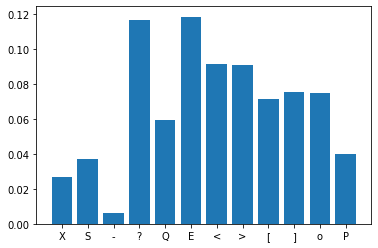

In [61]:
plt.bar(np.unique(tile_idx_errors), np.bincount(tile_idx_errors) / np.bincount(original_int.flatten()))
plt.xticks(np.unique(tile_idx_errors), [int2char_smb[i] for i in np.unique(tile_idx_errors)])
plt.show()

In [62]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [63]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [64]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [65]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(2698, 2698)

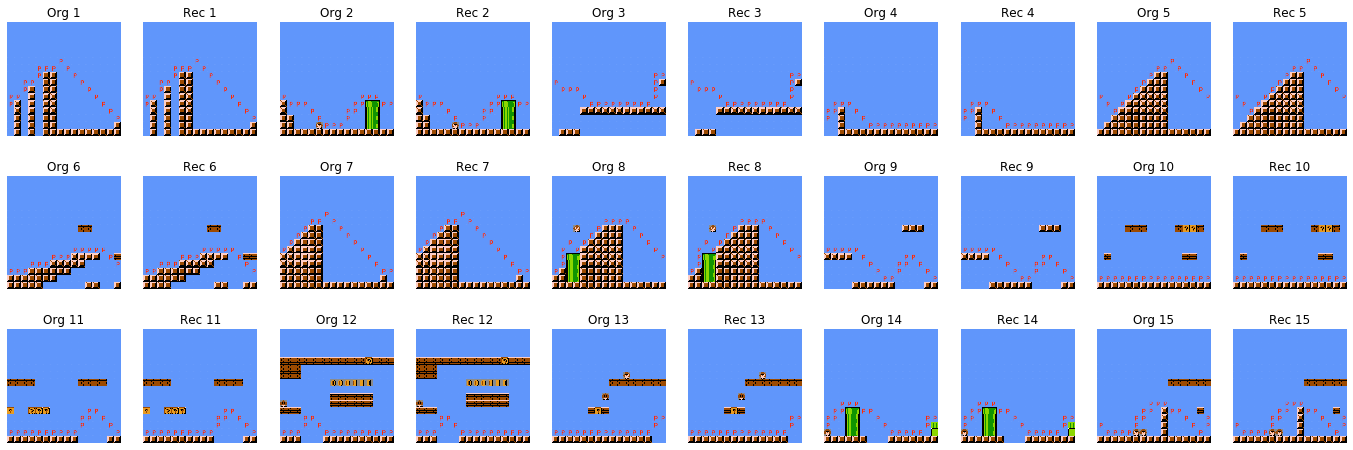

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

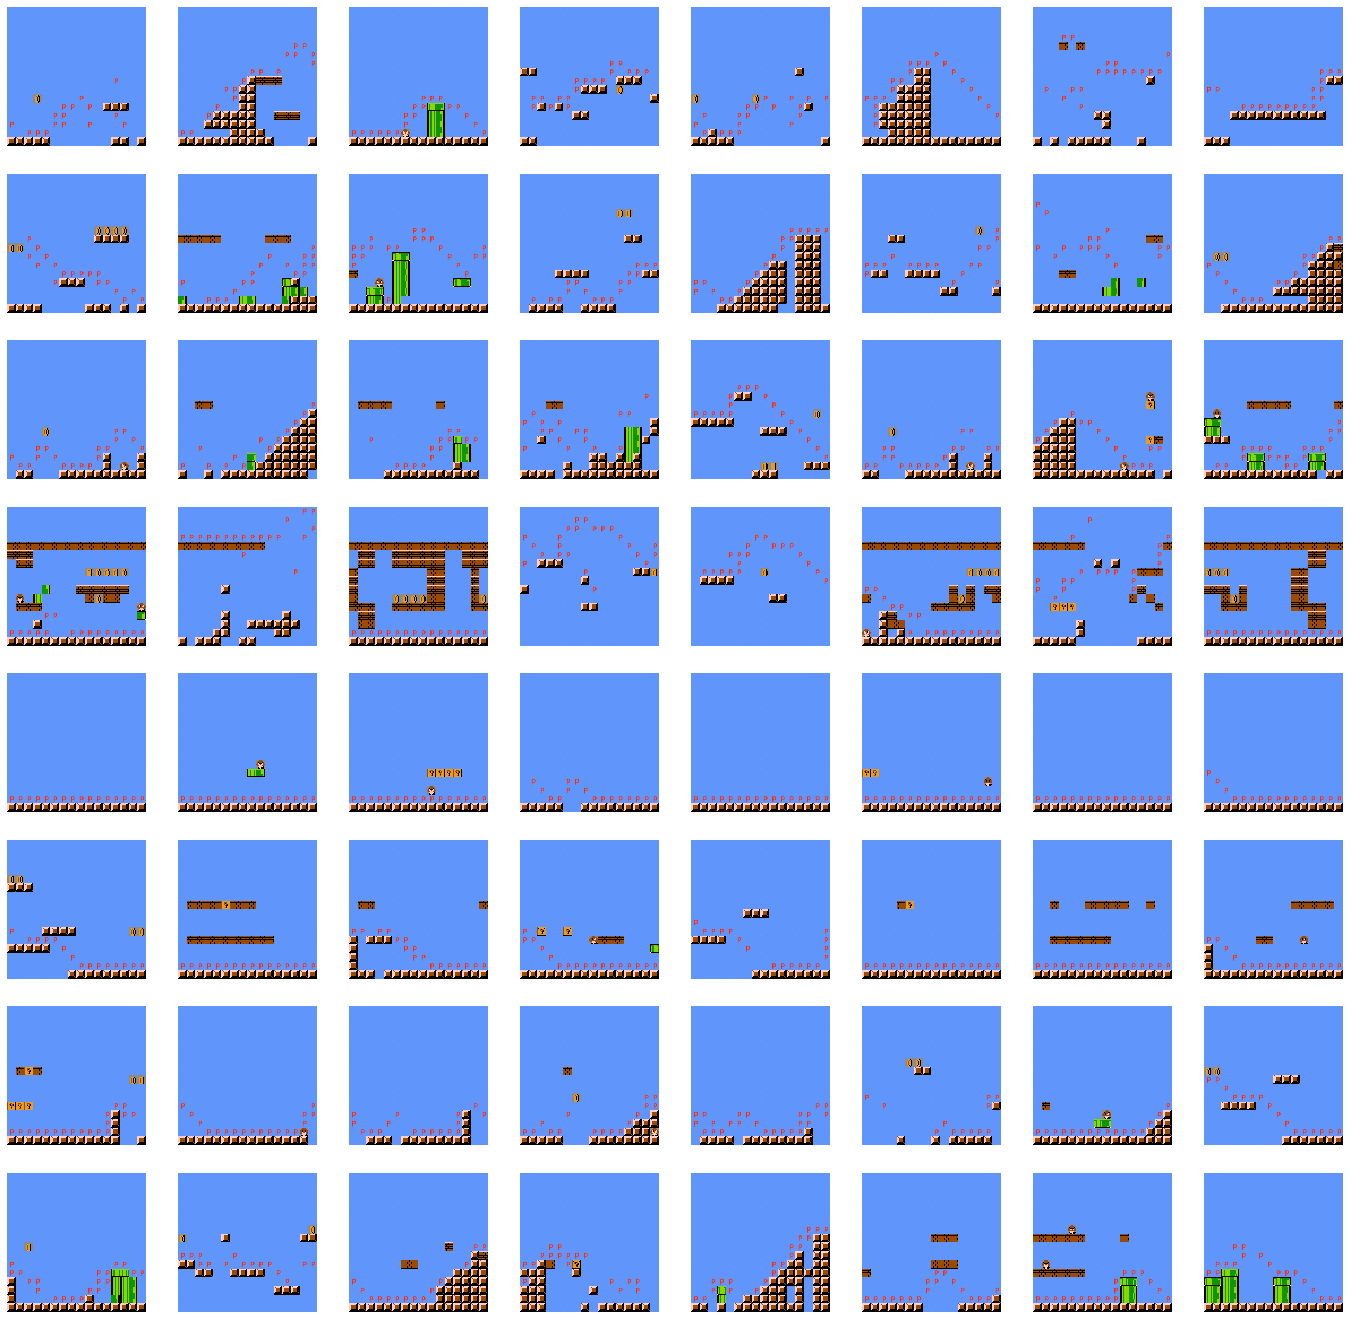

In [67]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 8
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [83]:
elem_per_category = 10000 // 8
generated = gmvae.random_generation(elem_per_category)

In [84]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [85]:
generated_int.shape

(10000, 16, 16)

In [86]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_8_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [75]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [76]:
np.bincount(test_labels)

array([329, 304, 330, 436, 199, 257, 272, 301])

In [77]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [78]:
test_labels_subset = test_labels[:first_n]

In [79]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

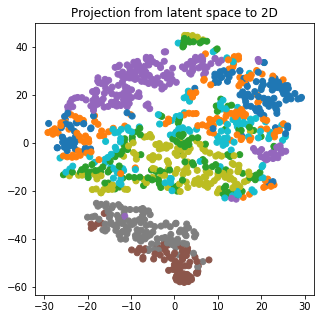

In [81]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='tab10')

plt.title('Projection from latent space to 2D')
plt.show()